## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


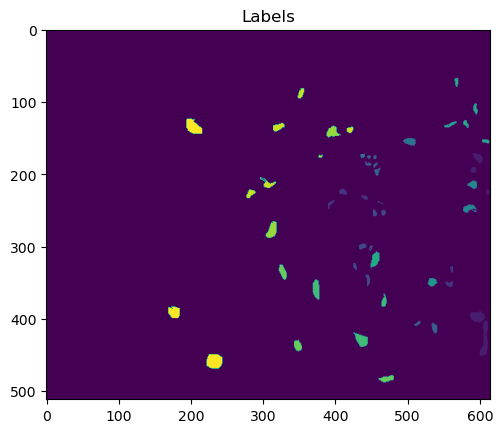

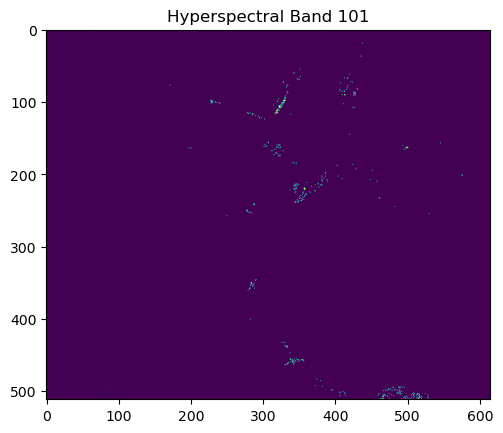

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(260, 5, 5, 176)
(65, 5, 5, 176)
(4886, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 260
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2528, PSNR: 5.9715


Epoch [1/50] Training Loss: 0.2434, PSNR: 6.1380
	[Val]   Batch [1/17] Loss: 0.2335, PSNR: 6.3167
	[Val]   Batch [10/17] Loss: 0.2337, PSNR: 6.3134
Epoch [1/50] Validation Loss: 0.2336, PSNR: 6.3153

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2276, PSNR: 6.4274


Epoch [2/50] Training Loss: 0.2092, PSNR: 6.8002
	[Val]   Batch [1/17] Loss: 0.1880, PSNR: 7.2583
	[Val]   Batch [10/17] Loss: 0.1895, PSNR: 7.2247
Epoch [2/50] Validation Loss: 0.1889, PSNR: 7.2374

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1862, PSNR: 7.3013


Epoch [3/50] Training Loss: 0.1702, PSNR: 7.6983
	[Val]   Batch [1/17] Loss: 0.1499, PSNR: 8.2427
	[Val]   Batch [10/17] Loss: 0.1532, PSNR: 8.1477
Epoch [3/50] Validation Loss: 0.1523, PSNR: 8.1723

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1492, PSNR: 8.2617


Epoch [4/50] Training Loss: 0.1366, PSNR: 8.6534
	[Val]   Batch [1/17] Loss: 0.1187, PSNR: 9.2571
	[Val]   Batch [10/17] Loss: 0.1203, PSNR: 9.1977
Epoch [4/50] Validation Loss: 0.1200, PSNR: 9.2096

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1185, PSNR: 9.2639


Epoch [5/50] Training Loss: 0.1083, PSNR: 8.9713
	[Val]   Batch [1/17] Loss: 0.0951, PSNR: 10.2200
	[Val]   Batch [10/17] Loss: 0.0970, PSNR: 10.1339
Epoch [5/50] Validation Loss: 0.0965, PSNR: 10.1549

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0938, PSNR: 10.2779


Epoch [6/50] Training Loss: 0.0858, PSNR: 10.6726
	[Val]   Batch [1/17] Loss: 0.0767, PSNR: 11.1515
	[Val]   Batch [10/17] Loss: 0.0768, PSNR: 11.1458
Epoch [6/50] Validation Loss: 0.0769, PSNR: 11.1382

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0750, PSNR: 11.2520


Epoch [7/50] Training Loss: 0.0688, PSNR: 11.6290
	[Val]   Batch [1/17] Loss: 0.0617, PSNR: 12.0941
	[Val]   Batch [10/17] Loss: 0.0625, PSNR: 12.0421
Epoch [7/50] Validation Loss: 0.0624, PSNR: 12.0515

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0604, PSNR: 12.1874


Epoch [8/50] Training Loss: 0.0560, PSNR: 12.5268
	[Val]   Batch [1/17] Loss: 0.0513, PSNR: 12.8955
	[Val]   Batch [10/17] Loss: 0.0518, PSNR: 12.8568
Epoch [8/50] Validation Loss: 0.0516, PSNR: 12.8747

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0501, PSNR: 12.9981


Epoch [9/50] Training Loss: 0.0464, PSNR: 13.3408
	[Val]   Batch [1/17] Loss: 0.0431, PSNR: 13.6533
	[Val]   Batch [10/17] Loss: 0.0434, PSNR: 13.6203
Epoch [9/50] Validation Loss: 0.0433, PSNR: 13.6361

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0416, PSNR: 13.8117


Epoch [10/50] Training Loss: 0.0390, PSNR: 14.0913
	[Val]   Batch [1/17] Loss: 0.0370, PSNR: 14.3218
	[Val]   Batch [10/17] Loss: 0.0373, PSNR: 14.2841
Epoch [10/50] Validation Loss: 0.0371, PSNR: 14.3068

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0356, PSNR: 14.4823


Epoch [11/50] Training Loss: 0.0334, PSNR: 14.0947
	[Val]   Batch [1/17] Loss: 0.0320, PSNR: 14.9527
	[Val]   Batch [10/17] Loss: 0.0324, PSNR: 14.8891
Epoch [11/50] Validation Loss: 0.0322, PSNR: 14.9190

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0304, PSNR: 15.1661


Epoch [12/50] Training Loss: 0.0289, PSNR: 15.3974
	[Val]   Batch [1/17] Loss: 0.0276, PSNR: 15.5927
	[Val]   Batch [10/17] Loss: 0.0279, PSNR: 15.5394
Epoch [12/50] Validation Loss: 0.0278, PSNR: 15.5656

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0268, PSNR: 15.7133


Epoch [13/50] Training Loss: 0.0253, PSNR: 15.9731
	[Val]   Batch [1/17] Loss: 0.0240, PSNR: 16.1975
	[Val]   Batch [10/17] Loss: 0.0242, PSNR: 16.1608
Epoch [13/50] Validation Loss: 0.0241, PSNR: 16.1795

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0235, PSNR: 16.2964


Epoch [14/50] Training Loss: 0.0224, PSNR: 16.5028
	[Val]   Batch [1/17] Loss: 0.0217, PSNR: 16.6274
	[Val]   Batch [10/17] Loss: 0.0221, PSNR: 16.5478
Epoch [14/50] Validation Loss: 0.0220, PSNR: 16.5829

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0210, PSNR: 16.7793


Epoch [15/50] Training Loss: 0.0200, PSNR: 16.9936
	[Val]   Batch [1/17] Loss: 0.0196, PSNR: 17.0770
	[Val]   Batch [10/17] Loss: 0.0199, PSNR: 17.0142
Epoch [15/50] Validation Loss: 0.0198, PSNR: 17.0440

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0188, PSNR: 17.2491


Epoch [16/50] Training Loss: 0.0180, PSNR: 17.4572
	[Val]   Batch [1/17] Loss: 0.0175, PSNR: 17.5682
	[Val]   Batch [10/17] Loss: 0.0177, PSNR: 17.5324
Epoch [16/50] Validation Loss: 0.0176, PSNR: 17.5485

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0168, PSNR: 17.7454


Epoch [17/50] Training Loss: 0.0163, PSNR: 17.8841
	[Val]   Batch [1/17] Loss: 0.0160, PSNR: 17.9607
	[Val]   Batch [10/17] Loss: 0.0163, PSNR: 17.8902
Epoch [17/50] Validation Loss: 0.0161, PSNR: 17.9215

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0154, PSNR: 18.1223


Epoch [18/50] Training Loss: 0.0148, PSNR: 18.2916
	[Val]   Batch [1/17] Loss: 0.0147, PSNR: 18.3180
	[Val]   Batch [10/17] Loss: 0.0149, PSNR: 18.2582
Epoch [18/50] Validation Loss: 0.0148, PSNR: 18.2868

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0142, PSNR: 18.4840


Epoch [19/50] Training Loss: 0.0135, PSNR: 18.6887
	[Val]   Batch [1/17] Loss: 0.0134, PSNR: 18.7363
	[Val]   Batch [10/17] Loss: 0.0136, PSNR: 18.6650
Epoch [19/50] Validation Loss: 0.0135, PSNR: 18.6989

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0130, PSNR: 18.8547


Epoch [20/50] Training Loss: 0.0124, PSNR: 18.3836
	[Val]   Batch [1/17] Loss: 0.0125, PSNR: 19.0402
	[Val]   Batch [10/17] Loss: 0.0127, PSNR: 18.9618
Epoch [20/50] Validation Loss: 0.0126, PSNR: 18.9987

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0118, PSNR: 19.2735


Epoch [21/50] Training Loss: 0.0115, PSNR: 18.7106
	[Val]   Batch [1/17] Loss: 0.0116, PSNR: 19.3731
	[Val]   Batch [10/17] Loss: 0.0118, PSNR: 19.2780
Epoch [21/50] Validation Loss: 0.0117, PSNR: 19.3191

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0110, PSNR: 19.5860


Epoch [22/50] Training Loss: 0.0106, PSNR: 19.7312
	[Val]   Batch [1/17] Loss: 0.0106, PSNR: 19.7597
	[Val]   Batch [10/17] Loss: 0.0108, PSNR: 19.6803
Epoch [22/50] Validation Loss: 0.0107, PSNR: 19.7188

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0101, PSNR: 19.9593


Epoch [23/50] Training Loss: 0.0099, PSNR: 19.3681
	[Val]   Batch [1/17] Loss: 0.0099, PSNR: 20.0354
	[Val]   Batch [10/17] Loss: 0.0101, PSNR: 19.9463
Epoch [23/50] Validation Loss: 0.0100, PSNR: 19.9873

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0095, PSNR: 20.2035


Epoch [24/50] Training Loss: 0.0092, PSNR: 19.6740
	[Val]   Batch [1/17] Loss: 0.0093, PSNR: 20.3108
	[Val]   Batch [10/17] Loss: 0.0095, PSNR: 20.2124
Epoch [24/50] Validation Loss: 0.0094, PSNR: 20.2550

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0089, PSNR: 20.5050


Epoch [25/50] Training Loss: 0.0086, PSNR: 20.6566
	[Val]   Batch [1/17] Loss: 0.0085, PSNR: 20.6824
	[Val]   Batch [10/17] Loss: 0.0087, PSNR: 20.5984
Epoch [25/50] Validation Loss: 0.0086, PSNR: 20.6378

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0082, PSNR: 20.8404


Epoch [26/50] Training Loss: 0.0080, PSNR: 20.2657
	[Val]   Batch [1/17] Loss: 0.0081, PSNR: 20.9207
	[Val]   Batch [10/17] Loss: 0.0083, PSNR: 20.8233
Epoch [26/50] Validation Loss: 0.0082, PSNR: 20.8655

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0077, PSNR: 21.1141


Epoch [27/50] Training Loss: 0.0075, PSNR: 21.2233
	[Val]   Batch [1/17] Loss: 0.0076, PSNR: 21.1902
	[Val]   Batch [10/17] Loss: 0.0078, PSNR: 21.0822
Epoch [27/50] Validation Loss: 0.0077, PSNR: 21.1291

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0075, PSNR: 21.2526


Epoch [28/50] Training Loss: 0.0071, PSNR: 21.4778
	[Val]   Batch [1/17] Loss: 0.0070, PSNR: 21.5298
	[Val]   Batch [10/17] Loss: 0.0072, PSNR: 21.4290
Epoch [28/50] Validation Loss: 0.0071, PSNR: 21.4707

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0069, PSNR: 21.6404


Epoch [29/50] Training Loss: 0.0067, PSNR: 21.7438
	[Val]   Batch [1/17] Loss: 0.0067, PSNR: 21.7512
	[Val]   Batch [10/17] Loss: 0.0068, PSNR: 21.6584
Epoch [29/50] Validation Loss: 0.0068, PSNR: 21.7000

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0065, PSNR: 21.8549


Epoch [30/50] Training Loss: 0.0063, PSNR: 21.2990
	[Val]   Batch [1/17] Loss: 0.0064, PSNR: 21.9370
	[Val]   Batch [10/17] Loss: 0.0066, PSNR: 21.8145
Epoch [30/50] Validation Loss: 0.0065, PSNR: 21.8649

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0060, PSNR: 22.2013


Epoch [31/50] Training Loss: 0.0060, PSNR: 22.2216
	[Val]   Batch [1/17] Loss: 0.0060, PSNR: 22.2171
	[Val]   Batch [10/17] Loss: 0.0061, PSNR: 22.1134
Epoch [31/50] Validation Loss: 0.0061, PSNR: 22.1601

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0057, PSNR: 22.4370


Epoch [32/50] Training Loss: 0.0057, PSNR: 21.7777
	[Val]   Batch [1/17] Loss: 0.0058, PSNR: 22.3674
	[Val]   Batch [10/17] Loss: 0.0060, PSNR: 22.2367
Epoch [32/50] Validation Loss: 0.0059, PSNR: 22.2909

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0054, PSNR: 22.6860


Epoch [33/50] Training Loss: 0.0054, PSNR: 22.6663
	[Val]   Batch [1/17] Loss: 0.0054, PSNR: 22.7022
	[Val]   Batch [10/17] Loss: 0.0055, PSNR: 22.5834
Epoch [33/50] Validation Loss: 0.0055, PSNR: 22.6341

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0053, PSNR: 22.7639


Epoch [34/50] Training Loss: 0.0051, PSNR: 22.8859
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.8965
	[Val]   Batch [10/17] Loss: 0.0053, PSNR: 22.7673
Epoch [34/50] Validation Loss: 0.0052, PSNR: 22.8224

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0050, PSNR: 23.0449


Epoch [35/50] Training Loss: 0.0049, PSNR: 22.4226
	[Val]   Batch [1/17] Loss: 0.0050, PSNR: 23.0476
	[Val]   Batch [10/17] Loss: 0.0051, PSNR: 22.8941
Epoch [35/50] Validation Loss: 0.0051, PSNR: 22.9565

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0047, PSNR: 23.2700


Epoch [36/50] Training Loss: 0.0047, PSNR: 22.6212
	[Val]   Batch [1/17] Loss: 0.0048, PSNR: 23.2302
	[Val]   Batch [10/17] Loss: 0.0049, PSNR: 23.0862
Epoch [36/50] Validation Loss: 0.0048, PSNR: 23.1460

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0046, PSNR: 23.3985


Epoch [37/50] Training Loss: 0.0045, PSNR: 23.4953
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5395
	[Val]   Batch [10/17] Loss: 0.0046, PSNR: 23.3826
Epoch [37/50] Validation Loss: 0.0045, PSNR: 23.4466

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.6332


Epoch [38/50] Training Loss: 0.0043, PSNR: 23.6871
	[Val]   Batch [1/17] Loss: 0.0043, PSNR: 23.6596
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.5221
Epoch [38/50] Validation Loss: 0.0044, PSNR: 23.5797

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.7905


Epoch [39/50] Training Loss: 0.0041, PSNR: 23.8749
	[Val]   Batch [1/17] Loss: 0.0041, PSNR: 23.8627
	[Val]   Batch [10/17] Loss: 0.0043, PSNR: 23.6978
Epoch [39/50] Validation Loss: 0.0042, PSNR: 23.7645

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 24.0077


Epoch [40/50] Training Loss: 0.0039, PSNR: 24.0599
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.0491
	[Val]   Batch [10/17] Loss: 0.0041, PSNR: 23.8928
Epoch [40/50] Validation Loss: 0.0040, PSNR: 23.9613

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0037, PSNR: 24.3044


Epoch [41/50] Training Loss: 0.0038, PSNR: 23.5559
	[Val]   Batch [1/17] Loss: 0.0038, PSNR: 24.1932
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 24.0169
Epoch [41/50] Validation Loss: 0.0039, PSNR: 24.0883

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.4440


Epoch [42/50] Training Loss: 0.0036, PSNR: 24.4031
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.3892
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.2164
Epoch [42/50] Validation Loss: 0.0037, PSNR: 24.2890

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0037, PSNR: 24.3570


Epoch [43/50] Training Loss: 0.0035, PSNR: 24.5699
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.5695
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.3815
Epoch [43/50] Validation Loss: 0.0036, PSNR: 24.4633

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.7351


Epoch [44/50] Training Loss: 0.0034, PSNR: 24.0673
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.6873
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4974
Epoch [44/50] Validation Loss: 0.0035, PSNR: 24.5759

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.9034


Epoch [45/50] Training Loss: 0.0032, PSNR: 24.9111
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9211
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.7189
Epoch [45/50] Validation Loss: 0.0033, PSNR: 24.8030

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.1487


Epoch [46/50] Training Loss: 0.0031, PSNR: 25.0665
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1383
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9364
Epoch [46/50] Validation Loss: 0.0031, PSNR: 25.0215

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.9207


Epoch [47/50] Training Loss: 0.0030, PSNR: 25.2302
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.2468
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.0476
Epoch [47/50] Validation Loss: 0.0031, PSNR: 25.1305

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.1067


Epoch [48/50] Training Loss: 0.0029, PSNR: 25.3883
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3799
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.1704
Epoch [48/50] Validation Loss: 0.0030, PSNR: 25.2567

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2783


Epoch [49/50] Training Loss: 0.0028, PSNR: 24.8591
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.4829
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2573
Epoch [49/50] Validation Loss: 0.0029, PSNR: 25.3509

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0027, PSNR: 25.7302


Epoch [50/50] Training Loss: 0.0027, PSNR: 25.6686
	[Val]   Batch [1/17] Loss: 0.0027, PSNR: 25.7266
	[Val]   Batch [10/17] Loss: 0.0028, PSNR: 25.4991
Epoch [50/50] Validation Loss: 0.0028, PSNR: 25.5903


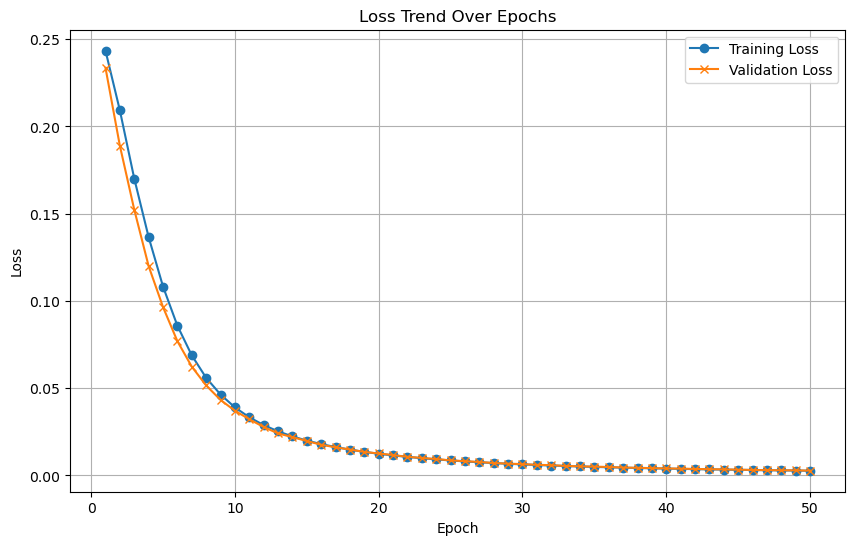

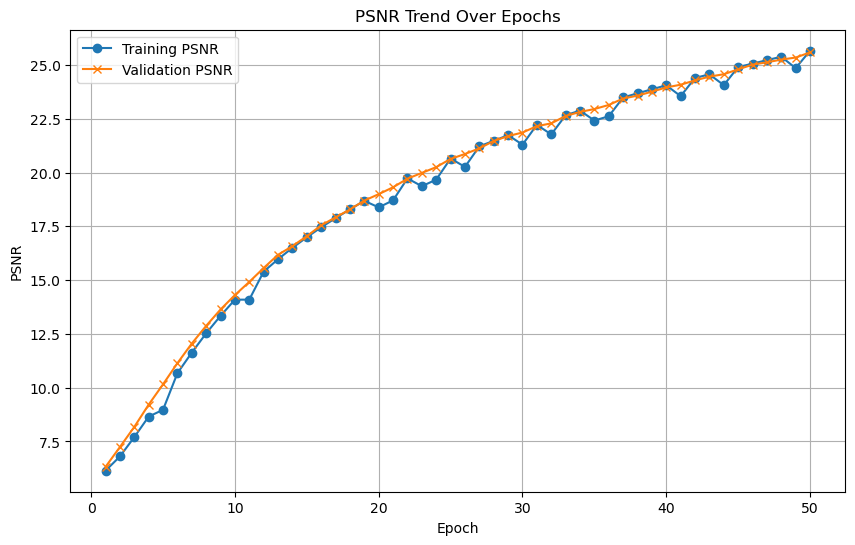

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.6317
    Validation Batch [1/1], Loss: 2.5693
Validation Loss: 2.5693, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5693. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6081
    Validation Batch [1/1], Loss: 2.5693
Validation Loss: 2.5693, Validation Accuracy: 7.69%
Validation loss improved from 2.5693 to 2.5693. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5887
    Validation Batch [1/1], Loss: 2.5693
Validation Loss: 2.5693, Validation Accuracy: 7.69%
Validation loss improved from 2.5693 to 2.5693. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5842
    Validation Batch [1/1], Loss: 2.5693
Validation Loss: 2.5693, Validation Accuracy: 7.69%
Validation loss improved from 2.5693 to 2.5693. Saving model...

LOG: Epoch [5/1000] - 

Epoch [16/1000] completed, Average Training Loss: 2.4939
    Validation Batch [1/1], Loss: 2.5692
Validation Loss: 2.5692, Validation Accuracy: 7.69%
Validation loss improved from 2.5692 to 2.5692. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.4904
    Validation Batch [1/1], Loss: 2.5691
Validation Loss: 2.5691, Validation Accuracy: 7.69%
Validation loss improved from 2.5692 to 2.5691. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.4867
    Validation Batch [1/1], Loss: 2.5691
Validation Loss: 2.5691, Validation Accuracy: 7.69%
Validation loss improved from 2.5691 to 2.5691. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.4814
    Validation Batch [1/1], Loss: 2.5690
Validation Loss: 2.5690, Validation Accuracy: 7.69%
Validation loss improved from 2.5691 to 2.5690. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/10

Epoch [41/1000] completed, Average Training Loss: 2.3129
    Validation Batch [1/1], Loss: 2.5719
Validation Loss: 2.5719, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.3203
    Validation Batch [1/1], Loss: 2.5722
Validation Loss: 2.5722, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.3097
    Validation Batch [1/1], Loss: 2.5725
Validation Loss: 2.5725, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 2.2993
    Validation Batch [1/1], Loss: 2.5726
Validation Loss: 2.5726, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 2.2901
    Validat

Epoch [69/1000] completed, Average Training Loss: 2.0729
    Validation Batch [1/1], Loss: 2.5114
Validation Loss: 2.5114, Validation Accuracy: 23.08%
Validation loss improved from 2.5188 to 2.5114. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 2.0904
    Validation Batch [1/1], Loss: 2.5030
Validation Loss: 2.5030, Validation Accuracy: 23.08%
Validation loss improved from 2.5114 to 2.5030. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 2.0778
    Validation Batch [1/1], Loss: 2.4938
Validation Loss: 2.4938, Validation Accuracy: 23.08%
Validation loss improved from 2.5030 to 2.4938. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 2.0610
    Validation Batch [1/1], Loss: 2.4838
Validation Loss: 2.4838, Validation Accuracy: 23.08%
Validation loss improved from 2.4938 to 2.4838. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [7

Epoch [94/1000] completed, Average Training Loss: 1.9036
    Validation Batch [1/1], Loss: 2.1553
Validation Loss: 2.1553, Validation Accuracy: 38.46%
Validation loss improved from 2.1762 to 2.1553. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.8705
    Validation Batch [1/1], Loss: 2.1357
Validation Loss: 2.1357, Validation Accuracy: 40.00%
Validation loss improved from 2.1553 to 2.1357. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.8594
    Validation Batch [1/1], Loss: 2.1182
Validation Loss: 2.1182, Validation Accuracy: 40.00%
Validation loss improved from 2.1357 to 2.1182. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.8504
    Validation Batch [1/1], Loss: 2.1040
Validation Loss: 2.1040, Validation Accuracy: 41.54%
Validation loss improved from 2.1182 to 2.1040. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [9

    Validation Batch [1/1], Loss: 1.8624
Validation Loss: 1.8624, Validation Accuracy: 47.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.6805
    Validation Batch [1/1], Loss: 1.8709
Validation Loss: 1.8709, Validation Accuracy: 47.69%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.6661
    Validation Batch [1/1], Loss: 1.8599
Validation Loss: 1.8599, Validation Accuracy: 47.69%
Validation loss improved from 1.8608 to 1.8599. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.6756
    Validation Batch [1/1], Loss: 1.8280
Validation Loss: 1.8280, Validation Accuracy: 50.77%
Validation loss improved from 1.8599 to 1.8280. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.6268
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 1.6405
Validation Loss: 1.6405, Validation Accuracy: 61.54%
Validation loss improved from 1.6505 to 1.6405. Saving model...

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 1.4445
    Validation Batch [1/1], Loss: 1.6390
Validation Loss: 1.6390, Validation Accuracy: 60.00%
Validation loss improved from 1.6405 to 1.6390. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 1.4527
    Validation Batch [1/1], Loss: 1.6410
Validation Loss: 1.6410, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.4362
    Validation Batch [1/1], Loss: 1.6386
Validation Loss: 1.6386, Validation Accuracy: 60.00%
Validation loss improved from 1.6390 to 1.6386. Saving model...

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.4043
    Validation 

Epoch [172/1000] completed, Average Training Loss: 1.1881
    Validation Batch [1/1], Loss: 1.4718
Validation Loss: 1.4718, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 1.1941
    Validation Batch [1/1], Loss: 1.4497
Validation Loss: 1.4497, Validation Accuracy: 64.62%
Validation loss improved from 1.4717 to 1.4497. Saving model...

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 1.2198
    Validation Batch [1/1], Loss: 1.4347
Validation Loss: 1.4347, Validation Accuracy: 64.62%
Validation loss improved from 1.4497 to 1.4347. Saving model...

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 1.1609
    Validation Batch [1/1], Loss: 1.4402
Validation Loss: 1.4402, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Av

    Validation Batch [1/1], Loss: 1.2739
Validation Loss: 1.2739, Validation Accuracy: 73.85%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.9732
    Validation Batch [1/1], Loss: 1.2743
Validation Loss: 1.2743, Validation Accuracy: 73.85%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.9812
    Validation Batch [1/1], Loss: 1.2704
Validation Loss: 1.2704, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.9965
    Validation Batch [1/1], Loss: 1.2660
Validation Loss: 1.2660, Validation Accuracy: 76.92%
Validation loss improved from 1.2682 to 1.2660. Saving model...

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.9731
    Validation Batch [1/1], Loss: 1.2507
Vali

    Validation Batch [1/1], Loss: 1.1364
Validation Loss: 1.1364, Validation Accuracy: 75.38%
Validation loss improved from 1.1434 to 1.1364. Saving model...

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.7851
    Validation Batch [1/1], Loss: 1.1307
Validation Loss: 1.1307, Validation Accuracy: 75.38%
Validation loss improved from 1.1364 to 1.1307. Saving model...

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.7688
    Validation Batch [1/1], Loss: 1.1569
Validation Loss: 1.1569, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.7476
    Validation Batch [1/1], Loss: 1.1345
Validation Loss: 1.1345, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.7297
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 1.0182
Validation Loss: 1.0182, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.5997
    Validation Batch [1/1], Loss: 1.0498
Validation Loss: 1.0498, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.6209
    Validation Batch [1/1], Loss: 1.0294
Validation Loss: 1.0294, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.5862
    Validation Batch [1/1], Loss: 0.9955
Validation Loss: 0.9955, Validation Accuracy: 80.00%
Validation loss improved from 1.0115 to 0.9955. Saving model...

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.5679
    Validation Batch [1/1], Loss: 0.9942
Vali

Epoch [276/1000] completed, Average Training Loss: 0.4642
    Validation Batch [1/1], Loss: 0.9867
Validation Loss: 0.9867, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.4635
    Validation Batch [1/1], Loss: 0.9728
Validation Loss: 0.9728, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.4138
    Validation Batch [1/1], Loss: 0.9629
Validation Loss: 0.9629, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.4376
    Validation Batch [1/1], Loss: 0.9567
Validation Loss: 0.9567, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.4222
  

    Validation Batch [1/1], Loss: 0.8851
Validation Loss: 0.8851, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.3211
    Validation Batch [1/1], Loss: 0.8755
Validation Loss: 0.8755, Validation Accuracy: 83.08%
Validation loss improved from 0.8792 to 0.8755. Saving model...

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.3161
    Validation Batch [1/1], Loss: 0.8813
Validation Loss: 0.8813, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.3291
    Validation Batch [1/1], Loss: 0.8837
Validation Loss: 0.8837, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.3010
    Validation Batch [1/1], Loss: 0.8785
Vali

Epoch [327/1000] completed, Average Training Loss: 0.2374
    Validation Batch [1/1], Loss: 0.8161
Validation Loss: 0.8161, Validation Accuracy: 84.62%
Validation loss improved from 0.8163 to 0.8161. Saving model...

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.2554
    Validation Batch [1/1], Loss: 0.8191
Validation Loss: 0.8191, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.2447
    Validation Batch [1/1], Loss: 0.8170
Validation Loss: 0.8170, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.2458
    Validation Batch [1/1], Loss: 0.7990
Validation Loss: 0.7990, Validation Accuracy: 86.15%
Validation loss improved from 0.8161 to 0.7990. Saving model...

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Av

Epoch [353/1000] completed, Average Training Loss: 0.1918
    Validation Batch [1/1], Loss: 0.7881
Validation Loss: 0.7881, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.1795
    Validation Batch [1/1], Loss: 0.7876
Validation Loss: 0.7876, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.1705
    Validation Batch [1/1], Loss: 0.7885
Validation Loss: 0.7885, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.1712
    Validation Batch [1/1], Loss: 0.7795
Validation Loss: 0.7795, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.1833
  

    Validation Batch [1/1], Loss: 0.7471
Validation Loss: 0.7471, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.1409
    Validation Batch [1/1], Loss: 0.7527
Validation Loss: 0.7527, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.1332
    Validation Batch [1/1], Loss: 0.7630
Validation Loss: 0.7630, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.1336
    Validation Batch [1/1], Loss: 0.7631
Validation Loss: 0.7631, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.1424
    Validation Batch [1/1], Loss: 0.7666
Validation Loss: 

    Validation Batch [1/1], Loss: 0.7536
Validation Loss: 0.7536, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.1222
    Validation Batch [1/1], Loss: 0.7562
Validation Loss: 0.7562, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.1196
    Validation Batch [1/1], Loss: 0.7640
Validation Loss: 0.7640, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.1112
    Validation Batch [1/1], Loss: 0.7529
Validation Loss: 0.7529, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.1204
    Validation Batch [1/1], Loss: 0.7464
Validation Loss: 

Epoch [419/1000] completed, Average Training Loss: 0.1071
    Validation Batch [1/1], Loss: 0.7313
Validation Loss: 0.7313, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.0969
    Validation Batch [1/1], Loss: 0.7301
Validation Loss: 0.7301, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.0998
    Validation Batch [1/1], Loss: 0.7246
Validation Loss: 0.7246, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.1096
    Validation Batch [1/1], Loss: 0.7367
Validation Loss: 0.7367, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.085

Epoch [444/1000] completed, Average Training Loss: 0.0877
    Validation Batch [1/1], Loss: 0.8000
Validation Loss: 0.8000, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.0865
    Validation Batch [1/1], Loss: 0.7977
Validation Loss: 0.7977, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.0911
    Validation Batch [1/1], Loss: 0.7632
Validation Loss: 0.7632, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.0814
    Validation Batch [1/1], Loss: 0.7382
Validation Loss: 0.7382, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.101

Epoch [470/1000] completed, Average Training Loss: 0.0786
    Validation Batch [1/1], Loss: 0.7541
Validation Loss: 0.7541, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.0699
    Validation Batch [1/1], Loss: 0.7402
Validation Loss: 0.7402, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.0732
    Validation Batch [1/1], Loss: 0.7315
Validation Loss: 0.7315, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.0679
    Validation Batch [1/1], Loss: 0.7359
Validation Loss: 0.7359, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.067

    Validation Batch [1/1], Loss: 0.7327
Validation Loss: 0.7327, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0611
    Validation Batch [1/1], Loss: 0.7415
Validation Loss: 0.7415, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0697
    Validation Batch [1/1], Loss: 0.7475
Validation Loss: 0.7475, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.0577
    Validation Batch [1/1], Loss: 0.7501
Validation Loss: 0.7501, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.0599
    Validation Batch [1/1], Loss: 0.7514
Validation Loss: 0.

Epoch [517/1000] completed, Average Training Loss: 0.0561
    Validation Batch [1/1], Loss: 0.7125
Validation Loss: 0.7125, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.0576
    Validation Batch [1/1], Loss: 0.7131
Validation Loss: 0.7131, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.0685
    Validation Batch [1/1], Loss: 0.7210
Validation Loss: 0.7210, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0498
    Validation Batch [1/1], Loss: 0.7301
Validation Loss: 0.7301, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0550
  

    Validation Batch [1/1], Loss: 0.7145
Validation Loss: 0.7145, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0442
    Validation Batch [1/1], Loss: 0.7047
Validation Loss: 0.7047, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0523
    Validation Batch [1/1], Loss: 0.7094
Validation Loss: 0.7094, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0520
    Validation Batch [1/1], Loss: 0.7203
Validation Loss: 0.7203, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0470
    Validation Batch [1/1], Loss: 0.7267
Validation Loss

    Validation Batch [1/1], Loss: 0.7967
Validation Loss: 0.7967, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0585
    Validation Batch [1/1], Loss: 0.8055
Validation Loss: 0.8055, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.8066
Validation Loss: 0.8066, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0380
    Validation Batch [1/1], Loss: 0.8151
Validation Loss: 0.8151, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0444
    Validation Batch [1/1], Loss: 0.8044
Validation Loss

    Validation Batch [1/1], Loss: 0.7945
Validation Loss: 0.7945, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0429
    Validation Batch [1/1], Loss: 0.8040
Validation Loss: 0.8040, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.0418
    Validation Batch [1/1], Loss: 0.8025
Validation Loss: 0.8025, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.0370
    Validation Batch [1/1], Loss: 0.8023
Validation Loss: 0.8023, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [597/1000] - Training
Epoch [597/1000] completed, Average Training Loss: 0.0359
    Validation Batch [1/1], Loss: 0.8018
Validation Loss

Epoch [618/1000] completed, Average Training Loss: 0.0381
    Validation Batch [1/1], Loss: 0.7218
Validation Loss: 0.7218, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.0314
    Validation Batch [1/1], Loss: 0.7338
Validation Loss: 0.7338, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [620/1000] - Training
Epoch [620/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.7413
Validation Loss: 0.7413, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.0379
    Validation Batch [1/1], Loss: 0.7327
Validation Loss: 0.7327, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.036

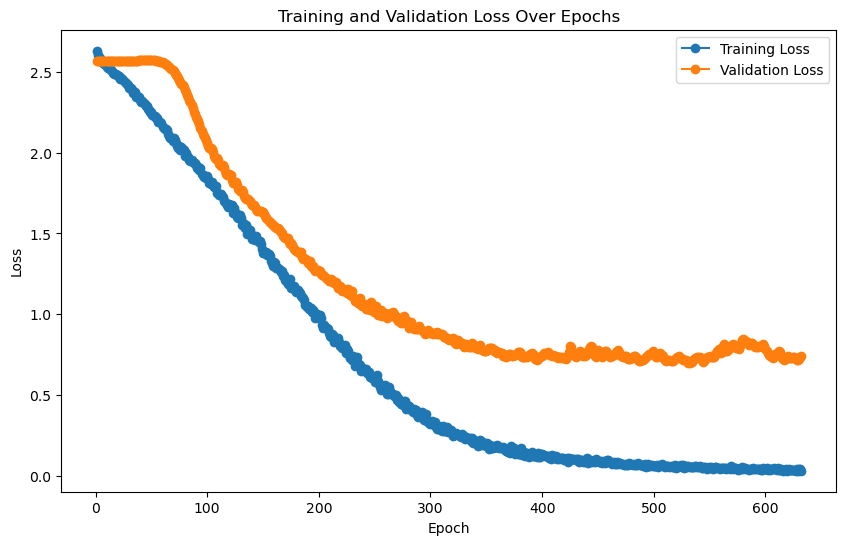

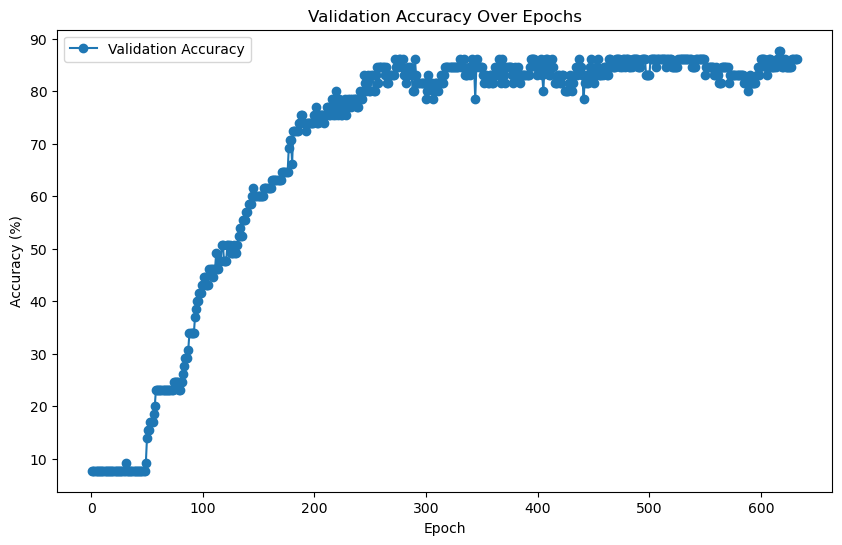


Evaluating on the test set...
    Test Batch [1/20], Loss: 0.7409

Final Test Loss: 1.1673, Test Accuracy: 80.60%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)

LOG: Training features shape: (260, 64), Training labels shape: (260,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (4886, 64), Test labels shape: (4886,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 47.69%

Validation Classification Report:
               precision    recall  f1

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)
Train reps shape: (260, 64)
Train labels shape: (260,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (4886, 64)
Test labels shape: (4886,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7254  |  Val Loss: 2.5778
Validation loss improved from inf to 2.5778.
[Epoch 2/1000] Train Loss: 2.5586  |  Val Loss: 2.5470
Validation loss improved from 2.5778 to 2.5470.
[Epoch 3/1000] Train Loss: 2.5019  |  Val Loss: 2.5107
Validation loss improved from 2.5470 to 2.5107.
[Epoch 4/1000] Train Loss: 2.4618  |  Val Loss: 2.4810
Validation loss improved from 2.5107 to 2.4810.
[Epoch 5/1000] Train Loss: 2.4395  |  Val Loss: 2.4731
Validation loss improved from 2.4810 to 2.4731.
[Epoch 6/1000] Train Loss: 2.4220  |  Val Loss: 2.4717
Validation loss improved from 2.4731 to 2.4717.
[Epoch 7/1000] Train Loss: 2.4163  |  Val Loss: 2.4674
Validation loss improved from 2.4717 to 2.4674.
[Epoch 8/1000] Train Loss: 2.4015  |  Val Loss: 2.4685
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 9/1000] Train Loss: 2.3972  |  Val Loss: 2.4578
Validation loss improved from 2.4674 to 2.4578.
[Epoch 10/1000] Train Loss: 2.3904  |  Val Loss: 2.4540
Validation los

[Epoch 14/1000] Train Loss: 2.3661  |  Val Loss: 2.4432
Validation loss improved from 2.4455 to 2.4432.
[Epoch 15/1000] Train Loss: 2.3646  |  Val Loss: 2.4744
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 16/1000] Train Loss: 2.3681  |  Val Loss: 2.4634
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 17/1000] Train Loss: 2.3617  |  Val Loss: 2.4354
Validation loss improved from 2.4432 to 2.4354.
[Epoch 18/1000] Train Loss: 2.3557  |  Val Loss: 2.4327
Validation loss improved from 2.4354 to 2.4327.
[Epoch 19/1000] Train Loss: 2.3555  |  Val Loss: 2.4404
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 20/1000] Train Loss: 2.3497  |  Val Loss: 2.4314
Validation loss improved from 2.4327 to 2.4314.
[Epoch 21/1000] Train Loss: 2.3307  |  Val Loss: 2.4301
Validation loss improved from 2.4314 to 2.4301.
[Epoch 22/1000] Train Loss: 2.3354  |  Val Loss: 2.4528
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 23/1000] Train Loss: 2.3272  |  Val Loss: 2.4296
Validation loss improved from 2.4301 to 2.4296.
[Epoch 24/1000] Train Loss: 2.3197  |  Val Loss: 2.4106
Validation loss improved from 2.4296 to 2.4106.
[Epoch 25/1000] Train Loss: 2.3130  |  Val Loss: 2.4232
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 26/1000] Train Loss: 2.3155  |  Val Loss: 2.4405
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 27/1000] Train Loss: 2.3136  |  Val Loss: 2.4171
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 28/1000] Train Loss: 2.3623  |  Val Loss: 2.4473
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 29/1000] Train Loss: 2.3909

[Epoch 35/1000] Train Loss: 2.3032  |  Val Loss: 2.4268
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 36/1000] Train Loss: 2.2950  |  Val Loss: 2.4297
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 37/1000] Train Loss: 2.2956  |  Val Loss: 2.4368
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 38/1000] Train Loss: 2.2973  |  Val Loss: 2.4329
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 39/1000] Train Loss: 2.2948  |  Val Loss: 2.4178
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 40/1000] Train Loss: 2.2999  |  Val Loss: 2.4122
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 41/1000] Train Loss: 2.2936  |  Val Loss: 2.4147
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 42/1000] Train Loss: 2.2777  |  Val Loss: 2.4328
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 43/1000] Train Loss: 2.2811  |  Val Loss: 2.4293
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 44/1000] Train Loss: 2.2775  |  Val Loss: 2.4144
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 45/1000] Train Loss: 2.2774  |  Val Loss: 2.4181
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 46/1000] Train Loss: 2.2745  |  Val Loss: 2.4055
Validation loss improved from 2.4104 to 2.4055.
[Epoch 47/1000] Train Loss: 2.2639  |  Val Loss: 2.4214
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 48/1000] Train Loss: 2.2656  |  Val Loss: 2.4222
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 49/

[Epoch 53/1000] Train Loss: 2.2540  |  Val Loss: 2.4259
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 54/1000] Train Loss: 2.2668  |  Val Loss: 2.4317
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 55/1000] Train Loss: 2.2773  |  Val Loss: 2.4332
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 56/1000] Train Loss: 2.2623  |  Val Loss: 2.4338
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 57/1000] Train Loss: 2.2617  |  Val Loss: 2.4147
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 58/1000] Train Loss: 2.2647  |  Val Loss: 2.4172
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 59/1000] Train Loss: 2.2565  |  Val Loss: 2.3936
Validation loss improved from 2.3979 to 2.3936.
[Epoch 60/1000] Train Loss: 2.2289  |  Val Loss: 2.3845
Validation loss improved from 2.3936 to 2.3845.
[Epoch 61/1000] Train Loss: 2.2249  |  Val Loss: 2.3940
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 2.2294  |  Val Loss: 2.4171
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 63/1000] Train Loss: 2.2358  |  Val Loss: 2.3941
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 64/1000] Train Loss: 2.2147  |  Val Loss: 2.3733
Validation loss improved from 2.3845 to 2.3733.
[Epoch 65/1000] Train Loss: 2.2161  |  Val Loss: 2.3803
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 66/1000] Train Loss: 2.2150  |  Val Loss: 2.3712
Validation loss improved from 2.3733 to 2.3712.
[Epoch 67/1000] Train Loss: 2.2030  |  Val Loss: 2.3548
Validation loss improved from 2.3712 to 2.3548.
[Epoch 68/1000] Train Loss: 2.2011  |  V

[Epoch 72/1000] Train Loss: 2.1801  |  Val Loss: 2.3603
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 2.1858  |  Val Loss: 2.4155
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 2.1815  |  Val Loss: 2.3567
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 75/1000] Train Loss: 2.1557  |  Val Loss: 2.3267
Validation loss improved from 2.3459 to 2.3267.
[Epoch 76/1000] Train Loss: 2.1692  |  Val Loss: 2.3645
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 77/1000] Train Loss: 2.1718  |  Val Loss: 2.3664
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 78/1000] Train Loss: 2.1793  |  Val Loss: 2.3527
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 79/1000] Train Loss: 2.1631  |  Val Loss: 2.3400
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 80/1000] Train Loss: 2.1460  |  Val Loss: 2.3611
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 81/1000] Train Loss: 2.1508  |  Val Loss: 2.3826
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 82/1000] Train Loss: 2.1583  |  Val Loss: 2.3166
Validation loss improved from 2.3267 to 2.3166.
[Epoch 83/1000] Train Loss: 2.1245  |  Val Loss: 2.2872
Validation loss improved from 2.3166 to 2.2872.
[Epoch 84/1000] Train Loss: 2.1128  |  Val Loss: 2.2952
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 85/1000] Train Loss: 2.0995  |  Val Loss: 2.3138
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 86/1000] Train Loss: 2.1186  |  Val Loss: 2.2975
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 87/1000] Train 

[Epoch 88/1000] Train Loss: 2.1242  |  Val Loss: 2.3102
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 89/1000] Train Loss: 2.0884  |  Val Loss: 2.3049
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 90/1000] Train Loss: 2.0885  |  Val Loss: 2.2736
Validation loss improved from 2.2872 to 2.2736.
[Epoch 91/1000] Train Loss: 2.0913  |  Val Loss: 2.2530
Validation loss improved from 2.2736 to 2.2530.
[Epoch 92/1000] Train Loss: 2.0980  |  Val Loss: 2.2623
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 93/1000] Train Loss: 2.1040  |  Val Loss: 2.3598
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 94/1000] Train Loss: 2.1155  |  Val Loss: 2.2800
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 95/1000] Train Loss: 2.0696  |  Val Loss: 2.2283
Validation loss improved from 2.2530 to 2.2283.


[Epoch 96/1000] Train Loss: 2.0830  |  Val Loss: 2.2174
Validation loss improved from 2.2283 to 2.2174.
[Epoch 97/1000] Train Loss: 2.0620  |  Val Loss: 2.2928
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 2.0719  |  Val Loss: 2.2677
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 99/1000] Train Loss: 2.0385  |  Val Loss: 2.2106
Validation loss improved from 2.2174 to 2.2106.
[Epoch 100/1000] Train Loss: 2.0099  |  Val Loss: 2.2215
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 101/1000] Train Loss: 2.0353  |  Val Loss: 2.2393
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 102/1000] Train Loss: 2.0463  |  Val Loss: 2.3050
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 103/1000] Train Loss: 2.1319  |  Val Loss: 2.2012
Validation loss improved from 2.2106 to 2.2012.
[Epoch 104/1000] Train Loss: 2.0309  |  Val Loss: 2.1556
Validation loss improved from 2.2012 to 2.1556.
[Epoch 105/1000] Train Loss: 

[Epoch 107/1000] Train Loss: 1.9905  |  Val Loss: 2.2116
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 108/1000] Train Loss: 1.9953  |  Val Loss: 2.1612
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 109/1000] Train Loss: 1.9707  |  Val Loss: 2.1908
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 110/1000] Train Loss: 1.9940  |  Val Loss: 2.1758
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 111/1000] Train Loss: 1.9649  |  Val Loss: 2.1385
Validation loss improved from 2.1556 to 2.1385.
[Epoch 112/1000] Train Loss: 1.9438  |  Val Loss: 2.1527
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 113/1000] Train Loss: 1.9573  |  Val Loss: 2.1286
Validation loss improved from 2.1385 to 2.1286.
[Epoch 114/1000] Train Loss: 1.9500  |  Val Loss: 2.1427
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 115/1000] Train Loss: 1.9370  |  Val Loss: 2.1582
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 116/10

[Epoch 119/1000] Train Loss: 1.9991  |  Val Loss: 2.1516
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 120/1000] Train Loss: 1.9647  |  Val Loss: 2.1502
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 121/1000] Train Loss: 1.9226  |  Val Loss: 2.1336
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 122/1000] Train Loss: 1.9149  |  Val Loss: 2.1603
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 123/1000] Train Loss: 1.9179  |  Val Loss: 2.1408
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 124/1000] Train Loss: 1.9058  |  Val Loss: 2.1290
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 125/1000] Train Loss: 1.8970  |  Val Loss: 2.0995
Validation loss improved from 2.1286 to 2.0995.
[Epoch 126/1000] Train Loss: 1.9743  |  Val Loss: 2.0676
Validation loss improved from 2.0995 to 2.0676.
[Epoch 127/1000] Train Loss: 1.9329  |  Val Loss: 2.0812
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 128/

[Epoch 129/1000] Train Loss: 1.9083  |  Val Loss: 2.1141
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 130/1000] Train Loss: 1.9067  |  Val Loss: 2.0751
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 131/1000] Train Loss: 1.8594  |  Val Loss: 2.0750
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 132/1000] Train Loss: 1.8623  |  Val Loss: 2.0922
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 133/1000] Train Loss: 1.8968  |  Val Loss: 2.1143
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 134/1000] Train Loss: 1.9572  |  Val Loss: 2.0897
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 135/1000] Train Loss: 1.8481  |  Val Loss: 2.1085
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 136/1000] Train Loss: 1.8579  |  Val Loss: 2.0909
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 137/1000] Train Loss: 1.8328  |  Val Loss: 2.0761
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 139/1000] Train Loss: 1.8277  |  Val Loss: 2.0663
Validation loss improved from 2.0676 to 2.0663.
[Epoch 140/1000] Train Loss: 1.8208  |  Val Loss: 2.0782
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 141/1000] Train Loss: 1.8251  |  Val Loss: 2.1075
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 142/1000] Train Loss: 1.8764  |  Val Loss: 2.1547
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 143/1000] Train Loss: 1.8655  |  Val Loss: 2.0367
Validation loss improved from 2.0663 to 2.0367.
[Epoch 144/1000] Train Loss: 1.8148  |  Val Loss: 2.0460
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 145/1000] Train Loss: 1.8229  |  Val Loss: 2.0446
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 146/1000] Train Loss: 1.8058  |  Val Loss: 2.0964
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 147/1000] Train Loss: 1.8381  |  Val Loss: 2.0919
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 148/1000] Train Loss: 1.8035  |  Val Loss: 2.0464
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 149/1000] Train Loss: 1.8074  |  Val Loss: 2.0554
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 150/1000] Train Loss: 1.8037  |  Val Loss: 2.1094
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 151/1000] Train Loss: 1.8364  |  Val Loss: 2.0653
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 152/1000] Train Loss: 1.8476  |  Val Loss: 2.0532
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 153/1000] Train Loss: 1.8265  |  Val Loss: 2.0521
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 154/1000] Train Loss: 1.8820  |  Val Loss: 2.1220
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 155/1000] Train Loss: 1.8783  |  Val Loss: 2.0653
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 156/1000] Train Loss: 1.7981  |  Val Loss: 2.0860
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 157/1000] Train Loss: 1.8142  |  Val Loss: 2.0822
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 158/1000] Train Loss: 1.8184  |  Val Loss: 2.0580
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 159/1000] Train Loss: 1.7926  |  Val Loss: 2.0306
Validation loss improved from 2.0367 to 2.0306.
[Epoch 160/1000] Train Loss: 1.7668  |  Val Loss: 2.0326
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 161/1000] Train Loss: 1.7671  |  Val Loss: 2.0430
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 162/1000] Train Loss: 1.7625  |  Val Loss: 2.0350
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 163/1000] Train Loss: 1.7818  |  Val Loss: 2.0545
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 164/1000] Train Loss: 1.8045  |  Val Loss: 2.0706
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 165/1000] Train Loss: 1.8473  |  Val Loss: 2.0329
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 166/1000] Train Loss: 1.7983  |  Val Loss: 2.0447
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 167/1000] Train Loss: 1.7898  |  Val Loss: 2.0616
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 168/1000] Train Loss: 1.7789  |  Val Loss: 2.1051
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 169/1000] Train Loss: 1.7706  |  Val Loss: 2.1109
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 170/1000] Train Loss: 1.7600  |  Val Loss: 2.1060
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 171/1000] Train Loss: 1.7807  |  Val Loss: 2.0671
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 172/1000] Train Loss: 1.7332  |  Val Loss: 2.1050
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 173/1000] Train Loss: 1.8036  |  Val Loss: 2.0558
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 175/1000] Train Loss: 1.7926  |  Val Loss: 2.1336
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 176/1000] Train Loss: 1.8318  |  Val Loss: 2.0958
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 177/1000] Train Loss: 1.7619  |  Val Loss: 2.1212
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 178/1000] Train Loss: 1.7693  |  Val Loss: 2.0838
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 179/1000] Train Loss: 1.7720  |  Val Loss: 2.0788
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 180/1000] Train Loss: 1.7648  |  Val Loss: 2.0488
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 181/1000] Train Loss: 1.7371  |  Val Loss: 2.0670
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 182/1000] Train Loss: 1.7311  |  Val Loss: 2.0473
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 183/1000] Train Loss: 1.7303  |  Val Loss: 2.0269
Validation loss improved from 2.0306 to 2.0269.
[Epoch 184/1000] Train Loss: 1.7142  |  Val Loss: 2.0385
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 185/1000] Train Loss: 1.7164  |  Val Loss: 2.0538
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 186/1000] Train Loss: 1.7431  |  Val Loss: 2.0642
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 187/1000] Train Loss: 1.8811  |  Val Loss: 2.0423
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 188/1000] Train Loss: 1.7360  |  Val Loss: 2.0981
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 192/1000] Train Loss: 1.7108  |  Val Loss: 2.0519
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 193/1000] Train Loss: 1.6890  |  Val Loss: 2.1027
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 194/1000] Train Loss: 1.7177  |  Val Loss: 2.0523
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 195/1000] Train Loss: 1.6888  |  Val Loss: 2.0329
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 196/1000] Train Loss: 1.6799  |  Val Loss: 2.0776
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 197/1000] Train Loss: 1.7217  |  Val Loss: 2.0697
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 198/1000] Train Loss: 1.6998  |  Val Loss: 2.1015
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 199/1000] Train Loss: 1.8451  |  Val Loss: 2.0760
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 200/1000] Train Loss: 1.8565  |  Val Loss: 2.0991
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 201/1000] Train Loss: 1.8211  |  Val Loss: 2.1127
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 202/1000] Train Loss: 1.8352  |  Val Loss: 2.1397
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 203/1000] Train Loss: 1.7825  |  Val Loss: 2.1701
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 204/1000] Train Loss: 1.7219  |  Val Loss: 2.1497
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 205/1000] Train Loss: 1.7135  |  Val Loss: 2.1164
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 206/1000] Train Loss: 1.7236  |  Val Loss: 2.0832
!! Validation loss did NOT improve !! Patience: 1

[Epoch 212/1000] Train Loss: 1.7122  |  Val Loss: 2.0884
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 213/1000] Train Loss: 1.6931  |  Val Loss: 2.1015
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 214/1000] Train Loss: 1.6805  |  Val Loss: 2.0862
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 215/1000] Train Loss: 1.6789  |  Val Loss: 2.0787
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 216/1000] Train Loss: 1.6655  |  Val Loss: 2.1058
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 217/1000] Train Loss: 1.6608  |  Val Loss: 2.1018
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 218/1000] Train Loss: 1.6568  |  Val Loss: 2.1137
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 219/1000] Train Loss: 1.6604  |  Val Loss: 2.1471
!! Validation loss did NOT improve !! Patience: 29/100


[Epoch 220/1000] Train Loss: 1.6585  |  Val Loss: 2.1061
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 221/1000] Train Loss: 1.6712  |  Val Loss: 2.0760
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 222/1000] Train Loss: 1.6404  |  Val Loss: 2.0742
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 223/1000] Train Loss: 1.6419  |  Val Loss: 2.0753
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 224/1000] Train Loss: 1.6487  |  Val Loss: 2.0760
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 225/1000] Train Loss: 1.7272  |  Val Loss: 2.0636
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 226/1000] Train Loss: 1.6475  |  Val Loss: 2.1005
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 227/1000] Train Loss: 1.6638  |  Val Loss: 2.1744
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 228/1000] Train Loss: 1.7177  |  Val Loss: 2.1153
!! Validation loss did NOT improve !! Patience:

[Epoch 233/1000] Train Loss: 1.7237  |  Val Loss: 2.0743
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 234/1000] Train Loss: 1.6957  |  Val Loss: 2.2012
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 235/1000] Train Loss: 1.7298  |  Val Loss: 2.0960
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 236/1000] Train Loss: 1.7295  |  Val Loss: 2.1187
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 237/1000] Train Loss: 1.6220  |  Val Loss: 2.1293
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 238/1000] Train Loss: 1.6772  |  Val Loss: 2.0812
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 239/1000] Train Loss: 1.6707  |  Val Loss: 2.0712
!! Validation loss did NOT improve !! Patience: 49/100


[Epoch 240/1000] Train Loss: 1.6403  |  Val Loss: 2.1027
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 241/1000] Train Loss: 1.6599  |  Val Loss: 2.0852
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 242/1000] Train Loss: 1.6398  |  Val Loss: 2.1224
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 243/1000] Train Loss: 1.6533  |  Val Loss: 2.0837
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 244/1000] Train Loss: 1.6847  |  Val Loss: 2.1612
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 245/1000] Train Loss: 1.6755  |  Val Loss: 2.1825
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 246/1000] Train Loss: 1.6526  |  Val Loss: 2.1242
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 247/1000] Train Loss: 1.6222  |  Val Loss: 2.1170
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 248/1000] Train Loss: 1.6529  |  Val Loss: 2.0986
!! Validation loss did NOT improve !! Patience:

[Epoch 253/1000] Train Loss: 1.6690  |  Val Loss: 2.1014
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 254/1000] Train Loss: 1.7108  |  Val Loss: 2.1448
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 255/1000] Train Loss: 1.6051  |  Val Loss: 2.1414
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 256/1000] Train Loss: 1.6133  |  Val Loss: 2.1225
!! Validation loss did NOT improve !! Patience: 66/100


[Epoch 257/1000] Train Loss: 1.6237  |  Val Loss: 2.1473
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 258/1000] Train Loss: 1.6169  |  Val Loss: 2.1882
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 259/1000] Train Loss: 1.6583  |  Val Loss: 2.1191
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 260/1000] Train Loss: 1.6864  |  Val Loss: 2.0724
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 261/1000] Train Loss: 1.6611  |  Val Loss: 2.0851
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 262/1000] Train Loss: 1.6475  |  Val Loss: 2.1749
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 263/1000] Train Loss: 1.6230  |  Val Loss: 2.1473
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 264/1000] Train Loss: 1.6962  |  Val Loss: 2.1076
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 265/1000] Train Loss: 1.6393  |  Val Loss: 2.1417
!! Validation loss did NOT improve !! Patience:

[Epoch 269/1000] Train Loss: 1.6317  |  Val Loss: 2.1194
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 270/1000] Train Loss: 1.6137  |  Val Loss: 2.1068
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 271/1000] Train Loss: 1.5721  |  Val Loss: 2.1379
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 272/1000] Train Loss: 1.5816  |  Val Loss: 2.1181
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 273/1000] Train Loss: 1.5783  |  Val Loss: 2.1201
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 274/1000] Train Loss: 1.5862  |  Val Loss: 2.0993
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 275/1000] Train Loss: 1.5961  |  Val Loss: 2.1282
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 276/1000] Train Loss: 1.6209  |  Val Loss: 2.1363
!! Validation loss did NOT improve !! Patience: 86/100


[Epoch 277/1000] Train Loss: 1.7495  |  Val Loss: 2.2902
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 278/1000] Train Loss: 1.6555  |  Val Loss: 2.2349
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 279/1000] Train Loss: 1.6449  |  Val Loss: 2.2450
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 280/1000] Train Loss: 1.6019  |  Val Loss: 2.0951
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 281/1000] Train Loss: 1.5856  |  Val Loss: 2.1259
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 282/1000] Train Loss: 1.6158  |  Val Loss: 2.1756
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 283/1000] Train Loss: 1.5943  |  Val Loss: 2.1774
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 284/1000] Train Loss: 1.5786  |  Val Loss: 2.1659
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 285/1000] Train Loss: 1.5686  |  Val Loss: 2.1331
!! Validation loss did NOT improve !! Patience:

[Epoch 287/1000] Train Loss: 1.5948  |  Val Loss: 2.1888
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 288/1000] Train Loss: 1.5675  |  Val Loss: 2.1453
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 289/1000] Train Loss: 1.5559  |  Val Loss: 2.1274
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 290/1000] Train Loss: 1.5391  |  Val Loss: 2.1388
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 290 !!
No improvement for 100 epochs.


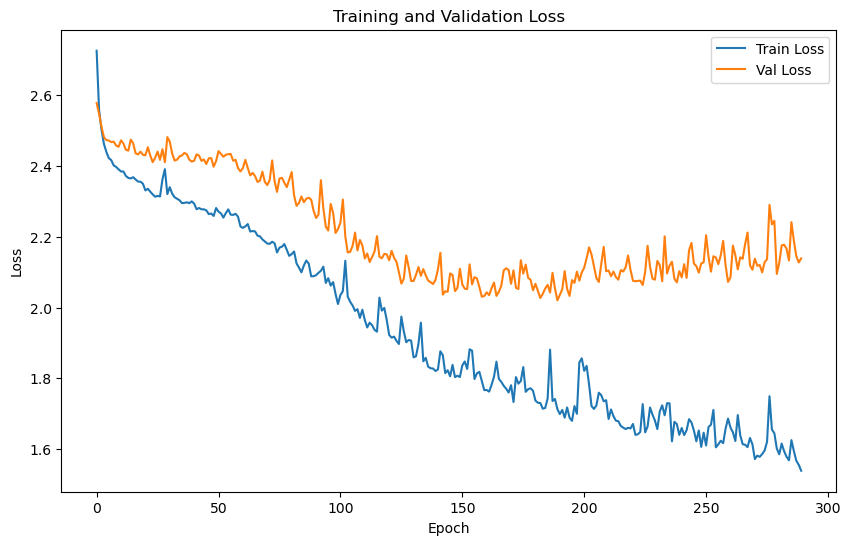

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.9114 | Test Accuracy: 38.03%


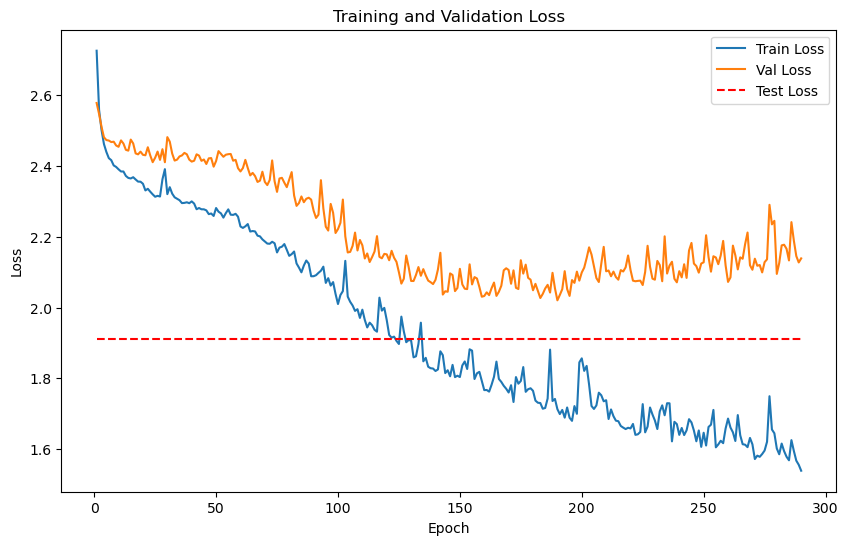

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)


Train embeddings shape: (260, 64), 
Train labels shape: (260,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4886, 64), 
Test labels shape: (4886,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.5662
Epoch [1/2000], Avg Train Loss: 8.5662
Epoch [1/2000], Avg Val Loss: 5.6535
Validation loss improved from inf to 5.6535. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.5013
Epoch [2/2000], Avg Train Loss: 8.5013
Epoch [2/2000], Avg Val Loss: 5.6249
Validation loss improved from 5.6535 to 5.6249. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.4023
Epoch [3/2000], Avg Train Loss: 8.4023
Epoch [3/2000], Avg Val Loss: 5.5969
Validation loss improved from 5.6249 to 5.5969. Saving model...

LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 8.4066
Epoch [4/2000], Avg Train Loss: 8.4066
Epoch [4/2000], Avg Val Loss: 5.5690
Validation loss improved from 5.5969 to 5.5690. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.1659
Epoch [5/2000], Avg Train Loss: 8.1659
Epoch [5/2000], Avg Val Loss: 5.5405
Validation loss improved from 5.5690 to 5.5405. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.1519
Epoch [6/2000], Avg Train Loss: 8.1519
Epoch [6/2000], Avg Val Loss: 5.5118
Validation loss improved from 5.5405 to 5.5118. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 8.0504
Epoch [7/2000], Avg Train Loss: 8.0504
Epoch [7/2000], Avg Val Loss: 5.4827
Validation loss improved from 5.5118 to 5.4827. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 8.0027
Epoch [8/2000], Avg Train Loss: 8.0027
Epoch [8/2000], Avg Val Loss: 5.4529
Validation loss improved from 5.4827 to 5.4529. Saving m

Epoch [17/2000], Avg Val Loss: 5.1820
Validation loss improved from 5.2126 to 5.1820. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.4221
Epoch [18/2000], Avg Train Loss: 7.4221
Epoch [18/2000], Avg Val Loss: 5.1513
Validation loss improved from 5.1820 to 5.1513. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.4170
Epoch [19/2000], Avg Train Loss: 7.4170
Epoch [19/2000], Avg Val Loss: 5.1210
Validation loss improved from 5.1513 to 5.1210. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.3630
Epoch [20/2000], Avg Train Loss: 7.3630
Epoch [20/2000], Avg Val Loss: 5.0906
Validation loss improved from 5.1210 to 5.0906. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.2036
Epoch [21/2000], Avg Train Loss: 7.2036
Epoch [21/2000], Avg Val Loss: 5.0602
Validation loss improved from 5.0906 to 5.0602. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 7.0578
Epoch [26/2000], Avg Train Loss: 7.0578
Epoch [26/2000], Avg Val Loss: 4.9090
Validation loss improved from 4.9389 to 4.9090. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.0526
Epoch [27/2000], Avg Train Loss: 7.0526
Epoch [27/2000], Avg Val Loss: 4.8795
Validation loss improved from 4.9090 to 4.8795. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 7.0107
Epoch [28/2000], Avg Train Loss: 7.0107
Epoch [28/2000], Avg Val Loss: 4.8503
Validation loss improved from 4.8795 to 4.8503. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 6.9873
Epoch [29/2000], Avg Train Loss: 6.9873
Epoch [29/2000], Avg Val Loss: 4.8216
Validation loss improved from 4.8503 to 4.8216. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.8908
Epoch [30/2000], Avg Train Loss: 6.8908
Epoch [30/2000], Avg Val Loss: 4.7931
Validation loss improved from 4.8216 to 4.

Epoch [42/2000], Avg Val Loss: 4.4876
Validation loss improved from 4.5100 to 4.4876. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 6.4641
Epoch [43/2000], Avg Train Loss: 6.4641
Epoch [43/2000], Avg Val Loss: 4.4658
Validation loss improved from 4.4876 to 4.4658. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 6.5091
Epoch [44/2000], Avg Train Loss: 6.5091
Epoch [44/2000], Avg Val Loss: 4.4447
Validation loss improved from 4.4658 to 4.4447. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 6.4584
Epoch [45/2000], Avg Train Loss: 6.4584
Epoch [45/2000], Avg Val Loss: 4.4240
Validation loss improved from 4.4447 to 4.4240. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 6.4321
Epoch [46/2000], Avg Train Loss: 6.4321
Epoch [46/2000], Avg Val Loss: 4.4039
Validation loss improved from 4.4240 to 4.4039. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.1208
Epoch [56/2000], Avg Train Loss: 6.1208
Epoch [56/2000], Avg Val Loss: 4.2369
Validation loss improved from 4.2510 to 4.2369. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 6.1278
Epoch [57/2000], Avg Train Loss: 6.1278
Epoch [57/2000], Avg Val Loss: 4.2234
Validation loss improved from 4.2369 to 4.2234. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 6.1921
Epoch [58/2000], Avg Train Loss: 6.1921
Epoch [58/2000], Avg Val Loss: 4.2104
Validation loss improved from 4.2234 to 4.2104. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 6.1157
Epoch [59/2000], Avg Train Loss: 6.1157
Epoch [59/2000], Avg Val Loss: 4.1978
Validation loss improved from 4.2104 to 4.1978. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 6.0677
Epoch [60/2000], Avg Train Loss: 6.0677
Epoch [60/2000], Avg Val Loss: 4.1857
Validation loss improved from 4.1978 to 4.

    Batch [1/1], Train Loss: 5.9809
Epoch [68/2000], Avg Train Loss: 5.9809
Epoch [68/2000], Avg Val Loss: 4.1043
Validation loss improved from 4.1133 to 4.1043. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 5.9494
Epoch [69/2000], Avg Train Loss: 5.9494
Epoch [69/2000], Avg Val Loss: 4.0955
Validation loss improved from 4.1043 to 4.0955. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.9373
Epoch [70/2000], Avg Train Loss: 5.9373
Epoch [70/2000], Avg Val Loss: 4.0870
Validation loss improved from 4.0955 to 4.0870. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.9216
Epoch [71/2000], Avg Train Loss: 5.9216
Epoch [71/2000], Avg Val Loss: 4.0786
Validation loss improved from 4.0870 to 4.0786. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.9126
Epoch [72/2000], Avg Train Loss: 5.9126
Epoch [72/2000], Avg Val Loss: 4.0706
Validation loss improved from 4.0786 to 4.

    Batch [1/1], Train Loss: 5.8399
Epoch [82/2000], Avg Train Loss: 5.8399
Epoch [82/2000], Avg Val Loss: 4.0036
Validation loss improved from 4.0094 to 4.0036. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.7890
Epoch [83/2000], Avg Train Loss: 5.7890
Epoch [83/2000], Avg Val Loss: 3.9981
Validation loss improved from 4.0036 to 3.9981. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 5.7893
Epoch [84/2000], Avg Train Loss: 5.7893
Epoch [84/2000], Avg Val Loss: 3.9928
Validation loss improved from 3.9981 to 3.9928. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 5.7985
Epoch [85/2000], Avg Train Loss: 5.7985
Epoch [85/2000], Avg Val Loss: 3.9875
Validation loss improved from 3.9928 to 3.9875. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 5.7918
Epoch [86/2000], Avg Train Loss: 5.7918
Epoch [86/2000], Avg Val Loss: 3.9823
Validation loss improved from 3.9875 to 3.

    Batch [1/1], Train Loss: 5.7198
Epoch [92/2000], Avg Train Loss: 5.7198
Epoch [92/2000], Avg Val Loss: 3.9523
Validation loss improved from 3.9572 to 3.9523. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.7104
Epoch [93/2000], Avg Train Loss: 5.7104
Epoch [93/2000], Avg Val Loss: 3.9475
Validation loss improved from 3.9523 to 3.9475. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.7173
Epoch [94/2000], Avg Train Loss: 5.7173
Epoch [94/2000], Avg Val Loss: 3.9427
Validation loss improved from 3.9475 to 3.9427. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.7132
Epoch [95/2000], Avg Train Loss: 5.7132
Epoch [95/2000], Avg Val Loss: 3.9379
Validation loss improved from 3.9427 to 3.9379. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.7063
Epoch [96/2000], Avg Train Loss: 5.7063
Epoch [96/2000], Avg Val Loss: 3.9331
Validation loss improved from 3.9379 to 3.

    Batch [1/1], Train Loss: 5.6653
Epoch [102/2000], Avg Train Loss: 5.6653
Epoch [102/2000], Avg Val Loss: 3.9058
Validation loss improved from 3.9101 to 3.9058. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 5.6368
Epoch [103/2000], Avg Train Loss: 5.6368
Epoch [103/2000], Avg Val Loss: 3.9015
Validation loss improved from 3.9058 to 3.9015. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 5.6957
Epoch [104/2000], Avg Train Loss: 5.6957
Epoch [104/2000], Avg Val Loss: 3.8974
Validation loss improved from 3.9015 to 3.8974. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 5.6531
Epoch [105/2000], Avg Train Loss: 5.6531
Epoch [105/2000], Avg Val Loss: 3.8932
Validation loss improved from 3.8974 to 3.8932. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 5.6563
Epoch [106/2000], Avg Train Loss: 5.6563
Epoch [106/2000], Avg Val Loss: 3.8892
Validation loss improved fro

    Batch [1/1], Train Loss: 5.5749
Epoch [121/2000], Avg Train Loss: 5.5749
Epoch [121/2000], Avg Val Loss: 3.8339
Validation loss improved from 3.8373 to 3.8339. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 5.5495
Epoch [122/2000], Avg Train Loss: 5.5495
Epoch [122/2000], Avg Val Loss: 3.8305
Validation loss improved from 3.8339 to 3.8305. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 5.5334
Epoch [123/2000], Avg Train Loss: 5.5334
Epoch [123/2000], Avg Val Loss: 3.8271
Validation loss improved from 3.8305 to 3.8271. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 5.5421
Epoch [124/2000], Avg Train Loss: 5.5421
Epoch [124/2000], Avg Val Loss: 3.8238
Validation loss improved from 3.8271 to 3.8238. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 5.5389
Epoch [125/2000], Avg Train Loss: 5.5389
Epoch [125/2000], Avg Val Loss: 3.8205
Validation loss improved fro

    Batch [1/1], Train Loss: 5.5162
Epoch [132/2000], Avg Train Loss: 5.5162
Epoch [132/2000], Avg Val Loss: 3.7981
Validation loss improved from 3.8012 to 3.7981. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 5.5302
Epoch [133/2000], Avg Train Loss: 5.5302
Epoch [133/2000], Avg Val Loss: 3.7950
Validation loss improved from 3.7981 to 3.7950. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 5.4989
Epoch [134/2000], Avg Train Loss: 5.4989
Epoch [134/2000], Avg Val Loss: 3.7919
Validation loss improved from 3.7950 to 3.7919. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 5.4880
Epoch [135/2000], Avg Train Loss: 5.4880
Epoch [135/2000], Avg Val Loss: 3.7889
Validation loss improved from 3.7919 to 3.7889. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 5.5181
Epoch [136/2000], Avg Train Loss: 5.5181
Epoch [136/2000], Avg Val Loss: 3.7858
Validation loss improved fro

    Batch [1/1], Train Loss: 5.4816
Epoch [140/2000], Avg Train Loss: 5.4816
Epoch [140/2000], Avg Val Loss: 3.7739
Validation loss improved from 3.7768 to 3.7739. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 5.5138
Epoch [141/2000], Avg Train Loss: 5.5138
Epoch [141/2000], Avg Val Loss: 3.7711
Validation loss improved from 3.7739 to 3.7711. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 5.5042
Epoch [142/2000], Avg Train Loss: 5.5042
Epoch [142/2000], Avg Val Loss: 3.7683
Validation loss improved from 3.7711 to 3.7683. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 5.4775
Epoch [143/2000], Avg Train Loss: 5.4775
Epoch [143/2000], Avg Val Loss: 3.7655
Validation loss improved from 3.7683 to 3.7655. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 5.4878
Epoch [144/2000], Avg Train Loss: 5.4878
Epoch [144/2000], Avg Val Loss: 3.7628
Validation loss improved fro

    Batch [1/1], Train Loss: 5.4216
Epoch [157/2000], Avg Train Loss: 5.4216
Epoch [157/2000], Avg Val Loss: 3.7305
Validation loss improved from 3.7328 to 3.7305. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 5.4210
Epoch [158/2000], Avg Train Loss: 5.4210
Epoch [158/2000], Avg Val Loss: 3.7281
Validation loss improved from 3.7305 to 3.7281. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 5.4313
Epoch [159/2000], Avg Train Loss: 5.4313
Epoch [159/2000], Avg Val Loss: 3.7258
Validation loss improved from 3.7281 to 3.7258. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 5.4460
Epoch [160/2000], Avg Train Loss: 5.4460
Epoch [160/2000], Avg Val Loss: 3.7237
Validation loss improved from 3.7258 to 3.7237. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 5.4019
Epoch [161/2000], Avg Train Loss: 5.4019
Epoch [161/2000], Avg Val Loss: 3.7215
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3993
Epoch [168/2000], Avg Train Loss: 5.3993
Epoch [168/2000], Avg Val Loss: 3.7081
Validation loss improved from 3.7098 to 3.7081. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 5.3926
Epoch [169/2000], Avg Train Loss: 5.3926
Epoch [169/2000], Avg Val Loss: 3.7064
Validation loss improved from 3.7081 to 3.7064. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 5.4230
Epoch [170/2000], Avg Train Loss: 5.4230
Epoch [170/2000], Avg Val Loss: 3.7048
Validation loss improved from 3.7064 to 3.7048. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 5.3998
Epoch [171/2000], Avg Train Loss: 5.3998
Epoch [171/2000], Avg Val Loss: 3.7032
Validation loss improved from 3.7048 to 3.7032. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 5.4028
Epoch [172/2000], Avg Train Loss: 5.4028
Epoch [172/2000], Avg Val Loss: 3.7017
Validation loss improved fro

Epoch [175/2000], Avg Val Loss: 3.6973
Validation loss improved from 3.6987 to 3.6973. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 5.3698
Epoch [176/2000], Avg Train Loss: 5.3698
Epoch [176/2000], Avg Val Loss: 3.6960
Validation loss improved from 3.6973 to 3.6960. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 5.3836
Epoch [177/2000], Avg Train Loss: 5.3836
Epoch [177/2000], Avg Val Loss: 3.6948
Validation loss improved from 3.6960 to 3.6948. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 5.3726
Epoch [178/2000], Avg Train Loss: 5.3726
Epoch [178/2000], Avg Val Loss: 3.6935
Validation loss improved from 3.6948 to 3.6935. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 5.3656
Epoch [179/2000], Avg Train Loss: 5.3656
Epoch [179/2000], Avg Val Loss: 3.6923
Validation loss improved from 3.6935 to 3.6923. Saving model...

LOG: Epoch [180/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.3073
Epoch [199/2000], Avg Train Loss: 5.3073
Epoch [199/2000], Avg Val Loss: 3.6712
Validation loss improved from 3.6722 to 3.6712. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 5.3341
Epoch [200/2000], Avg Train Loss: 5.3341
Epoch [200/2000], Avg Val Loss: 3.6701
Validation loss improved from 3.6712 to 3.6701. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 5.2910
Epoch [201/2000], Avg Train Loss: 5.2910
Epoch [201/2000], Avg Val Loss: 3.6691
Validation loss improved from 3.6701 to 3.6691. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 5.3596
Epoch [202/2000], Avg Train Loss: 5.3596
Epoch [202/2000], Avg Val Loss: 3.6682
Validation loss improved from 3.6691 to 3.6682. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 5.3250
Epoch [203/2000], Avg Train Loss: 5.3250
Epoch [203/2000], Avg Val Loss: 3.6673
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3293
Epoch [208/2000], Avg Train Loss: 5.3293
Epoch [208/2000], Avg Val Loss: 3.6630
Validation loss improved from 3.6638 to 3.6630. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 5.3314
Epoch [209/2000], Avg Train Loss: 5.3314
Epoch [209/2000], Avg Val Loss: 3.6621
Validation loss improved from 3.6630 to 3.6621. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 5.3328
Epoch [210/2000], Avg Train Loss: 5.3328
Epoch [210/2000], Avg Val Loss: 3.6613
Validation loss improved from 3.6621 to 3.6613. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 5.2851
Epoch [211/2000], Avg Train Loss: 5.2851
Epoch [211/2000], Avg Val Loss: 3.6605
Validation loss improved from 3.6613 to 3.6605. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 5.2619
Epoch [212/2000], Avg Train Loss: 5.2619
Epoch [212/2000], Avg Val Loss: 3.6597
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2625
Epoch [236/2000], Avg Train Loss: 5.2625
Epoch [236/2000], Avg Val Loss: 3.6417
Validation loss improved from 3.6424 to 3.6417. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 5.2188
Epoch [237/2000], Avg Train Loss: 5.2188
Epoch [237/2000], Avg Val Loss: 3.6411
Validation loss improved from 3.6417 to 3.6411. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 5.2535
Epoch [238/2000], Avg Train Loss: 5.2535
Epoch [238/2000], Avg Val Loss: 3.6405
Validation loss improved from 3.6411 to 3.6405. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 5.2618
Epoch [239/2000], Avg Train Loss: 5.2618
Epoch [239/2000], Avg Val Loss: 3.6399
Validation loss improved from 3.6405 to 3.6399. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 5.2653
Epoch [240/2000], Avg Train Loss: 5.2653
Epoch [240/2000], Avg Val Loss: 3.6393
Validation loss improved fro

Epoch [247/2000], Avg Val Loss: 3.6341
Validation loss improved from 3.6348 to 3.6341. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 5.2790
Epoch [248/2000], Avg Train Loss: 5.2790
Epoch [248/2000], Avg Val Loss: 3.6333
Validation loss improved from 3.6341 to 3.6333. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 5.2678
Epoch [249/2000], Avg Train Loss: 5.2678
Epoch [249/2000], Avg Val Loss: 3.6326
Validation loss improved from 3.6333 to 3.6326. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 5.1961
Epoch [250/2000], Avg Train Loss: 5.1961
Epoch [250/2000], Avg Val Loss: 3.6318
Validation loss improved from 3.6326 to 3.6318. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 5.2506
Epoch [251/2000], Avg Train Loss: 5.2506
Epoch [251/2000], Avg Val Loss: 3.6310
Validation loss improved from 3.6318 to 3.6310. Saving model...

LOG: Epoch [252/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.2301
Epoch [277/2000], Avg Train Loss: 5.2301
Epoch [277/2000], Avg Val Loss: 3.6142
Validation loss improved from 3.6150 to 3.6142. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 5.2122
Epoch [278/2000], Avg Train Loss: 5.2122
Epoch [278/2000], Avg Val Loss: 3.6134
Validation loss improved from 3.6142 to 3.6134. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 5.1866
Epoch [279/2000], Avg Train Loss: 5.1866
Epoch [279/2000], Avg Val Loss: 3.6126
Validation loss improved from 3.6134 to 3.6126. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 5.1937
Epoch [280/2000], Avg Train Loss: 5.1937
Epoch [280/2000], Avg Val Loss: 3.6119
Validation loss improved from 3.6126 to 3.6119. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 5.1841
Epoch [281/2000], Avg Train Loss: 5.1841
Epoch [281/2000], Avg Val Loss: 3.6111
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2158
Epoch [285/2000], Avg Train Loss: 5.2158
Epoch [285/2000], Avg Val Loss: 3.6082
Validation loss improved from 3.6090 to 3.6082. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 5.1885
Epoch [286/2000], Avg Train Loss: 5.1885
Epoch [286/2000], Avg Val Loss: 3.6075
Validation loss improved from 3.6082 to 3.6075. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 5.1979
Epoch [287/2000], Avg Train Loss: 5.1979
Epoch [287/2000], Avg Val Loss: 3.6068
Validation loss improved from 3.6075 to 3.6068. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 5.2070
Epoch [288/2000], Avg Train Loss: 5.2070
Epoch [288/2000], Avg Val Loss: 3.6062
Validation loss improved from 3.6068 to 3.6062. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 5.1872
Epoch [289/2000], Avg Train Loss: 5.1872
Epoch [289/2000], Avg Val Loss: 3.6056
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1819
Epoch [315/2000], Avg Train Loss: 5.1819
Epoch [315/2000], Avg Val Loss: 3.5925
Validation loss improved from 3.5930 to 3.5925. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 5.1475
Epoch [316/2000], Avg Train Loss: 5.1475
Epoch [316/2000], Avg Val Loss: 3.5921
Validation loss improved from 3.5925 to 3.5921. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 5.1730
Epoch [317/2000], Avg Train Loss: 5.1730
Epoch [317/2000], Avg Val Loss: 3.5917
Validation loss improved from 3.5921 to 3.5917. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 5.1383
Epoch [318/2000], Avg Train Loss: 5.1383
Epoch [318/2000], Avg Val Loss: 3.5912
Validation loss improved from 3.5917 to 3.5912. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 5.1599
Epoch [319/2000], Avg Train Loss: 5.1599
Epoch [319/2000], Avg Val Loss: 3.5908
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1548
Epoch [327/2000], Avg Train Loss: 5.1548
Epoch [327/2000], Avg Val Loss: 3.5876
Validation loss improved from 3.5880 to 3.5876. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 5.1388
Epoch [328/2000], Avg Train Loss: 5.1388
Epoch [328/2000], Avg Val Loss: 3.5870
Validation loss improved from 3.5876 to 3.5870. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 5.1830
Epoch [329/2000], Avg Train Loss: 5.1830
Epoch [329/2000], Avg Val Loss: 3.5864
Validation loss improved from 3.5870 to 3.5864. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 5.1536
Epoch [330/2000], Avg Train Loss: 5.1536
Epoch [330/2000], Avg Val Loss: 3.5859
Validation loss improved from 3.5864 to 3.5859. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 5.1727
Epoch [331/2000], Avg Train Loss: 5.1727
Epoch [331/2000], Avg Val Loss: 3.5853
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1329
Epoch [352/2000], Avg Train Loss: 5.1329
Epoch [352/2000], Avg Val Loss: 3.5725
Validation loss improved from 3.5732 to 3.5725. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 5.1617
Epoch [353/2000], Avg Train Loss: 5.1617
Epoch [353/2000], Avg Val Loss: 3.5719
Validation loss improved from 3.5725 to 3.5719. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 5.1472
Epoch [354/2000], Avg Train Loss: 5.1472
Epoch [354/2000], Avg Val Loss: 3.5712
Validation loss improved from 3.5719 to 3.5712. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 5.1496
Epoch [355/2000], Avg Train Loss: 5.1496
Epoch [355/2000], Avg Val Loss: 3.5707
Validation loss improved from 3.5712 to 3.5707. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 5.1178
Epoch [356/2000], Avg Train Loss: 5.1178
Epoch [356/2000], Avg Val Loss: 3.5700
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1273
Epoch [362/2000], Avg Train Loss: 5.1273
Epoch [362/2000], Avg Val Loss: 3.5663
Validation loss improved from 3.5669 to 3.5663. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 5.1150
Epoch [363/2000], Avg Train Loss: 5.1150
Epoch [363/2000], Avg Val Loss: 3.5657
Validation loss improved from 3.5663 to 3.5657. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 5.1224
Epoch [364/2000], Avg Train Loss: 5.1224
Epoch [364/2000], Avg Val Loss: 3.5652
Validation loss improved from 3.5657 to 3.5652. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 5.1318
Epoch [365/2000], Avg Train Loss: 5.1318
Epoch [365/2000], Avg Val Loss: 3.5647
Validation loss improved from 3.5652 to 3.5647. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 5.1106
Epoch [366/2000], Avg Train Loss: 5.1106
Epoch [366/2000], Avg Val Loss: 3.5641
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0935
Epoch [391/2000], Avg Train Loss: 5.0935
Epoch [391/2000], Avg Val Loss: 3.5527
Validation loss improved from 3.5535 to 3.5527. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 5.1002
Epoch [392/2000], Avg Train Loss: 5.1002
Epoch [392/2000], Avg Val Loss: 3.5520
Validation loss improved from 3.5527 to 3.5520. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 5.1250
Epoch [393/2000], Avg Train Loss: 5.1250
Epoch [393/2000], Avg Val Loss: 3.5513
Validation loss improved from 3.5520 to 3.5513. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 5.1473
Epoch [394/2000], Avg Train Loss: 5.1473
Epoch [394/2000], Avg Val Loss: 3.5505
Validation loss improved from 3.5513 to 3.5505. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 5.1179
Epoch [395/2000], Avg Train Loss: 5.1179
Epoch [395/2000], Avg Val Loss: 3.5498
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0703
Epoch [406/2000], Avg Train Loss: 5.0703
Epoch [406/2000], Avg Val Loss: 3.5407
Validation loss improved from 3.5415 to 3.5407. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 5.0928
Epoch [407/2000], Avg Train Loss: 5.0928
Epoch [407/2000], Avg Val Loss: 3.5399
Validation loss improved from 3.5407 to 3.5399. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 5.0889
Epoch [408/2000], Avg Train Loss: 5.0889
Epoch [408/2000], Avg Val Loss: 3.5391
Validation loss improved from 3.5399 to 3.5391. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 5.0942
Epoch [409/2000], Avg Train Loss: 5.0942
Epoch [409/2000], Avg Val Loss: 3.5383
Validation loss improved from 3.5391 to 3.5383. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 5.0740
Epoch [410/2000], Avg Train Loss: 5.0740
Epoch [410/2000], Avg Val Loss: 3.5375
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0616
Epoch [431/2000], Avg Train Loss: 5.0616
Epoch [431/2000], Avg Val Loss: 3.5245
Validation loss improved from 3.5252 to 3.5245. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 5.0583
Epoch [432/2000], Avg Train Loss: 5.0583
Epoch [432/2000], Avg Val Loss: 3.5239
Validation loss improved from 3.5245 to 3.5239. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 5.0459
Epoch [433/2000], Avg Train Loss: 5.0459
Epoch [433/2000], Avg Val Loss: 3.5232
Validation loss improved from 3.5239 to 3.5232. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 5.0694
Epoch [434/2000], Avg Train Loss: 5.0694
Epoch [434/2000], Avg Val Loss: 3.5225
Validation loss improved from 3.5232 to 3.5225. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 5.0595
Epoch [435/2000], Avg Train Loss: 5.0595
Epoch [435/2000], Avg Val Loss: 3.5219
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0506
Epoch [444/2000], Avg Train Loss: 5.0506
Epoch [444/2000], Avg Val Loss: 3.5169
Validation loss improved from 3.5173 to 3.5169. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 5.0774
Epoch [445/2000], Avg Train Loss: 5.0774
Epoch [445/2000], Avg Val Loss: 3.5163
Validation loss improved from 3.5169 to 3.5163. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 5.0815
Epoch [446/2000], Avg Train Loss: 5.0815
Epoch [446/2000], Avg Val Loss: 3.5158
Validation loss improved from 3.5163 to 3.5158. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 5.0697
Epoch [447/2000], Avg Train Loss: 5.0697
Epoch [447/2000], Avg Val Loss: 3.5152
Validation loss improved from 3.5158 to 3.5152. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 5.0561
Epoch [448/2000], Avg Train Loss: 5.0561
Epoch [448/2000], Avg Val Loss: 3.5147
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0283
Epoch [471/2000], Avg Train Loss: 5.0283
Epoch [471/2000], Avg Val Loss: 3.4980
Validation loss improved from 3.4985 to 3.4980. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 5.0695
Epoch [472/2000], Avg Train Loss: 5.0695
Epoch [472/2000], Avg Val Loss: 3.4976
Validation loss improved from 3.4980 to 3.4976. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 5.0289
Epoch [473/2000], Avg Train Loss: 5.0289
Epoch [473/2000], Avg Val Loss: 3.4972
Validation loss improved from 3.4976 to 3.4972. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 5.0413
Epoch [474/2000], Avg Train Loss: 5.0413
Epoch [474/2000], Avg Val Loss: 3.4970
Validation loss improved from 3.4972 to 3.4970. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 5.0377
Epoch [475/2000], Avg Train Loss: 5.0377
Epoch [475/2000], Avg Val Loss: 3.4968
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0460
Epoch [482/2000], Avg Train Loss: 5.0460
Epoch [482/2000], Avg Val Loss: 3.4954
Validation loss improved from 3.4956 to 3.4954. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 5.0269
Epoch [483/2000], Avg Train Loss: 5.0269
Epoch [483/2000], Avg Val Loss: 3.4951
Validation loss improved from 3.4954 to 3.4951. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 5.0135
Epoch [484/2000], Avg Train Loss: 5.0135
Epoch [484/2000], Avg Val Loss: 3.4947
Validation loss improved from 3.4951 to 3.4947. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 5.0433
Epoch [485/2000], Avg Train Loss: 5.0433
Epoch [485/2000], Avg Val Loss: 3.4943
Validation loss improved from 3.4947 to 3.4943. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 5.0249
Epoch [486/2000], Avg Train Loss: 5.0249
Epoch [486/2000], Avg Val Loss: 3.4940
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9975
Epoch [508/2000], Avg Train Loss: 4.9975
Epoch [508/2000], Avg Val Loss: 3.4829
Validation loss improved from 3.4833 to 3.4829. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 5.0360
Epoch [509/2000], Avg Train Loss: 5.0360
Epoch [509/2000], Avg Val Loss: 3.4824
Validation loss improved from 3.4829 to 3.4824. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 5.0206
Epoch [510/2000], Avg Train Loss: 5.0206
Epoch [510/2000], Avg Val Loss: 3.4818
Validation loss improved from 3.4824 to 3.4818. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 5.0065
Epoch [511/2000], Avg Train Loss: 5.0065
Epoch [511/2000], Avg Val Loss: 3.4811
Validation loss improved from 3.4818 to 3.4811. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 5.0132
Epoch [512/2000], Avg Train Loss: 5.0132
Epoch [512/2000], Avg Val Loss: 3.4804
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9861
Epoch [518/2000], Avg Train Loss: 4.9861
Epoch [518/2000], Avg Val Loss: 3.4773
Validation loss improved from 3.4778 to 3.4773. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 5.0061
Epoch [519/2000], Avg Train Loss: 5.0061
Epoch [519/2000], Avg Val Loss: 3.4767
Validation loss improved from 3.4773 to 3.4767. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 4.9980
Epoch [520/2000], Avg Train Loss: 4.9980
Epoch [520/2000], Avg Val Loss: 3.4762
Validation loss improved from 3.4767 to 3.4762. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 4.9800
Epoch [521/2000], Avg Train Loss: 4.9800
Epoch [521/2000], Avg Val Loss: 3.4758
Validation loss improved from 3.4762 to 3.4758. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 5.0326
Epoch [522/2000], Avg Train Loss: 5.0326
Epoch [522/2000], Avg Val Loss: 3.4754
Validation loss improved fro

Epoch [547/2000], Avg Val Loss: 3.4620
Validation loss improved from 3.4626 to 3.4620. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 5.0187
Epoch [548/2000], Avg Train Loss: 5.0187
Epoch [548/2000], Avg Val Loss: 3.4615
Validation loss improved from 3.4620 to 3.4615. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 5.0028
Epoch [549/2000], Avg Train Loss: 5.0028
Epoch [549/2000], Avg Val Loss: 3.4610
Validation loss improved from 3.4615 to 3.4610. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 5.0012
Epoch [550/2000], Avg Train Loss: 5.0012
Epoch [550/2000], Avg Val Loss: 3.4606
Validation loss improved from 3.4610 to 3.4606. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 5.0052
Epoch [551/2000], Avg Train Loss: 5.0052
Epoch [551/2000], Avg Val Loss: 3.4602
Validation loss improved from 3.4606 to 3.4602. Saving model...

LOG: Epoch [552/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9876
Epoch [555/2000], Avg Train Loss: 4.9876
Epoch [555/2000], Avg Val Loss: 3.4590
Validation loss improved from 3.4592 to 3.4590. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 4.9872
Epoch [556/2000], Avg Train Loss: 4.9872
Epoch [556/2000], Avg Val Loss: 3.4588
Validation loss improved from 3.4590 to 3.4588. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 4.9828
Epoch [557/2000], Avg Train Loss: 4.9828
Epoch [557/2000], Avg Val Loss: 3.4585
Validation loss improved from 3.4588 to 3.4585. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 5.0095
Epoch [558/2000], Avg Train Loss: 5.0095
Epoch [558/2000], Avg Val Loss: 3.4583
Validation loss improved from 3.4585 to 3.4583. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 4.9691
Epoch [559/2000], Avg Train Loss: 4.9691
Epoch [559/2000], Avg Val Loss: 3.4580
Validation loss improved fro

Epoch [585/2000], Avg Train Loss: 4.9723
Epoch [585/2000], Avg Val Loss: 3.4451
Validation loss improved from 3.4457 to 3.4451. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 4.9308
Epoch [586/2000], Avg Train Loss: 4.9308
Epoch [586/2000], Avg Val Loss: 3.4445
Validation loss improved from 3.4451 to 3.4445. Saving model...

LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 4.9427
Epoch [587/2000], Avg Train Loss: 4.9427
Epoch [587/2000], Avg Val Loss: 3.4439
Validation loss improved from 3.4445 to 3.4439. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 4.9738
Epoch [588/2000], Avg Train Loss: 4.9738
Epoch [588/2000], Avg Val Loss: 3.4435
Validation loss improved from 3.4439 to 3.4435. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 4.9313
Epoch [589/2000], Avg Train Loss: 4.9313
Epoch [589/2000], Avg Val Loss: 3.4430
Validation loss improved from 3.4435 to 3.4430. Saving model...


    Batch [1/1], Train Loss: 4.9342
Epoch [597/2000], Avg Train Loss: 4.9342
Epoch [597/2000], Avg Val Loss: 3.4398
Validation loss improved from 3.4400 to 3.4398. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 4.9493
Epoch [598/2000], Avg Train Loss: 4.9493
Epoch [598/2000], Avg Val Loss: 3.4395
Validation loss improved from 3.4398 to 3.4395. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 4.9784
Epoch [599/2000], Avg Train Loss: 4.9784
Epoch [599/2000], Avg Val Loss: 3.4391
Validation loss improved from 3.4395 to 3.4391. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 4.9614
Epoch [600/2000], Avg Train Loss: 4.9614
Epoch [600/2000], Avg Val Loss: 3.4388
Validation loss improved from 3.4391 to 3.4388. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 4.9376
Epoch [601/2000], Avg Train Loss: 4.9376
Epoch [601/2000], Avg Val Loss: 3.4383
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9540
Epoch [623/2000], Avg Train Loss: 4.9540
Epoch [623/2000], Avg Val Loss: 3.4315
Validation loss improved from 3.4317 to 3.4315. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 4.9379
Epoch [624/2000], Avg Train Loss: 4.9379
Epoch [624/2000], Avg Val Loss: 3.4312
Validation loss improved from 3.4315 to 3.4312. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 4.9073
Epoch [625/2000], Avg Train Loss: 4.9073
Epoch [625/2000], Avg Val Loss: 3.4308
Validation loss improved from 3.4312 to 3.4308. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 4.9356
Epoch [626/2000], Avg Train Loss: 4.9356
Epoch [626/2000], Avg Val Loss: 3.4304
Validation loss improved from 3.4308 to 3.4304. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 4.9462
Epoch [627/2000], Avg Train Loss: 4.9462
Epoch [627/2000], Avg Val Loss: 3.4301
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9569
Epoch [635/2000], Avg Train Loss: 4.9569
Epoch [635/2000], Avg Val Loss: 3.4257
Validation loss improved from 3.4264 to 3.4257. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 4.9862
Epoch [636/2000], Avg Train Loss: 4.9862
Epoch [636/2000], Avg Val Loss: 3.4253
Validation loss improved from 3.4257 to 3.4253. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 4.9063
Epoch [637/2000], Avg Train Loss: 4.9063
Epoch [637/2000], Avg Val Loss: 3.4250
Validation loss improved from 3.4253 to 3.4250. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 4.9613
Epoch [638/2000], Avg Train Loss: 4.9613
Epoch [638/2000], Avg Val Loss: 3.4246
Validation loss improved from 3.4250 to 3.4246. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 4.9356
Epoch [639/2000], Avg Train Loss: 4.9356
Epoch [639/2000], Avg Val Loss: 3.4243
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9044
Epoch [663/2000], Avg Train Loss: 4.9044
Epoch [663/2000], Avg Val Loss: 3.4173
Validation loss improved from 3.4174 to 3.4173. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 4.9005
Epoch [664/2000], Avg Train Loss: 4.9005
Epoch [664/2000], Avg Val Loss: 3.4172
Validation loss improved from 3.4173 to 3.4172. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 4.9226
Epoch [665/2000], Avg Train Loss: 4.9226
Epoch [665/2000], Avg Val Loss: 3.4170
Validation loss improved from 3.4172 to 3.4170. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 4.9083
Epoch [666/2000], Avg Train Loss: 4.9083
Epoch [666/2000], Avg Val Loss: 3.4170
Validation loss improved from 3.4170 to 3.4170. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 4.9127
Epoch [667/2000], Avg Train Loss: 4.9127
Epoch [667/2000], Avg Val Loss: 3.4169
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8977
Epoch [676/2000], Avg Train Loss: 4.8977
Epoch [676/2000], Avg Val Loss: 3.4153
Validation loss improved from 3.4155 to 3.4153. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 4.9070
Epoch [677/2000], Avg Train Loss: 4.9070
Epoch [677/2000], Avg Val Loss: 3.4151
Validation loss improved from 3.4153 to 3.4151. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 4.9011
Epoch [678/2000], Avg Train Loss: 4.9011
Epoch [678/2000], Avg Val Loss: 3.4146
Validation loss improved from 3.4151 to 3.4146. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 4.9287
Epoch [679/2000], Avg Train Loss: 4.9287
Epoch [679/2000], Avg Val Loss: 3.4142
Validation loss improved from 3.4146 to 3.4142. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 4.9272
Epoch [680/2000], Avg Train Loss: 4.9272
Epoch [680/2000], Avg Val Loss: 3.4138
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9179
Epoch [699/2000], Avg Train Loss: 4.9179
Epoch [699/2000], Avg Val Loss: 3.4096
Validation loss improved from 3.4100 to 3.4096. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 4.8985
Epoch [700/2000], Avg Train Loss: 4.8985
Epoch [700/2000], Avg Val Loss: 3.4091
Validation loss improved from 3.4096 to 3.4091. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 4.8920
Epoch [701/2000], Avg Train Loss: 4.8920
Epoch [701/2000], Avg Val Loss: 3.4088
Validation loss improved from 3.4091 to 3.4088. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 4.9100
Epoch [702/2000], Avg Train Loss: 4.9100
Epoch [702/2000], Avg Val Loss: 3.4085
Validation loss improved from 3.4088 to 3.4085. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 4.9092
Epoch [703/2000], Avg Train Loss: 4.9092
Epoch [703/2000], Avg Val Loss: 3.4080
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8992
Epoch [713/2000], Avg Train Loss: 4.8992
Epoch [713/2000], Avg Val Loss: 3.4027
Validation loss improved from 3.4030 to 3.4027. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 4.8850
Epoch [714/2000], Avg Train Loss: 4.8850
Epoch [714/2000], Avg Val Loss: 3.4024
Validation loss improved from 3.4027 to 3.4024. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 4.8737
Epoch [715/2000], Avg Train Loss: 4.8737
Epoch [715/2000], Avg Val Loss: 3.4020
Validation loss improved from 3.4024 to 3.4020. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 4.9253
Epoch [716/2000], Avg Train Loss: 4.9253
Epoch [716/2000], Avg Val Loss: 3.4017
Validation loss improved from 3.4020 to 3.4017. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 4.9017
Epoch [717/2000], Avg Train Loss: 4.9017
Epoch [717/2000], Avg Val Loss: 3.4013
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9070
Epoch [739/2000], Avg Train Loss: 4.9070
Epoch [739/2000], Avg Val Loss: 3.3944
Validation loss improved from 3.3947 to 3.3944. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 4.8628
Epoch [740/2000], Avg Train Loss: 4.8628
Epoch [740/2000], Avg Val Loss: 3.3941
Validation loss improved from 3.3944 to 3.3941. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 4.8588
Epoch [741/2000], Avg Train Loss: 4.8588
Epoch [741/2000], Avg Val Loss: 3.3937
Validation loss improved from 3.3941 to 3.3937. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 4.8648
Epoch [742/2000], Avg Train Loss: 4.8648
Epoch [742/2000], Avg Val Loss: 3.3934
Validation loss improved from 3.3937 to 3.3934. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 4.8825
Epoch [743/2000], Avg Train Loss: 4.8825
Epoch [743/2000], Avg Val Loss: 3.3932
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8570
Epoch [755/2000], Avg Train Loss: 4.8570
Epoch [755/2000], Avg Val Loss: 3.3944
Validation loss did not improve. Patience: 10/100

LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 4.8614
Epoch [756/2000], Avg Train Loss: 4.8614
Epoch [756/2000], Avg Val Loss: 3.3946
Validation loss did not improve. Patience: 11/100

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 4.8640
Epoch [757/2000], Avg Train Loss: 4.8640
Epoch [757/2000], Avg Val Loss: 3.3947
Validation loss did not improve. Patience: 12/100

LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 4.8904
Epoch [758/2000], Avg Train Loss: 4.8904
Epoch [758/2000], Avg Val Loss: 3.3947
Validation loss did not improve. Patience: 13/100

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 4.8843
Epoch [759/2000], Avg Train Loss: 4.8843
Epoch [759/2000], Avg Val Loss: 3.3946
Validation loss did not improve. Patience: 14/100

LOG: Epoch [760/2000] - Training


Epoch [776/2000], Avg Val Loss: 3.3867
Validation loss improved from 3.3872 to 3.3867. Saving model...

LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 4.8530
Epoch [777/2000], Avg Train Loss: 4.8530
Epoch [777/2000], Avg Val Loss: 3.3864
Validation loss improved from 3.3867 to 3.3864. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 4.8833
Epoch [778/2000], Avg Train Loss: 4.8833
Epoch [778/2000], Avg Val Loss: 3.3860
Validation loss improved from 3.3864 to 3.3860. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 4.8807
Epoch [779/2000], Avg Train Loss: 4.8807
Epoch [779/2000], Avg Val Loss: 3.3857
Validation loss improved from 3.3860 to 3.3857. Saving model...

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 4.8735
Epoch [780/2000], Avg Train Loss: 4.8735
Epoch [780/2000], Avg Val Loss: 3.3855
Validation loss improved from 3.3857 to 3.3855. Saving model...

LOG: Epoch [781/2000] - Training
    Bat

Epoch [792/2000], Avg Val Loss: 3.3863
Validation loss did not improve. Patience: 9/100

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 4.9011
Epoch [793/2000], Avg Train Loss: 4.9011
Epoch [793/2000], Avg Val Loss: 3.3862
Validation loss did not improve. Patience: 10/100

LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 4.8666
Epoch [794/2000], Avg Train Loss: 4.8666
Epoch [794/2000], Avg Val Loss: 3.3860
Validation loss did not improve. Patience: 11/100

LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 4.8891
Epoch [795/2000], Avg Train Loss: 4.8891
Epoch [795/2000], Avg Val Loss: 3.3858
Validation loss did not improve. Patience: 12/100

LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 4.8496
Epoch [796/2000], Avg Train Loss: 4.8496
Epoch [796/2000], Avg Val Loss: 3.3855
Validation loss did not improve. Patience: 13/100

LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 4.8399
Epoch [797/2000], Avg Train Loss: 4.8399
E

    Batch [1/1], Train Loss: 4.8580
Epoch [817/2000], Avg Train Loss: 4.8580
Epoch [817/2000], Avg Val Loss: 3.3777
Validation loss improved from 3.3780 to 3.3777. Saving model...

LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 4.8484
Epoch [818/2000], Avg Train Loss: 4.8484
Epoch [818/2000], Avg Val Loss: 3.3773
Validation loss improved from 3.3777 to 3.3773. Saving model...

LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 4.8462
Epoch [819/2000], Avg Train Loss: 4.8462
Epoch [819/2000], Avg Val Loss: 3.3767
Validation loss improved from 3.3773 to 3.3767. Saving model...

LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 4.8411
Epoch [820/2000], Avg Train Loss: 4.8411
Epoch [820/2000], Avg Val Loss: 3.3763
Validation loss improved from 3.3767 to 3.3763. Saving model...

LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 4.8640
Epoch [821/2000], Avg Train Loss: 4.8640
Epoch [821/2000], Avg Val Loss: 3.3759
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8448
Epoch [831/2000], Avg Train Loss: 4.8448
Epoch [831/2000], Avg Val Loss: 3.3756
Validation loss did not improve. Patience: 7/100

LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 4.8774
Epoch [832/2000], Avg Train Loss: 4.8774
Epoch [832/2000], Avg Val Loss: 3.3757
Validation loss did not improve. Patience: 8/100

LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 4.8602
Epoch [833/2000], Avg Train Loss: 4.8602
Epoch [833/2000], Avg Val Loss: 3.3758
Validation loss did not improve. Patience: 9/100

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 4.8277
Epoch [834/2000], Avg Train Loss: 4.8277
Epoch [834/2000], Avg Val Loss: 3.3760
Validation loss did not improve. Patience: 10/100

LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 4.8713
Epoch [835/2000], Avg Train Loss: 4.8713
Epoch [835/2000], Avg Val Loss: 3.3760
Validation loss did not improve. Patience: 11/100

LOG: Epoch [836/2000] - Training
   

Epoch [853/2000], Avg Val Loss: 3.3749
Validation loss did not improve. Patience: 3/100

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 4.8536
Epoch [854/2000], Avg Train Loss: 4.8536
Epoch [854/2000], Avg Val Loss: 3.3751
Validation loss did not improve. Patience: 4/100

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 4.8057
Epoch [855/2000], Avg Train Loss: 4.8057
Epoch [855/2000], Avg Val Loss: 3.3751
Validation loss did not improve. Patience: 5/100

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 4.8271
Epoch [856/2000], Avg Train Loss: 4.8271
Epoch [856/2000], Avg Val Loss: 3.3750
Validation loss did not improve. Patience: 6/100

LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 4.8423
Epoch [857/2000], Avg Train Loss: 4.8423
Epoch [857/2000], Avg Val Loss: 3.3750
Validation loss did not improve. Patience: 7/100

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 4.8350
Epoch [858/2000], Avg Train Loss: 4.8350
Epoch

    Batch [1/1], Train Loss: 4.8130
Epoch [871/2000], Avg Train Loss: 4.8130
Epoch [871/2000], Avg Val Loss: 3.3708
Validation loss improved from 3.3713 to 3.3708. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 4.7966
Epoch [872/2000], Avg Train Loss: 4.7966
Epoch [872/2000], Avg Val Loss: 3.3703
Validation loss improved from 3.3708 to 3.3703. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 4.8099
Epoch [873/2000], Avg Train Loss: 4.8099
Epoch [873/2000], Avg Val Loss: 3.3698
Validation loss improved from 3.3703 to 3.3698. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 4.8305
Epoch [874/2000], Avg Train Loss: 4.8305
Epoch [874/2000], Avg Val Loss: 3.3696
Validation loss improved from 3.3698 to 3.3696. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 4.8336
Epoch [875/2000], Avg Train Loss: 4.8336
Epoch [875/2000], Avg Val Loss: 3.3694
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8291
Epoch [894/2000], Avg Train Loss: 4.8291
Epoch [894/2000], Avg Val Loss: 3.3639
Validation loss improved from 3.3640 to 3.3639. Saving model...

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 4.8262
Epoch [895/2000], Avg Train Loss: 4.8262
Epoch [895/2000], Avg Val Loss: 3.3639
Validation loss improved from 3.3639 to 3.3639. Saving model...

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 4.8470
Epoch [896/2000], Avg Train Loss: 4.8470
Epoch [896/2000], Avg Val Loss: 3.3638
Validation loss improved from 3.3639 to 3.3638. Saving model...

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 4.8111
Epoch [897/2000], Avg Train Loss: 4.8111
Epoch [897/2000], Avg Val Loss: 3.3636
Validation loss improved from 3.3638 to 3.3636. Saving model...

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 4.8011
Epoch [898/2000], Avg Train Loss: 4.8011
Epoch [898/2000], Avg Val Loss: 3.3634
Validation loss improved fro

Epoch [909/2000], Avg Val Loss: 3.3630
Validation loss did not improve. Patience: 3/100

LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 4.8049
Epoch [910/2000], Avg Train Loss: 4.8049
Epoch [910/2000], Avg Val Loss: 3.3633
Validation loss did not improve. Patience: 4/100

LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 4.8133
Epoch [911/2000], Avg Train Loss: 4.8133
Epoch [911/2000], Avg Val Loss: 3.3636
Validation loss did not improve. Patience: 5/100

LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 4.8520
Epoch [912/2000], Avg Train Loss: 4.8520
Epoch [912/2000], Avg Val Loss: 3.3637
Validation loss did not improve. Patience: 6/100

LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 4.8318
Epoch [913/2000], Avg Train Loss: 4.8318
Epoch [913/2000], Avg Val Loss: 3.3637
Validation loss did not improve. Patience: 7/100

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 4.7855
Epoch [914/2000], Avg Train Loss: 4.7855
Epoch

    Batch [1/1], Train Loss: 4.8320
Epoch [931/2000], Avg Train Loss: 4.8320
Epoch [931/2000], Avg Val Loss: 3.3650
Validation loss did not improve. Patience: 25/100

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 4.8202
Epoch [932/2000], Avg Train Loss: 4.8202
Epoch [932/2000], Avg Val Loss: 3.3647
Validation loss did not improve. Patience: 26/100

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 4.8073
Epoch [933/2000], Avg Train Loss: 4.8073
Epoch [933/2000], Avg Val Loss: 3.3644
Validation loss did not improve. Patience: 27/100

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 4.8350
Epoch [934/2000], Avg Train Loss: 4.8350
Epoch [934/2000], Avg Val Loss: 3.3642
Validation loss did not improve. Patience: 28/100

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 4.7780
Epoch [935/2000], Avg Train Loss: 4.7780
Epoch [935/2000], Avg Val Loss: 3.3638
Validation loss did not improve. Patience: 29/100

LOG: Epoch [936/2000] - Training


Epoch [949/2000], Avg Val Loss: 3.3589
Validation loss improved from 3.3589 to 3.3589. Saving model...

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 4.7854
Epoch [950/2000], Avg Train Loss: 4.7854
Epoch [950/2000], Avg Val Loss: 3.3588
Validation loss improved from 3.3589 to 3.3588. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 4.7728
Epoch [951/2000], Avg Train Loss: 4.7728
Epoch [951/2000], Avg Val Loss: 3.3590
Validation loss did not improve. Patience: 1/100

LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 4.7920
Epoch [952/2000], Avg Train Loss: 4.7920
Epoch [952/2000], Avg Val Loss: 3.3590
Validation loss did not improve. Patience: 2/100

LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 4.7894
Epoch [953/2000], Avg Train Loss: 4.7894
Epoch [953/2000], Avg Val Loss: 3.3590
Validation loss did not improve. Patience: 3/100

LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 4.8303
Epoch [954/2000]

    Batch [1/1], Train Loss: 4.7840
Epoch [969/2000], Avg Train Loss: 4.7840
Epoch [969/2000], Avg Val Loss: 3.3564
Validation loss improved from 3.3568 to 3.3564. Saving model...

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 4.8064
Epoch [970/2000], Avg Train Loss: 4.8064
Epoch [970/2000], Avg Val Loss: 3.3558
Validation loss improved from 3.3564 to 3.3558. Saving model...

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 4.8089
Epoch [971/2000], Avg Train Loss: 4.8089
Epoch [971/2000], Avg Val Loss: 3.3552
Validation loss improved from 3.3558 to 3.3552. Saving model...

LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 4.7592
Epoch [972/2000], Avg Train Loss: 4.7592
Epoch [972/2000], Avg Val Loss: 3.3547
Validation loss improved from 3.3552 to 3.3547. Saving model...

LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 4.7868
Epoch [973/2000], Avg Train Loss: 4.7868
Epoch [973/2000], Avg Val Loss: 3.3543
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7974
Epoch [988/2000], Avg Train Loss: 4.7974
Epoch [988/2000], Avg Val Loss: 3.3547
Validation loss did not improve. Patience: 11/100

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 4.7976
Epoch [989/2000], Avg Train Loss: 4.7976
Epoch [989/2000], Avg Val Loss: 3.3550
Validation loss did not improve. Patience: 12/100

LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 4.8112
Epoch [990/2000], Avg Train Loss: 4.8112
Epoch [990/2000], Avg Val Loss: 3.3552
Validation loss did not improve. Patience: 13/100

LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 4.8236
Epoch [991/2000], Avg Train Loss: 4.8236
Epoch [991/2000], Avg Val Loss: 3.3554
Validation loss did not improve. Patience: 14/100

LOG: Epoch [992/2000] - Training
    Batch [1/1], Train Loss: 4.8220
Epoch [992/2000], Avg Train Loss: 4.8220
Epoch [992/2000], Avg Val Loss: 3.3555
Validation loss did not improve. Patience: 15/100

LOG: Epoch [993/2000] - Training


Epoch [1006/2000], Avg Val Loss: 3.3550
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 4.8156
Epoch [1007/2000], Avg Train Loss: 4.8156
Epoch [1007/2000], Avg Val Loss: 3.3548
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 4.7635
Epoch [1008/2000], Avg Train Loss: 4.7635
Epoch [1008/2000], Avg Val Loss: 3.3548
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 4.7831
Epoch [1009/2000], Avg Train Loss: 4.7831
Epoch [1009/2000], Avg Val Loss: 3.3546
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 4.7883
Epoch [1010/2000], Avg Train Loss: 4.7883
Epoch [1010/2000], Avg Val Loss: 3.3545
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 4.7976
Epoch [1011/2000], Avg Trai

Epoch [1028/2000], Avg Val Loss: 3.3468
Validation loss improved from 3.3468 to 3.3468. Saving model...

LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 4.7653
Epoch [1029/2000], Avg Train Loss: 4.7653
Epoch [1029/2000], Avg Val Loss: 3.3468
Validation loss improved from 3.3468 to 3.3468. Saving model...

LOG: Epoch [1030/2000] - Training
    Batch [1/1], Train Loss: 4.7380
Epoch [1030/2000], Avg Train Loss: 4.7380
Epoch [1030/2000], Avg Val Loss: 3.3467
Validation loss improved from 3.3468 to 3.3467. Saving model...

LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 4.7585
Epoch [1031/2000], Avg Train Loss: 4.7585
Epoch [1031/2000], Avg Val Loss: 3.3467
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 4.7573
Epoch [1032/2000], Avg Train Loss: 4.7573
Epoch [1032/2000], Avg Val Loss: 3.3466
Validation loss improved from 3.3467 to 3.3466. Saving model...

LOG: Epoch [1033/2000] - Training
    Batc

    Batch [1/1], Train Loss: 4.8043
Epoch [1038/2000], Avg Train Loss: 4.8043
Epoch [1038/2000], Avg Val Loss: 3.3472
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 4.7517
Epoch [1039/2000], Avg Train Loss: 4.7517
Epoch [1039/2000], Avg Val Loss: 3.3471
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1040/2000] - Training
    Batch [1/1], Train Loss: 4.7787
Epoch [1040/2000], Avg Train Loss: 4.7787
Epoch [1040/2000], Avg Val Loss: 3.3469
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 4.7647
Epoch [1041/2000], Avg Train Loss: 4.7647
Epoch [1041/2000], Avg Val Loss: 3.3468
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1042/2000] - Training
    Batch [1/1], Train Loss: 4.7793
Epoch [1042/2000], Avg Train Loss: 4.7793
Epoch [1042/2000], Avg Val Loss: 3.3467
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1043/2000] 

    Batch [1/1], Train Loss: 4.7762
Epoch [1050/2000], Avg Train Loss: 4.7762
Epoch [1050/2000], Avg Val Loss: 3.3444
Validation loss improved from 3.3448 to 3.3444. Saving model...

LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 4.7543
Epoch [1051/2000], Avg Train Loss: 4.7543
Epoch [1051/2000], Avg Val Loss: 3.3440
Validation loss improved from 3.3444 to 3.3440. Saving model...

LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 4.7799
Epoch [1052/2000], Avg Train Loss: 4.7799
Epoch [1052/2000], Avg Val Loss: 3.3437
Validation loss improved from 3.3440 to 3.3437. Saving model...

LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 4.7583
Epoch [1053/2000], Avg Train Loss: 4.7583
Epoch [1053/2000], Avg Val Loss: 3.3434
Validation loss improved from 3.3437 to 3.3434. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 4.7524
Epoch [1054/2000], Avg Train Loss: 4.7524
Epoch [1054/2000], Avg Val Loss: 3.3430
Validation los

    Batch [1/1], Train Loss: 4.7857
Epoch [1077/2000], Avg Train Loss: 4.7857
Epoch [1077/2000], Avg Val Loss: 3.3450
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 4.7569
Epoch [1078/2000], Avg Train Loss: 4.7569
Epoch [1078/2000], Avg Val Loss: 3.3449
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 4.7519
Epoch [1079/2000], Avg Train Loss: 4.7519
Epoch [1079/2000], Avg Val Loss: 3.3447
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 4.7359
Epoch [1080/2000], Avg Train Loss: 4.7359
Epoch [1080/2000], Avg Val Loss: 3.3445
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 4.7752
Epoch [1081/2000], Avg Train Loss: 4.7752
Epoch [1081/2000], Avg Val Loss: 3.3441
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1082/20

Epoch [1088/2000], Avg Val Loss: 3.3424
Validation loss improved from 3.3427 to 3.3424. Saving model...

LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 4.7490
Epoch [1089/2000], Avg Train Loss: 4.7490
Epoch [1089/2000], Avg Val Loss: 3.3422
Validation loss improved from 3.3424 to 3.3422. Saving model...

LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 4.7602
Epoch [1090/2000], Avg Train Loss: 4.7602
Epoch [1090/2000], Avg Val Loss: 3.3421
Validation loss improved from 3.3422 to 3.3421. Saving model...

LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 4.7342
Epoch [1091/2000], Avg Train Loss: 4.7342
Epoch [1091/2000], Avg Val Loss: 3.3419
Validation loss improved from 3.3421 to 3.3419. Saving model...

LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 4.7352
Epoch [1092/2000], Avg Train Loss: 4.7352
Epoch [1092/2000], Avg Val Loss: 3.3415
Validation loss improved from 3.3419 to 3.3415. Saving model...

LOG: Epoch [1093/2000] - Tr

Epoch [1116/2000], Avg Val Loss: 3.3319
Validation loss improved from 3.3323 to 3.3319. Saving model...

LOG: Epoch [1117/2000] - Training
    Batch [1/1], Train Loss: 4.7421
Epoch [1117/2000], Avg Train Loss: 4.7421
Epoch [1117/2000], Avg Val Loss: 3.3317
Validation loss improved from 3.3319 to 3.3317. Saving model...

LOG: Epoch [1118/2000] - Training
    Batch [1/1], Train Loss: 4.7212
Epoch [1118/2000], Avg Train Loss: 4.7212
Epoch [1118/2000], Avg Val Loss: 3.3317
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 4.7108
Epoch [1119/2000], Avg Train Loss: 4.7108
Epoch [1119/2000], Avg Val Loss: 3.3318
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1120/2000] - Training
    Batch [1/1], Train Loss: 4.7555
Epoch [1120/2000], Avg Train Loss: 4.7555
Epoch [1120/2000], Avg Val Loss: 3.3316
Validation loss improved from 3.3317 to 3.3316. Saving model...

LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train 

Epoch [1130/2000], Avg Val Loss: 3.3347
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 4.7383
Epoch [1131/2000], Avg Train Loss: 4.7383
Epoch [1131/2000], Avg Val Loss: 3.3348
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 4.7199
Epoch [1132/2000], Avg Train Loss: 4.7199
Epoch [1132/2000], Avg Val Loss: 3.3347
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 4.7489
Epoch [1133/2000], Avg Train Loss: 4.7489
Epoch [1133/2000], Avg Val Loss: 3.3345
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 4.7815
Epoch [1134/2000], Avg Train Loss: 4.7815
Epoch [1134/2000], Avg Val Loss: 3.3343
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1135/2000] - Training
    Batch [1/1], Train Loss: 4.7801
Epoch [1135/2000], Avg Trai

    Batch [1/1], Train Loss: 4.7125
Epoch [1156/2000], Avg Train Loss: 4.7125
Epoch [1156/2000], Avg Val Loss: 3.3335
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1157/2000] - Training
    Batch [1/1], Train Loss: 4.7513
Epoch [1157/2000], Avg Train Loss: 4.7513
Epoch [1157/2000], Avg Val Loss: 3.3336
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1158/2000] - Training
    Batch [1/1], Train Loss: 4.7460
Epoch [1158/2000], Avg Train Loss: 4.7460
Epoch [1158/2000], Avg Val Loss: 3.3336
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1159/2000] - Training
    Batch [1/1], Train Loss: 4.7274
Epoch [1159/2000], Avg Train Loss: 4.7274
Epoch [1159/2000], Avg Val Loss: 3.3338
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1160/2000] - Training
    Batch [1/1], Train Loss: 4.7280
Epoch [1160/2000], Avg Train Loss: 4.7280
Epoch [1160/2000], Avg Val Loss: 3.3338
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1161/20

    Batch [1/1], Train Loss: 4.7462
Epoch [1171/2000], Avg Train Loss: 4.7462
Epoch [1171/2000], Avg Val Loss: 3.3355
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 4.7403
Epoch [1172/2000], Avg Train Loss: 4.7403
Epoch [1172/2000], Avg Val Loss: 3.3360
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 4.7386
Epoch [1173/2000], Avg Train Loss: 4.7386
Epoch [1173/2000], Avg Val Loss: 3.3365
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 4.7059
Epoch [1174/2000], Avg Train Loss: 4.7059
Epoch [1174/2000], Avg Val Loss: 3.3369
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 4.7241
Epoch [1175/2000], Avg Train Loss: 4.7241
Epoch [1175/2000], Avg Val Loss: 3.3373
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1176/20

    Batch [1/1], Train Loss: 4.7156
Epoch [1195/2000], Avg Train Loss: 4.7156
Epoch [1195/2000], Avg Val Loss: 3.3333
Validation loss did not improve. Patience: 75/100

LOG: Epoch [1196/2000] - Training
    Batch [1/1], Train Loss: 4.7158
Epoch [1196/2000], Avg Train Loss: 4.7158
Epoch [1196/2000], Avg Val Loss: 3.3333
Validation loss did not improve. Patience: 76/100

LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 4.6986
Epoch [1197/2000], Avg Train Loss: 4.6986
Epoch [1197/2000], Avg Val Loss: 3.3329
Validation loss did not improve. Patience: 77/100

LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 4.6999
Epoch [1198/2000], Avg Train Loss: 4.6999
Epoch [1198/2000], Avg Val Loss: 3.3324
Validation loss did not improve. Patience: 78/100

LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 4.6909
Epoch [1199/2000], Avg Train Loss: 4.6909
Epoch [1199/2000], Avg Val Loss: 3.3321
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1200/20

    Batch [1/1], Train Loss: 4.7471
Epoch [1211/2000], Avg Train Loss: 4.7471
Epoch [1211/2000], Avg Val Loss: 3.3308
Validation loss improved from 3.3312 to 3.3308. Saving model...

LOG: Epoch [1212/2000] - Training
    Batch [1/1], Train Loss: 4.7318
Epoch [1212/2000], Avg Train Loss: 4.7318
Epoch [1212/2000], Avg Val Loss: 3.3304
Validation loss improved from 3.3308 to 3.3304. Saving model...

LOG: Epoch [1213/2000] - Training
    Batch [1/1], Train Loss: 4.6807
Epoch [1213/2000], Avg Train Loss: 4.6807
Epoch [1213/2000], Avg Val Loss: 3.3299
Validation loss improved from 3.3304 to 3.3299. Saving model...

LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 4.6828
Epoch [1214/2000], Avg Train Loss: 4.6828
Epoch [1214/2000], Avg Val Loss: 3.3294
Validation loss improved from 3.3299 to 3.3294. Saving model...

LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 4.7216
Epoch [1215/2000], Avg Train Loss: 4.7216
Epoch [1215/2000], Avg Val Loss: 3.3288
Validation los

    Batch [1/1], Train Loss: 4.7214
Epoch [1232/2000], Avg Train Loss: 4.7214
Epoch [1232/2000], Avg Val Loss: 3.3285
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 4.6994
Epoch [1233/2000], Avg Train Loss: 4.6994
Epoch [1233/2000], Avg Val Loss: 3.3288
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 4.6872
Epoch [1234/2000], Avg Train Loss: 4.6872
Epoch [1234/2000], Avg Val Loss: 3.3291
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train Loss: 4.7211
Epoch [1235/2000], Avg Train Loss: 4.7211
Epoch [1235/2000], Avg Val Loss: 3.3292
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 4.6824
Epoch [1236/2000], Avg Train Loss: 4.6824
Epoch [1236/2000], Avg Val Loss: 3.3292
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1237/2000] -

    Batch [1/1], Train Loss: 4.7068
Epoch [1249/2000], Avg Train Loss: 4.7068
Epoch [1249/2000], Avg Val Loss: 3.3252
Validation loss improved from 3.3255 to 3.3252. Saving model...

LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 4.6764
Epoch [1250/2000], Avg Train Loss: 4.6764
Epoch [1250/2000], Avg Val Loss: 3.3248
Validation loss improved from 3.3252 to 3.3248. Saving model...

LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 4.6831
Epoch [1251/2000], Avg Train Loss: 4.6831
Epoch [1251/2000], Avg Val Loss: 3.3245
Validation loss improved from 3.3248 to 3.3245. Saving model...

LOG: Epoch [1252/2000] - Training
    Batch [1/1], Train Loss: 4.7293
Epoch [1252/2000], Avg Train Loss: 4.7293
Epoch [1252/2000], Avg Val Loss: 3.3244
Validation loss improved from 3.3245 to 3.3244. Saving model...

LOG: Epoch [1253/2000] - Training
    Batch [1/1], Train Loss: 4.7117
Epoch [1253/2000], Avg Train Loss: 4.7117
Epoch [1253/2000], Avg Val Loss: 3.3244
Validation los

    Batch [1/1], Train Loss: 4.7501
Epoch [1273/2000], Avg Train Loss: 4.7501
Epoch [1273/2000], Avg Val Loss: 3.3230
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1274/2000] - Training
    Batch [1/1], Train Loss: 4.7455
Epoch [1274/2000], Avg Train Loss: 4.7455
Epoch [1274/2000], Avg Val Loss: 3.3230
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 4.7059
Epoch [1275/2000], Avg Train Loss: 4.7059
Epoch [1275/2000], Avg Val Loss: 3.3230
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 4.6772
Epoch [1276/2000], Avg Train Loss: 4.6772
Epoch [1276/2000], Avg Val Loss: 3.3230
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 4.6539
Epoch [1277/2000], Avg Train Loss: 4.6539
Epoch [1277/2000], Avg Val Loss: 3.3229
Validation loss improved from 3.3229 to 3.3229. Saving model...

LOG: Epoc

Epoch [1287/2000], Avg Val Loss: 3.3244
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1288/2000] - Training
    Batch [1/1], Train Loss: 4.6749
Epoch [1288/2000], Avg Train Loss: 4.6749
Epoch [1288/2000], Avg Val Loss: 3.3247
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1289/2000] - Training
    Batch [1/1], Train Loss: 4.6771
Epoch [1289/2000], Avg Train Loss: 4.6771
Epoch [1289/2000], Avg Val Loss: 3.3252
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1290/2000] - Training
    Batch [1/1], Train Loss: 4.7066
Epoch [1290/2000], Avg Train Loss: 4.7066
Epoch [1290/2000], Avg Val Loss: 3.3256
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1291/2000] - Training
    Batch [1/1], Train Loss: 4.6938
Epoch [1291/2000], Avg Train Loss: 4.6938
Epoch [1291/2000], Avg Val Loss: 3.3259
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1292/2000] - Training
    Batch [1/1], Train Loss: 4.6864
Epoch [1292/2000], Avg Train

Epoch [1312/2000], Avg Val Loss: 3.3231
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1313/2000] - Training
    Batch [1/1], Train Loss: 4.6736
Epoch [1313/2000], Avg Train Loss: 4.6736
Epoch [1313/2000], Avg Val Loss: 3.3232
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1314/2000] - Training
    Batch [1/1], Train Loss: 4.6749
Epoch [1314/2000], Avg Train Loss: 4.6749
Epoch [1314/2000], Avg Val Loss: 3.3232
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1315/2000] - Training
    Batch [1/1], Train Loss: 4.6564
Epoch [1315/2000], Avg Train Loss: 4.6564
Epoch [1315/2000], Avg Val Loss: 3.3231
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1316/2000] - Training
    Batch [1/1], Train Loss: 4.6842
Epoch [1316/2000], Avg Train Loss: 4.6842
Epoch [1316/2000], Avg Val Loss: 3.3228
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1317/2000] - Training
    Batch [1/1], Train Loss: 4.6284
Epoch [1317/2000], Avg Train Los

Epoch [1324/2000], Avg Val Loss: 3.3216
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 4.6331
Epoch [1325/2000], Avg Train Loss: 4.6331
Epoch [1325/2000], Avg Val Loss: 3.3215
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 4.7008
Epoch [1326/2000], Avg Train Loss: 4.7008
Epoch [1326/2000], Avg Val Loss: 3.3214
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 4.6602
Epoch [1327/2000], Avg Train Loss: 4.6602
Epoch [1327/2000], Avg Val Loss: 3.3213
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1328/2000] - Training
    Batch [1/1], Train Loss: 4.6517
Epoch [1328/2000], Avg Train Loss: 4.6517
Epoch [1328/2000], Avg Val Loss: 3.3212
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1329/2000] - Training
    Batch [1/1], Train Loss: 4.7037
Epoch [1329/2000], Avg Train Los

Epoch [1350/2000], Avg Val Loss: 3.3168
Validation loss improved from 3.3171 to 3.3168. Saving model...

LOG: Epoch [1351/2000] - Training
    Batch [1/1], Train Loss: 4.6780
Epoch [1351/2000], Avg Train Loss: 4.6780
Epoch [1351/2000], Avg Val Loss: 3.3163
Validation loss improved from 3.3168 to 3.3163. Saving model...

LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 4.6430
Epoch [1352/2000], Avg Train Loss: 4.6430
Epoch [1352/2000], Avg Val Loss: 3.3160
Validation loss improved from 3.3163 to 3.3160. Saving model...

LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 4.6778
Epoch [1353/2000], Avg Train Loss: 4.6778
Epoch [1353/2000], Avg Val Loss: 3.3158
Validation loss improved from 3.3160 to 3.3158. Saving model...

LOG: Epoch [1354/2000] - Training
    Batch [1/1], Train Loss: 4.6767
Epoch [1354/2000], Avg Train Loss: 4.6767
Epoch [1354/2000], Avg Val Loss: 3.3159
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1355/2000] - Training
    Batc

    Batch [1/1], Train Loss: 4.6505
Epoch [1361/2000], Avg Train Loss: 4.6505
Epoch [1361/2000], Avg Val Loss: 3.3179
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1362/2000] - Training
    Batch [1/1], Train Loss: 4.6476
Epoch [1362/2000], Avg Train Loss: 4.6476
Epoch [1362/2000], Avg Val Loss: 3.3183
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1363/2000] - Training
    Batch [1/1], Train Loss: 4.6588
Epoch [1363/2000], Avg Train Loss: 4.6588
Epoch [1363/2000], Avg Val Loss: 3.3187
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1364/2000] - Training
    Batch [1/1], Train Loss: 4.6377
Epoch [1364/2000], Avg Train Loss: 4.6377
Epoch [1364/2000], Avg Val Loss: 3.3190
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1365/2000] - Training
    Batch [1/1], Train Loss: 4.6527
Epoch [1365/2000], Avg Train Loss: 4.6527
Epoch [1365/2000], Avg Val Loss: 3.3190
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1366/2000

    Batch [1/1], Train Loss: 4.6818
Epoch [1390/2000], Avg Train Loss: 4.6818
Epoch [1390/2000], Avg Val Loss: 3.3126
Validation loss improved from 3.3127 to 3.3126. Saving model...

LOG: Epoch [1391/2000] - Training
    Batch [1/1], Train Loss: 4.6407
Epoch [1391/2000], Avg Train Loss: 4.6407
Epoch [1391/2000], Avg Val Loss: 3.3124
Validation loss improved from 3.3126 to 3.3124. Saving model...

LOG: Epoch [1392/2000] - Training
    Batch [1/1], Train Loss: 4.6517
Epoch [1392/2000], Avg Train Loss: 4.6517
Epoch [1392/2000], Avg Val Loss: 3.3123
Validation loss improved from 3.3124 to 3.3123. Saving model...

LOG: Epoch [1393/2000] - Training
    Batch [1/1], Train Loss: 4.6374
Epoch [1393/2000], Avg Train Loss: 4.6374
Epoch [1393/2000], Avg Val Loss: 3.3122
Validation loss improved from 3.3123 to 3.3122. Saving model...

LOG: Epoch [1394/2000] - Training
    Batch [1/1], Train Loss: 4.6442
Epoch [1394/2000], Avg Train Loss: 4.6442
Epoch [1394/2000], Avg Val Loss: 3.3121
Validation los

    Batch [1/1], Train Loss: 4.6736
Epoch [1403/2000], Avg Train Loss: 4.6736
Epoch [1403/2000], Avg Val Loss: 3.3098
Validation loss improved from 3.3101 to 3.3098. Saving model...

LOG: Epoch [1404/2000] - Training
    Batch [1/1], Train Loss: 4.6717
Epoch [1404/2000], Avg Train Loss: 4.6717
Epoch [1404/2000], Avg Val Loss: 3.3095
Validation loss improved from 3.3098 to 3.3095. Saving model...

LOG: Epoch [1405/2000] - Training
    Batch [1/1], Train Loss: 4.6863
Epoch [1405/2000], Avg Train Loss: 4.6863
Epoch [1405/2000], Avg Val Loss: 3.3090
Validation loss improved from 3.3095 to 3.3090. Saving model...

LOG: Epoch [1406/2000] - Training
    Batch [1/1], Train Loss: 4.6515
Epoch [1406/2000], Avg Train Loss: 4.6515
Epoch [1406/2000], Avg Val Loss: 3.3084
Validation loss improved from 3.3090 to 3.3084. Saving model...

LOG: Epoch [1407/2000] - Training
    Batch [1/1], Train Loss: 4.6597
Epoch [1407/2000], Avg Train Loss: 4.6597
Epoch [1407/2000], Avg Val Loss: 3.3080
Validation los

    Batch [1/1], Train Loss: 4.5948
Epoch [1427/2000], Avg Train Loss: 4.5948
Epoch [1427/2000], Avg Val Loss: 3.3098
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1428/2000] - Training
    Batch [1/1], Train Loss: 4.6483
Epoch [1428/2000], Avg Train Loss: 4.6483
Epoch [1428/2000], Avg Val Loss: 3.3099
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1429/2000] - Training
    Batch [1/1], Train Loss: 4.6510
Epoch [1429/2000], Avg Train Loss: 4.6510
Epoch [1429/2000], Avg Val Loss: 3.3104
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1430/2000] - Training
    Batch [1/1], Train Loss: 4.6318
Epoch [1430/2000], Avg Train Loss: 4.6318
Epoch [1430/2000], Avg Val Loss: 3.3109
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1431/2000] - Training
    Batch [1/1], Train Loss: 4.6265
Epoch [1431/2000], Avg Train Loss: 4.6265
Epoch [1431/2000], Avg Val Loss: 3.3113
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1432/20

    Batch [1/1], Train Loss: 4.6576
Epoch [1441/2000], Avg Train Loss: 4.6576
Epoch [1441/2000], Avg Val Loss: 3.3138
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1442/2000] - Training
    Batch [1/1], Train Loss: 4.6368
Epoch [1442/2000], Avg Train Loss: 4.6368
Epoch [1442/2000], Avg Val Loss: 3.3137
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 4.6557
Epoch [1443/2000], Avg Train Loss: 4.6557
Epoch [1443/2000], Avg Val Loss: 3.3136
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 4.5952
Epoch [1444/2000], Avg Train Loss: 4.5952
Epoch [1444/2000], Avg Val Loss: 3.3134
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1445/2000] - Training
    Batch [1/1], Train Loss: 4.6226
Epoch [1445/2000], Avg Train Loss: 4.6226
Epoch [1445/2000], Avg Val Loss: 3.3131
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1446/20

    Batch [1/1], Train Loss: 4.6086
Epoch [1465/2000], Avg Train Loss: 4.6086
Epoch [1465/2000], Avg Val Loss: 3.3072
Validation loss improved from 3.3076 to 3.3072. Saving model...

LOG: Epoch [1466/2000] - Training
    Batch [1/1], Train Loss: 4.6025
Epoch [1466/2000], Avg Train Loss: 4.6025
Epoch [1466/2000], Avg Val Loss: 3.3068
Validation loss improved from 3.3072 to 3.3068. Saving model...

LOG: Epoch [1467/2000] - Training
    Batch [1/1], Train Loss: 4.5979
Epoch [1467/2000], Avg Train Loss: 4.5979
Epoch [1467/2000], Avg Val Loss: 3.3065
Validation loss improved from 3.3068 to 3.3065. Saving model...

LOG: Epoch [1468/2000] - Training
    Batch [1/1], Train Loss: 4.6499
Epoch [1468/2000], Avg Train Loss: 4.6499
Epoch [1468/2000], Avg Val Loss: 3.3059
Validation loss improved from 3.3065 to 3.3059. Saving model...

LOG: Epoch [1469/2000] - Training
    Batch [1/1], Train Loss: 4.6185
Epoch [1469/2000], Avg Train Loss: 4.6185
Epoch [1469/2000], Avg Val Loss: 3.3052
Validation los

Epoch [1483/2000], Avg Val Loss: 3.3046
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1484/2000] - Training
    Batch [1/1], Train Loss: 4.6348
Epoch [1484/2000], Avg Train Loss: 4.6348
Epoch [1484/2000], Avg Val Loss: 3.3045
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1485/2000] - Training
    Batch [1/1], Train Loss: 4.6027
Epoch [1485/2000], Avg Train Loss: 4.6027
Epoch [1485/2000], Avg Val Loss: 3.3045
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1486/2000] - Training
    Batch [1/1], Train Loss: 4.5991
Epoch [1486/2000], Avg Train Loss: 4.5991
Epoch [1486/2000], Avg Val Loss: 3.3045
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1487/2000] - Training
    Batch [1/1], Train Loss: 4.6518
Epoch [1487/2000], Avg Train Loss: 4.6518
Epoch [1487/2000], Avg Val Loss: 3.3046
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1488/2000] - Training
    Batch [1/1], Train Loss: 4.6479
Epoch [1488/2000], Avg Train

    Batch [1/1], Train Loss: 4.6161
Epoch [1506/2000], Avg Train Loss: 4.6161
Epoch [1506/2000], Avg Val Loss: 3.3062
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1507/2000] - Training
    Batch [1/1], Train Loss: 4.6185
Epoch [1507/2000], Avg Train Loss: 4.6185
Epoch [1507/2000], Avg Val Loss: 3.3066
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1508/2000] - Training
    Batch [1/1], Train Loss: 4.6472
Epoch [1508/2000], Avg Train Loss: 4.6472
Epoch [1508/2000], Avg Val Loss: 3.3069
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1509/2000] - Training
    Batch [1/1], Train Loss: 4.6036
Epoch [1509/2000], Avg Train Loss: 4.6036
Epoch [1509/2000], Avg Val Loss: 3.3068
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1510/2000] - Training
    Batch [1/1], Train Loss: 4.6158
Epoch [1510/2000], Avg Train Loss: 4.6158
Epoch [1510/2000], Avg Val Loss: 3.3069
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1511/20

Epoch [1521/2000], Avg Val Loss: 3.3047
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1522/2000] - Training
    Batch [1/1], Train Loss: 4.6262
Epoch [1522/2000], Avg Train Loss: 4.6262
Epoch [1522/2000], Avg Val Loss: 3.3041
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1523/2000] - Training
    Batch [1/1], Train Loss: 4.6059
Epoch [1523/2000], Avg Train Loss: 4.6059
Epoch [1523/2000], Avg Val Loss: 3.3033
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1524/2000] - Training
    Batch [1/1], Train Loss: 4.5913
Epoch [1524/2000], Avg Train Loss: 4.5913
Epoch [1524/2000], Avg Val Loss: 3.3026
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1525/2000] - Training
    Batch [1/1], Train Loss: 4.6014
Epoch [1525/2000], Avg Train Loss: 4.6014
Epoch [1525/2000], Avg Val Loss: 3.3018
Validation loss improved from 3.3023 to 3.3018. Saving model...

LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 4.6204
Epoch [1526/2

Epoch [1546/2000], Avg Val Loss: 3.2995
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1547/2000] - Training
    Batch [1/1], Train Loss: 4.6715
Epoch [1547/2000], Avg Train Loss: 4.6715
Epoch [1547/2000], Avg Val Loss: 3.2995
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1548/2000] - Training
    Batch [1/1], Train Loss: 4.5918
Epoch [1548/2000], Avg Train Loss: 4.5918
Epoch [1548/2000], Avg Val Loss: 3.2991
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1549/2000] - Training
    Batch [1/1], Train Loss: 4.5876
Epoch [1549/2000], Avg Train Loss: 4.5876
Epoch [1549/2000], Avg Val Loss: 3.2985
Validation loss improved from 3.2988 to 3.2985. Saving model...

LOG: Epoch [1550/2000] - Training
    Batch [1/1], Train Loss: 4.5991
Epoch [1550/2000], Avg Train Loss: 4.5991
Epoch [1550/2000], Avg Val Loss: 3.2980
Validation loss improved from 3.2985 to 3.2980. Saving model...

LOG: Epoch [1551/2000] - Training
    Batch [1/1], Train Loss: 4.5857
Ep

    Batch [1/1], Train Loss: 4.6061
Epoch [1559/2000], Avg Train Loss: 4.6061
Epoch [1559/2000], Avg Val Loss: 3.2992
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1560/2000] - Training
    Batch [1/1], Train Loss: 4.5639
Epoch [1560/2000], Avg Train Loss: 4.5639
Epoch [1560/2000], Avg Val Loss: 3.2992
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1561/2000] - Training
    Batch [1/1], Train Loss: 4.6213
Epoch [1561/2000], Avg Train Loss: 4.6213
Epoch [1561/2000], Avg Val Loss: 3.2994
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1562/2000] - Training
    Batch [1/1], Train Loss: 4.5715
Epoch [1562/2000], Avg Train Loss: 4.5715
Epoch [1562/2000], Avg Val Loss: 3.2993
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1563/2000] - Training
    Batch [1/1], Train Loss: 4.5875
Epoch [1563/2000], Avg Train Loss: 4.5875
Epoch [1563/2000], Avg Val Loss: 3.2992
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1564/2000] 

    Batch [1/1], Train Loss: 4.6197
Epoch [1584/2000], Avg Train Loss: 4.6197
Epoch [1584/2000], Avg Val Loss: 3.2982
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1585/2000] - Training
    Batch [1/1], Train Loss: 4.5554
Epoch [1585/2000], Avg Train Loss: 4.5554
Epoch [1585/2000], Avg Val Loss: 3.2982
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1586/2000] - Training
    Batch [1/1], Train Loss: 4.5567
Epoch [1586/2000], Avg Train Loss: 4.5567
Epoch [1586/2000], Avg Val Loss: 3.2981
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1587/2000] - Training
    Batch [1/1], Train Loss: 4.6241
Epoch [1587/2000], Avg Train Loss: 4.6241
Epoch [1587/2000], Avg Val Loss: 3.2977
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1588/2000] - Training
    Batch [1/1], Train Loss: 4.5576
Epoch [1588/2000], Avg Train Loss: 4.5576
Epoch [1588/2000], Avg Val Loss: 3.2972
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1589/2000]

Epoch [1597/2000], Avg Val Loss: 3.2955
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1598/2000] - Training
    Batch [1/1], Train Loss: 4.5873
Epoch [1598/2000], Avg Train Loss: 4.5873
Epoch [1598/2000], Avg Val Loss: 3.2958
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1599/2000] - Training
    Batch [1/1], Train Loss: 4.5884
Epoch [1599/2000], Avg Train Loss: 4.5884
Epoch [1599/2000], Avg Val Loss: 3.2962
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1600/2000] - Training
    Batch [1/1], Train Loss: 4.5757
Epoch [1600/2000], Avg Train Loss: 4.5757
Epoch [1600/2000], Avg Val Loss: 3.2969
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1601/2000] - Training
    Batch [1/1], Train Loss: 4.5824
Epoch [1601/2000], Avg Train Loss: 4.5824
Epoch [1601/2000], Avg Val Loss: 3.2976
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1602/2000] - Training
    Batch [1/1], Train Loss: 4.5618
Epoch [1602/2000], Avg Trai

    Batch [1/1], Train Loss: 4.5452
Epoch [1625/2000], Avg Train Loss: 4.5452
Epoch [1625/2000], Avg Val Loss: 3.2952
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1626/2000] - Training
    Batch [1/1], Train Loss: 4.5908
Epoch [1626/2000], Avg Train Loss: 4.5908
Epoch [1626/2000], Avg Val Loss: 3.2952
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1627/2000] - Training
    Batch [1/1], Train Loss: 4.5297
Epoch [1627/2000], Avg Train Loss: 4.5297
Epoch [1627/2000], Avg Val Loss: 3.2951
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1628/2000] - Training
    Batch [1/1], Train Loss: 4.5946
Epoch [1628/2000], Avg Train Loss: 4.5946
Epoch [1628/2000], Avg Val Loss: 3.2948
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1629/2000] - Training
    Batch [1/1], Train Loss: 4.6313
Epoch [1629/2000], Avg Train Loss: 4.6313
Epoch [1629/2000], Avg Val Loss: 3.2933
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1630/2000]

    Batch [1/1], Train Loss: 4.5566
Epoch [1636/2000], Avg Train Loss: 4.5566
Epoch [1636/2000], Avg Val Loss: 3.2898
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1637/2000] - Training
    Batch [1/1], Train Loss: 4.5114
Epoch [1637/2000], Avg Train Loss: 4.5114
Epoch [1637/2000], Avg Val Loss: 3.2897
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1638/2000] - Training
    Batch [1/1], Train Loss: 4.5531
Epoch [1638/2000], Avg Train Loss: 4.5531
Epoch [1638/2000], Avg Val Loss: 3.2894
Validation loss improved from 3.2896 to 3.2894. Saving model...

LOG: Epoch [1639/2000] - Training
    Batch [1/1], Train Loss: 4.5514
Epoch [1639/2000], Avg Train Loss: 4.5514
Epoch [1639/2000], Avg Val Loss: 3.2892
Validation loss improved from 3.2894 to 3.2892. Saving model...

LOG: Epoch [1640/2000] - Training
    Batch [1/1], Train Loss: 4.5451
Epoch [1640/2000], Avg Train Loss: 4.5451
Epoch [1640/2000], Avg Val Loss: 3.2890
Validation loss improved from 3.2892 to 3.28

    Batch [1/1], Train Loss: 4.5748
Epoch [1663/2000], Avg Train Loss: 4.5748
Epoch [1663/2000], Avg Val Loss: 3.2862
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1664/2000] - Training
    Batch [1/1], Train Loss: 4.5698
Epoch [1664/2000], Avg Train Loss: 4.5698
Epoch [1664/2000], Avg Val Loss: 3.2861
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1665/2000] - Training
    Batch [1/1], Train Loss: 4.5519
Epoch [1665/2000], Avg Train Loss: 4.5519
Epoch [1665/2000], Avg Val Loss: 3.2860
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1666/2000] - Training
    Batch [1/1], Train Loss: 4.5505
Epoch [1666/2000], Avg Train Loss: 4.5505
Epoch [1666/2000], Avg Val Loss: 3.2856
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1667/2000] - Training
    Batch [1/1], Train Loss: 4.5661
Epoch [1667/2000], Avg Train Loss: 4.5661
Epoch [1667/2000], Avg Val Loss: 3.2852
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1668/2000] 

    Batch [1/1], Train Loss: 4.5738
Epoch [1677/2000], Avg Train Loss: 4.5738
Epoch [1677/2000], Avg Val Loss: 3.2836
Validation loss improved from 3.2840 to 3.2836. Saving model...

LOG: Epoch [1678/2000] - Training
    Batch [1/1], Train Loss: 4.5938
Epoch [1678/2000], Avg Train Loss: 4.5938
Epoch [1678/2000], Avg Val Loss: 3.2826
Validation loss improved from 3.2836 to 3.2826. Saving model...

LOG: Epoch [1679/2000] - Training
    Batch [1/1], Train Loss: 4.5406
Epoch [1679/2000], Avg Train Loss: 4.5406
Epoch [1679/2000], Avg Val Loss: 3.2826
Validation loss improved from 3.2826 to 3.2826. Saving model...

LOG: Epoch [1680/2000] - Training
    Batch [1/1], Train Loss: 4.5159
Epoch [1680/2000], Avg Train Loss: 4.5159
Epoch [1680/2000], Avg Val Loss: 3.2829
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1681/2000] - Training
    Batch [1/1], Train Loss: 4.5486
Epoch [1681/2000], Avg Train Loss: 4.5486
Epoch [1681/2000], Avg Val Loss: 3.2828
Validation loss did not impro

    Batch [1/1], Train Loss: 4.5405
Epoch [1703/2000], Avg Train Loss: 4.5405
Epoch [1703/2000], Avg Val Loss: 3.2847
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1704/2000] - Training
    Batch [1/1], Train Loss: 4.5530
Epoch [1704/2000], Avg Train Loss: 4.5530
Epoch [1704/2000], Avg Val Loss: 3.2833
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1705/2000] - Training
    Batch [1/1], Train Loss: 4.5783
Epoch [1705/2000], Avg Train Loss: 4.5783
Epoch [1705/2000], Avg Val Loss: 3.2819
Validation loss improved from 3.2826 to 3.2819. Saving model...

LOG: Epoch [1706/2000] - Training
    Batch [1/1], Train Loss: 4.5953
Epoch [1706/2000], Avg Train Loss: 4.5953
Epoch [1706/2000], Avg Val Loss: 3.2808
Validation loss improved from 3.2819 to 3.2808. Saving model...

LOG: Epoch [1707/2000] - Training
    Batch [1/1], Train Loss: 4.5840
Epoch [1707/2000], Avg Train Loss: 4.5840
Epoch [1707/2000], Avg Val Loss: 3.2802
Validation loss improved from 3.2808 to 3.

    Batch [1/1], Train Loss: 4.5900
Epoch [1716/2000], Avg Train Loss: 4.5900
Epoch [1716/2000], Avg Val Loss: 3.2864
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1717/2000] - Training
    Batch [1/1], Train Loss: 4.5630
Epoch [1717/2000], Avg Train Loss: 4.5630
Epoch [1717/2000], Avg Val Loss: 3.2873
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1718/2000] - Training
    Batch [1/1], Train Loss: 4.5583
Epoch [1718/2000], Avg Train Loss: 4.5583
Epoch [1718/2000], Avg Val Loss: 3.2882
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1719/2000] - Training
    Batch [1/1], Train Loss: 4.5413
Epoch [1719/2000], Avg Train Loss: 4.5413
Epoch [1719/2000], Avg Val Loss: 3.2891
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1720/2000] - Training
    Batch [1/1], Train Loss: 4.4881
Epoch [1720/2000], Avg Train Loss: 4.4881
Epoch [1720/2000], Avg Val Loss: 3.2901
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1721/2000

    Batch [1/1], Train Loss: 4.5153
Epoch [1740/2000], Avg Train Loss: 4.5153
Epoch [1740/2000], Avg Val Loss: 3.2818
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1741/2000] - Training
    Batch [1/1], Train Loss: 4.5516
Epoch [1741/2000], Avg Train Loss: 4.5516
Epoch [1741/2000], Avg Val Loss: 3.2817
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1742/2000] - Training
    Batch [1/1], Train Loss: 4.5030
Epoch [1742/2000], Avg Train Loss: 4.5030
Epoch [1742/2000], Avg Val Loss: 3.2817
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1743/2000] - Training
    Batch [1/1], Train Loss: 4.5252
Epoch [1743/2000], Avg Train Loss: 4.5252
Epoch [1743/2000], Avg Val Loss: 3.2813
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1744/2000] - Training
    Batch [1/1], Train Loss: 4.5343
Epoch [1744/2000], Avg Train Loss: 4.5343
Epoch [1744/2000], Avg Val Loss: 3.2808
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1745/20

Epoch [1754/2000], Avg Val Loss: 3.2792
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1755/2000] - Training
    Batch [1/1], Train Loss: 4.5599
Epoch [1755/2000], Avg Train Loss: 4.5599
Epoch [1755/2000], Avg Val Loss: 3.2790
Validation loss improved from 3.2792 to 3.2790. Saving model...

LOG: Epoch [1756/2000] - Training
    Batch [1/1], Train Loss: 4.5141
Epoch [1756/2000], Avg Train Loss: 4.5141
Epoch [1756/2000], Avg Val Loss: 3.2793
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1757/2000] - Training
    Batch [1/1], Train Loss: 4.5293
Epoch [1757/2000], Avg Train Loss: 4.5293
Epoch [1757/2000], Avg Val Loss: 3.2793
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1758/2000] - Training
    Batch [1/1], Train Loss: 4.5548
Epoch [1758/2000], Avg Train Loss: 4.5548
Epoch [1758/2000], Avg Val Loss: 3.2788
Validation loss improved from 3.2790 to 3.2788. Saving model...

LOG: Epoch [1759/2000] - Training
    Batch [1/1], Train Loss: 4.5419
Ep

    Batch [1/1], Train Loss: 4.5432
Epoch [1778/2000], Avg Train Loss: 4.5432
Epoch [1778/2000], Avg Val Loss: 3.2846
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1779/2000] - Training
    Batch [1/1], Train Loss: 4.5345
Epoch [1779/2000], Avg Train Loss: 4.5345
Epoch [1779/2000], Avg Val Loss: 3.2834
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1780/2000] - Training
    Batch [1/1], Train Loss: 4.5311
Epoch [1780/2000], Avg Train Loss: 4.5311
Epoch [1780/2000], Avg Val Loss: 3.2823
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1781/2000] - Training
    Batch [1/1], Train Loss: 4.5522
Epoch [1781/2000], Avg Train Loss: 4.5522
Epoch [1781/2000], Avg Val Loss: 3.2810
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1782/2000] - Training
    Batch [1/1], Train Loss: 4.5052
Epoch [1782/2000], Avg Train Loss: 4.5052
Epoch [1782/2000], Avg Val Loss: 3.2798
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1783/20

    Batch [1/1], Train Loss: 4.5273
Epoch [1794/2000], Avg Train Loss: 4.5273
Epoch [1794/2000], Avg Val Loss: 3.2824
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1795/2000] - Training
    Batch [1/1], Train Loss: 4.5442
Epoch [1795/2000], Avg Train Loss: 4.5442
Epoch [1795/2000], Avg Val Loss: 3.2820
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1796/2000] - Training
    Batch [1/1], Train Loss: 4.5895
Epoch [1796/2000], Avg Train Loss: 4.5895
Epoch [1796/2000], Avg Val Loss: 3.2812
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1797/2000] - Training
    Batch [1/1], Train Loss: 4.5063
Epoch [1797/2000], Avg Train Loss: 4.5063
Epoch [1797/2000], Avg Val Loss: 3.2803
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1798/2000] - Training
    Batch [1/1], Train Loss: 4.5317
Epoch [1798/2000], Avg Train Loss: 4.5317
Epoch [1798/2000], Avg Val Loss: 3.2796
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1799/20

Epoch [1816/2000], Avg Val Loss: 3.2736
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1817/2000] - Training
    Batch [1/1], Train Loss: 4.4853
Epoch [1817/2000], Avg Train Loss: 4.4853
Epoch [1817/2000], Avg Val Loss: 3.2740
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1818/2000] - Training
    Batch [1/1], Train Loss: 4.4697
Epoch [1818/2000], Avg Train Loss: 4.4697
Epoch [1818/2000], Avg Val Loss: 3.2746
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1819/2000] - Training
    Batch [1/1], Train Loss: 4.5245
Epoch [1819/2000], Avg Train Loss: 4.5245
Epoch [1819/2000], Avg Val Loss: 3.2751
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1820/2000] - Training
    Batch [1/1], Train Loss: 4.5203
Epoch [1820/2000], Avg Train Loss: 4.5203
Epoch [1820/2000], Avg Val Loss: 3.2761
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1821/2000] - Training
    Batch [1/1], Train Loss: 4.4995
Epoch [1821/2000], Avg Train Los

    Batch [1/1], Train Loss: 4.5063
Epoch [1832/2000], Avg Train Loss: 4.5063
Epoch [1832/2000], Avg Val Loss: 3.2780
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1833/2000] - Training
    Batch [1/1], Train Loss: 4.5600
Epoch [1833/2000], Avg Train Loss: 4.5600
Epoch [1833/2000], Avg Val Loss: 3.2768
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1834/2000] - Training
    Batch [1/1], Train Loss: 4.5338
Epoch [1834/2000], Avg Train Loss: 4.5338
Epoch [1834/2000], Avg Val Loss: 3.2758
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1835/2000] - Training
    Batch [1/1], Train Loss: 4.4917
Epoch [1835/2000], Avg Train Loss: 4.4917
Epoch [1835/2000], Avg Val Loss: 3.2752
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1836/2000] - Training
    Batch [1/1], Train Loss: 4.5302
Epoch [1836/2000], Avg Train Loss: 4.5302
Epoch [1836/2000], Avg Val Loss: 3.2748
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1837/20

    Batch [1/1], Train Loss: 4.4773
Epoch [1854/2000], Avg Train Loss: 4.4773
Epoch [1854/2000], Avg Val Loss: 3.2756
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1855/2000] - Training
    Batch [1/1], Train Loss: 4.5119
Epoch [1855/2000], Avg Train Loss: 4.5119
Epoch [1855/2000], Avg Val Loss: 3.2758
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1856/2000] - Training
    Batch [1/1], Train Loss: 4.5253
Epoch [1856/2000], Avg Train Loss: 4.5253
Epoch [1856/2000], Avg Val Loss: 3.2765
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1857/2000] - Training
    Batch [1/1], Train Loss: 4.5124
Epoch [1857/2000], Avg Train Loss: 4.5124
Epoch [1857/2000], Avg Val Loss: 3.2775
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1858/2000] - Training
    Batch [1/1], Train Loss: 4.5218
Epoch [1858/2000], Avg Train Loss: 4.5218
Epoch [1858/2000], Avg Val Loss: 3.2783
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1859/20

    Batch [1/1], Train Loss: 4.5184
Epoch [1875/2000], Avg Train Loss: 4.5184
Epoch [1875/2000], Avg Val Loss: 3.2765
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1876/2000] - Training
    Batch [1/1], Train Loss: 4.4529
Epoch [1876/2000], Avg Train Loss: 4.4529
Epoch [1876/2000], Avg Val Loss: 3.2759
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1877/2000] - Training
    Batch [1/1], Train Loss: 4.4821
Epoch [1877/2000], Avg Train Loss: 4.4821
Epoch [1877/2000], Avg Val Loss: 3.2752
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1878/2000] - Training
    Batch [1/1], Train Loss: 4.5387
Epoch [1878/2000], Avg Train Loss: 4.5387
Epoch [1878/2000], Avg Val Loss: 3.2748
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1879/2000] - Training
    Batch [1/1], Train Loss: 4.5313
Epoch [1879/2000], Avg Train Loss: 4.5313
Epoch [1879/2000], Avg Val Loss: 3.2749
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1880/20

    Batch [1/1], Train Loss: 4.4885
Epoch [1894/2000], Avg Train Loss: 4.4885
Epoch [1894/2000], Avg Val Loss: 3.2726
Validation loss improved from 3.2727 to 3.2726. Saving model...

LOG: Epoch [1895/2000] - Training
    Batch [1/1], Train Loss: 4.4807
Epoch [1895/2000], Avg Train Loss: 4.4807
Epoch [1895/2000], Avg Val Loss: 3.2726
Validation loss improved from 3.2726 to 3.2726. Saving model...

LOG: Epoch [1896/2000] - Training
    Batch [1/1], Train Loss: 4.4816
Epoch [1896/2000], Avg Train Loss: 4.4816
Epoch [1896/2000], Avg Val Loss: 3.2734
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1897/2000] - Training
    Batch [1/1], Train Loss: 4.4667
Epoch [1897/2000], Avg Train Loss: 4.4667
Epoch [1897/2000], Avg Val Loss: 3.2738
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1898/2000] - Training
    Batch [1/1], Train Loss: 4.5300
Epoch [1898/2000], Avg Train Loss: 4.5300
Epoch [1898/2000], Avg Val Loss: 3.2737
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 4.4869
Epoch [1912/2000], Avg Train Loss: 4.4869
Epoch [1912/2000], Avg Val Loss: 3.2675
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1913/2000] - Training
    Batch [1/1], Train Loss: 4.4950
Epoch [1913/2000], Avg Train Loss: 4.4950
Epoch [1913/2000], Avg Val Loss: 3.2668
Validation loss improved from 3.2674 to 3.2668. Saving model...

LOG: Epoch [1914/2000] - Training
    Batch [1/1], Train Loss: 4.4521
Epoch [1914/2000], Avg Train Loss: 4.4521
Epoch [1914/2000], Avg Val Loss: 3.2662
Validation loss improved from 3.2668 to 3.2662. Saving model...

LOG: Epoch [1915/2000] - Training
    Batch [1/1], Train Loss: 4.4956
Epoch [1915/2000], Avg Train Loss: 4.4956
Epoch [1915/2000], Avg Val Loss: 3.2655
Validation loss improved from 3.2662 to 3.2655. Saving model...

LOG: Epoch [1916/2000] - Training
    Batch [1/1], Train Loss: 4.5218
Epoch [1916/2000], Avg Train Loss: 4.5218
Epoch [1916/2000], Avg Val Loss: 3.2643
Validation loss improved from

    Batch [1/1], Train Loss: 4.5101
Epoch [1933/2000], Avg Train Loss: 4.5101
Epoch [1933/2000], Avg Val Loss: 3.2699
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1934/2000] - Training
    Batch [1/1], Train Loss: 4.4960
Epoch [1934/2000], Avg Train Loss: 4.4960
Epoch [1934/2000], Avg Val Loss: 3.2702
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1935/2000] - Training
    Batch [1/1], Train Loss: 4.4587
Epoch [1935/2000], Avg Train Loss: 4.4587
Epoch [1935/2000], Avg Val Loss: 3.2702
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1936/2000] - Training
    Batch [1/1], Train Loss: 4.4667
Epoch [1936/2000], Avg Train Loss: 4.4667
Epoch [1936/2000], Avg Val Loss: 3.2705
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1937/2000] - Training
    Batch [1/1], Train Loss: 4.4486
Epoch [1937/2000], Avg Train Loss: 4.4486
Epoch [1937/2000], Avg Val Loss: 3.2709
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1938/20

    Batch [1/1], Train Loss: 4.5051
Epoch [1955/2000], Avg Train Loss: 4.5051
Epoch [1955/2000], Avg Val Loss: 3.2568
Validation loss improved from 3.2572 to 3.2568. Saving model...

LOG: Epoch [1956/2000] - Training
    Batch [1/1], Train Loss: 4.4977
Epoch [1956/2000], Avg Train Loss: 4.4977
Epoch [1956/2000], Avg Val Loss: 3.2565
Validation loss improved from 3.2568 to 3.2565. Saving model...

LOG: Epoch [1957/2000] - Training
    Batch [1/1], Train Loss: 4.4799
Epoch [1957/2000], Avg Train Loss: 4.4799
Epoch [1957/2000], Avg Val Loss: 3.2563
Validation loss improved from 3.2565 to 3.2563. Saving model...

LOG: Epoch [1958/2000] - Training
    Batch [1/1], Train Loss: 4.4172
Epoch [1958/2000], Avg Train Loss: 4.4172
Epoch [1958/2000], Avg Val Loss: 3.2566
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1959/2000] - Training
    Batch [1/1], Train Loss: 4.4802
Epoch [1959/2000], Avg Train Loss: 4.4802
Epoch [1959/2000], Avg Val Loss: 3.2568
Validation loss did not impro

    Batch [1/1], Train Loss: 4.4486
Epoch [1968/2000], Avg Train Loss: 4.4486
Epoch [1968/2000], Avg Val Loss: 3.2629
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1969/2000] - Training
    Batch [1/1], Train Loss: 4.4673
Epoch [1969/2000], Avg Train Loss: 4.4673
Epoch [1969/2000], Avg Val Loss: 3.2626
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1970/2000] - Training
    Batch [1/1], Train Loss: 4.4887
Epoch [1970/2000], Avg Train Loss: 4.4887
Epoch [1970/2000], Avg Val Loss: 3.2621
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1971/2000] - Training
    Batch [1/1], Train Loss: 4.4650
Epoch [1971/2000], Avg Train Loss: 4.4650
Epoch [1971/2000], Avg Val Loss: 3.2616
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1972/2000] - Training
    Batch [1/1], Train Loss: 4.4962
Epoch [1972/2000], Avg Train Loss: 4.4962
Epoch [1972/2000], Avg Val Loss: 3.2610
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1973/20

    Batch [1/1], Train Loss: 4.4286
Epoch [1989/2000], Avg Train Loss: 4.4286
Epoch [1989/2000], Avg Val Loss: 3.2664
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1990/2000] - Training
    Batch [1/1], Train Loss: 4.4210
Epoch [1990/2000], Avg Train Loss: 4.4210
Epoch [1990/2000], Avg Val Loss: 3.2675
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1991/2000] - Training
    Batch [1/1], Train Loss: 4.4883
Epoch [1991/2000], Avg Train Loss: 4.4883
Epoch [1991/2000], Avg Val Loss: 3.2682
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1992/2000] - Training
    Batch [1/1], Train Loss: 4.4701
Epoch [1992/2000], Avg Train Loss: 4.4701
Epoch [1992/2000], Avg Val Loss: 3.2687
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1993/2000] - Training
    Batch [1/1], Train Loss: 4.4945
Epoch [1993/2000], Avg Train Loss: 4.4945
Epoch [1993/2000], Avg Val Loss: 3.2683
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1994/2000

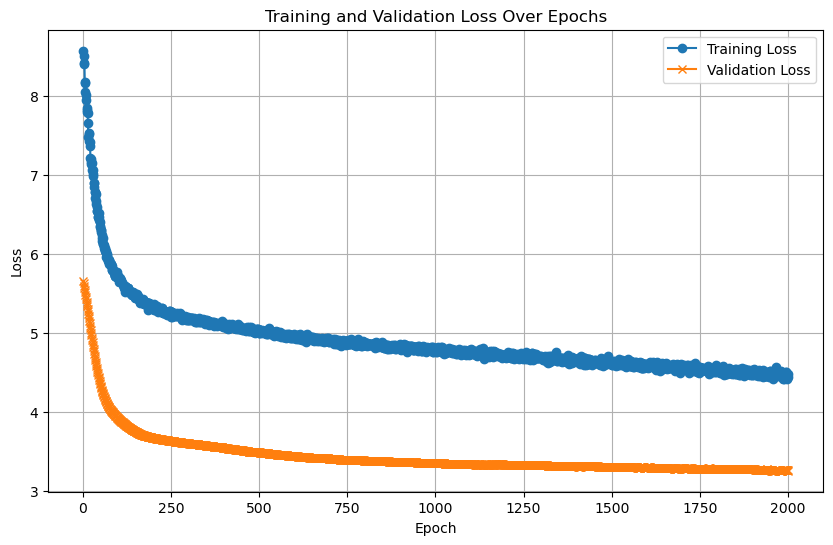

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 5.5039


Test Batch [20/20], Loss: 4.9183

Test Loss: 5.3528


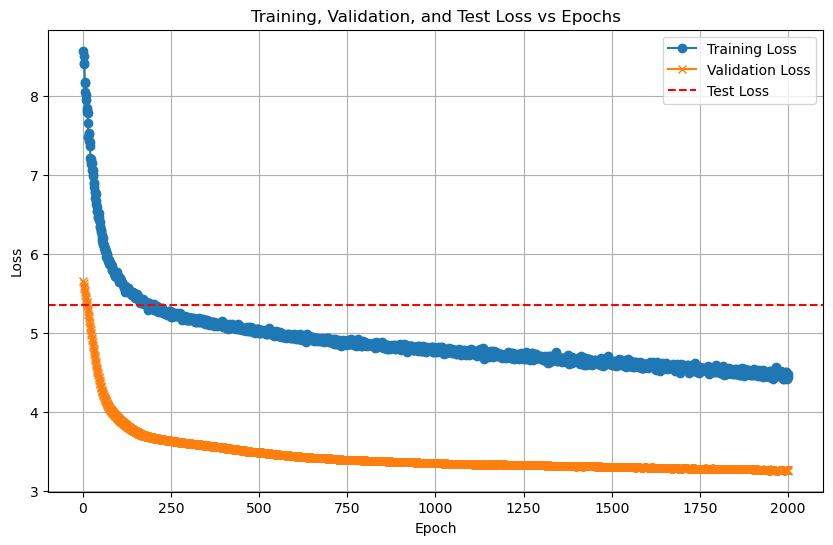

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 47.69%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.25      0.40      0.31         5
           3       0.00      0.00      0.00         5
           4       0.60      0.60      0.60         5
           5       0.50      0.60      0.55         5
           6       0.38      0.60      0.46         5
           7       0.50      1.00      0.67         5
           8       0.50      1.00      0.67         5
           9       0.33      0.40      0.36         5
          10       1.00      1.00      1.00         5
          11       0.00      0.00      0.00         5
          12       0.75      0.60      0.67         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5249  |  Val Loss: 2.5401
Validation loss improved from inf to 2.5401.
[Epoch 2/1000] Train Loss: 2.4971  |  Val Loss: 2.5297
Validation loss improved from 2.5401 to 2.5297.
[Epoch 3/1000] Train Loss: 2.4779  |  Val Loss: 2.5230
Validation loss improved from 2.5297 to 2.5230.
[Epoch 4/1000] Train Loss: 2.4631  |  Val Loss: 2.5186
Validation loss improved from 2.5230 to 2.5186.
[Epoch 5/1000] Train Loss: 2.4505  |  Val Loss: 2.5146
Validation loss improved from 2.5186 to 2.5146.
[Epoch 6/1000] Train Loss: 2.4418  |  Val Loss: 2.5113
Validation loss improved from 2.5146 to 2.5113.
[Epoch 7/1000] Train Loss: 2.4332  |  Val Loss: 2.5067
Validation loss improved from 2.5113 to 2.5067.
[Epoch 8/1000] Train Loss: 2.4254  |  Val Loss: 2.5042
Validation loss improved from 2.5067 to 2.5042.


[Epoch 9/1000] Train Loss: 2.4195  |  Val Loss: 2.5006
Validation loss improved from 2.5042 to 2.5006.
[Epoch 10/1000] Train Loss: 2.4147  |  Val Loss: 2.4972
Validation loss improved from 2.5006 to 2.4972.
[Epoch 11/1000] Train Loss: 2.4103  |  Val Loss: 2.4931
Validation loss improved from 2.4972 to 2.4931.
[Epoch 12/1000] Train Loss: 2.4050  |  Val Loss: 2.4895
Validation loss improved from 2.4931 to 2.4895.
[Epoch 13/1000] Train Loss: 2.4007  |  Val Loss: 2.4852
Validation loss improved from 2.4895 to 2.4852.
[Epoch 14/1000] Train Loss: 2.3961  |  Val Loss: 2.4816
Validation loss improved from 2.4852 to 2.4816.


[Epoch 15/1000] Train Loss: 2.3917  |  Val Loss: 2.4790
Validation loss improved from 2.4816 to 2.4790.
[Epoch 16/1000] Train Loss: 2.3871  |  Val Loss: 2.4759
Validation loss improved from 2.4790 to 2.4759.
[Epoch 17/1000] Train Loss: 2.3830  |  Val Loss: 2.4701
Validation loss improved from 2.4759 to 2.4701.
[Epoch 18/1000] Train Loss: 2.3792  |  Val Loss: 2.4684
Validation loss improved from 2.4701 to 2.4684.
[Epoch 19/1000] Train Loss: 2.3750  |  Val Loss: 2.4664
Validation loss improved from 2.4684 to 2.4664.


[Epoch 20/1000] Train Loss: 2.3717  |  Val Loss: 2.4649
Validation loss improved from 2.4664 to 2.4649.
[Epoch 21/1000] Train Loss: 2.3684  |  Val Loss: 2.4637
Validation loss improved from 2.4649 to 2.4637.
[Epoch 22/1000] Train Loss: 2.3649  |  Val Loss: 2.4584
Validation loss improved from 2.4637 to 2.4584.
[Epoch 23/1000] Train Loss: 2.3633  |  Val Loss: 2.4546
Validation loss improved from 2.4584 to 2.4546.
[Epoch 24/1000] Train Loss: 2.3591  |  Val Loss: 2.4508
Validation loss improved from 2.4546 to 2.4508.
[Epoch 25/1000] Train Loss: 2.3548  |  Val Loss: 2.4473
Validation loss improved from 2.4508 to 2.4473.
[Epoch 26/1000] Train Loss: 2.3520  |  Val Loss: 2.4436
Validation loss improved from 2.4473 to 2.4436.
[Epoch 27/1000] Train Loss: 2.3514  |  Val Loss: 2.4371
Validation loss improved from 2.4436 to 2.4371.
[Epoch 28/1000] Train Loss: 2.3471  |  Val Loss: 2.4364
Validation loss improved from 2.4371 to 2.4364.
[Epoch 29/1000] Train Loss: 2.3425  |  Val Loss: 2.4372
!! Valid

[Epoch 30/1000] Train Loss: 2.3381  |  Val Loss: 2.4404
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 31/1000] Train Loss: 2.3351  |  Val Loss: 2.4422
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 32/1000] Train Loss: 2.3330  |  Val Loss: 2.4422
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 33/1000] Train Loss: 2.3306  |  Val Loss: 2.4415
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 34/1000] Train Loss: 2.3282  |  Val Loss: 2.4402
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 35/1000] Train Loss: 2.3259  |  Val Loss: 2.4346
Validation loss improved from 2.4364 to 2.4346.
[Epoch 36/1000] Train Loss: 2.3229  |  Val Loss: 2.4300
Validation loss improved from 2.4346 to 2.4300.
[Epoch 37/1000] Train Loss: 2.3203  |  Val Loss: 2.4275
Validation loss improved from 2.4300 to 2.4275.
[Epoch 38/1000] Train Loss: 2.3177  |  Val Loss: 2.4273
Validation loss improved from 2.4275 to 2.4273.
[Epoch 39/1000] Train Loss: 2.3149  |  Val Loss: 2.4257
Validation loss improved from 2.4273 to 2.4257.


[Epoch 40/1000] Train Loss: 2.3121  |  Val Loss: 2.4243
Validation loss improved from 2.4257 to 2.4243.
[Epoch 41/1000] Train Loss: 2.3093  |  Val Loss: 2.4223
Validation loss improved from 2.4243 to 2.4223.
[Epoch 42/1000] Train Loss: 2.3064  |  Val Loss: 2.4197
Validation loss improved from 2.4223 to 2.4197.
[Epoch 43/1000] Train Loss: 2.3034  |  Val Loss: 2.4176
Validation loss improved from 2.4197 to 2.4176.
[Epoch 44/1000] Train Loss: 2.3006  |  Val Loss: 2.4162
Validation loss improved from 2.4176 to 2.4162.
[Epoch 45/1000] Train Loss: 2.2979  |  Val Loss: 2.4143
Validation loss improved from 2.4162 to 2.4143.
[Epoch 46/1000] Train Loss: 2.2952  |  Val Loss: 2.4126
Validation loss improved from 2.4143 to 2.4126.


[Epoch 47/1000] Train Loss: 2.2928  |  Val Loss: 2.4113
Validation loss improved from 2.4126 to 2.4113.
[Epoch 48/1000] Train Loss: 2.2896  |  Val Loss: 2.4097
Validation loss improved from 2.4113 to 2.4097.
[Epoch 49/1000] Train Loss: 2.2873  |  Val Loss: 2.4090
Validation loss improved from 2.4097 to 2.4090.
[Epoch 50/1000] Train Loss: 2.2840  |  Val Loss: 2.4064
Validation loss improved from 2.4090 to 2.4064.
[Epoch 51/1000] Train Loss: 2.2812  |  Val Loss: 2.4038
Validation loss improved from 2.4064 to 2.4038.


[Epoch 52/1000] Train Loss: 2.2788  |  Val Loss: 2.4024
Validation loss improved from 2.4038 to 2.4024.
[Epoch 53/1000] Train Loss: 2.2766  |  Val Loss: 2.4000
Validation loss improved from 2.4024 to 2.4000.
[Epoch 54/1000] Train Loss: 2.2739  |  Val Loss: 2.3975
Validation loss improved from 2.4000 to 2.3975.
[Epoch 55/1000] Train Loss: 2.2709  |  Val Loss: 2.3952
Validation loss improved from 2.3975 to 2.3952.
[Epoch 56/1000] Train Loss: 2.2679  |  Val Loss: 2.3937
Validation loss improved from 2.3952 to 2.3937.
[Epoch 57/1000] Train Loss: 2.2649  |  Val Loss: 2.3922
Validation loss improved from 2.3937 to 2.3922.
[Epoch 58/1000] Train Loss: 2.2621  |  Val Loss: 2.3899
Validation loss improved from 2.3922 to 2.3899.


[Epoch 59/1000] Train Loss: 2.2591  |  Val Loss: 2.3889
Validation loss improved from 2.3899 to 2.3889.
[Epoch 60/1000] Train Loss: 2.2567  |  Val Loss: 2.3905
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 61/1000] Train Loss: 2.2542  |  Val Loss: 2.3900
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 62/1000] Train Loss: 2.2516  |  Val Loss: 2.3881
Validation loss improved from 2.3889 to 2.3881.
[Epoch 63/1000] Train Loss: 2.2484  |  Val Loss: 2.3851
Validation loss improved from 2.3881 to 2.3851.
[Epoch 64/1000] Train Loss: 2.2450  |  Val Loss: 2.3829
Validation loss improved from 2.3851 to 2.3829.


[Epoch 65/1000] Train Loss: 2.2425  |  Val Loss: 2.3822
Validation loss improved from 2.3829 to 2.3822.
[Epoch 66/1000] Train Loss: 2.2405  |  Val Loss: 2.3802
Validation loss improved from 2.3822 to 2.3802.
[Epoch 67/1000] Train Loss: 2.2374  |  Val Loss: 2.3769
Validation loss improved from 2.3802 to 2.3769.
[Epoch 68/1000] Train Loss: 2.2332  |  Val Loss: 2.3740
Validation loss improved from 2.3769 to 2.3740.
[Epoch 69/1000] Train Loss: 2.2304  |  Val Loss: 2.3736
Validation loss improved from 2.3740 to 2.3736.
[Epoch 70/1000] Train Loss: 2.2275  |  Val Loss: 2.3735
Validation loss improved from 2.3736 to 2.3735.


[Epoch 71/1000] Train Loss: 2.2251  |  Val Loss: 2.3716
Validation loss improved from 2.3735 to 2.3716.
[Epoch 72/1000] Train Loss: 2.2216  |  Val Loss: 2.3686
Validation loss improved from 2.3716 to 2.3686.
[Epoch 73/1000] Train Loss: 2.2181  |  Val Loss: 2.3689
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 74/1000] Train Loss: 2.2147  |  Val Loss: 2.3707
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 75/1000] Train Loss: 2.2124  |  Val Loss: 2.3699
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 76/1000] Train Loss: 2.2084  |  Val Loss: 2.3666
Validation loss improved from 2.3686 to 2.3666.
[Epoch 77/1000] Train Loss: 2.2050  |  Val Loss: 2.3620
Validation loss improved from 2.3666 to 2.3620.


[Epoch 78/1000] Train Loss: 2.1997  |  Val Loss: 2.3583
Validation loss improved from 2.3620 to 2.3583.
[Epoch 79/1000] Train Loss: 2.1957  |  Val Loss: 2.3532
Validation loss improved from 2.3583 to 2.3532.
[Epoch 80/1000] Train Loss: 2.1924  |  Val Loss: 2.3499
Validation loss improved from 2.3532 to 2.3499.
[Epoch 81/1000] Train Loss: 2.1890  |  Val Loss: 2.3497
Validation loss improved from 2.3499 to 2.3497.
[Epoch 82/1000] Train Loss: 2.1858  |  Val Loss: 2.3540
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 83/1000] Train Loss: 2.1846  |  Val Loss: 2.3547
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 2.1823  |  Val Loss: 2.3534
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 85/1000] Train Loss: 2.1781  |  Val Loss: 2.3498
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 86/1000] Train Loss: 2.1746  |  Val Loss: 2.3480
Validation loss improved from 2.3497 to 2.3480.
[Epoch 87/1000] Train Loss: 2.1738  |  Val Loss: 2.3504
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 88/1000] Train Loss: 2.1746  |  Val Loss: 2.3459
Validation loss improved from 2.3480 to 2.3459.


[Epoch 89/1000] Train Loss: 2.1700  |  Val Loss: 2.3373
Validation loss improved from 2.3459 to 2.3373.
[Epoch 90/1000] Train Loss: 2.1635  |  Val Loss: 2.3307
Validation loss improved from 2.3373 to 2.3307.
[Epoch 91/1000] Train Loss: 2.1585  |  Val Loss: 2.3277
Validation loss improved from 2.3307 to 2.3277.
[Epoch 92/1000] Train Loss: 2.1547  |  Val Loss: 2.3251
Validation loss improved from 2.3277 to 2.3251.
[Epoch 93/1000] Train Loss: 2.1517  |  Val Loss: 2.3251
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 94/1000] Train Loss: 2.1487  |  Val Loss: 2.3245
Validation loss improved from 2.3251 to 2.3245.
[Epoch 95/1000] Train Loss: 2.1459  |  Val Loss: 2.3252
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 96/1000] Train Loss: 2.1423  |  Val Loss: 2.3253
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 97/1000] Train Loss: 2.1395  |  Val Loss: 2.3230
Validation loss improved from 2.3245 to 2.3230.


[Epoch 98/1000] Train Loss: 2.1364  |  Val Loss: 2.3201
Validation loss improved from 2.3230 to 2.3201.
[Epoch 99/1000] Train Loss: 2.1332  |  Val Loss: 2.3184
Validation loss improved from 2.3201 to 2.3184.
[Epoch 100/1000] Train Loss: 2.1312  |  Val Loss: 2.3173
Validation loss improved from 2.3184 to 2.3173.
[Epoch 101/1000] Train Loss: 2.1286  |  Val Loss: 2.3173
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 2.1248  |  Val Loss: 2.3162
Validation loss improved from 2.3173 to 2.3162.
[Epoch 103/1000] Train Loss: 2.1209  |  Val Loss: 2.3157
Validation loss improved from 2.3162 to 2.3157.


[Epoch 104/1000] Train Loss: 2.1186  |  Val Loss: 2.3140
Validation loss improved from 2.3157 to 2.3140.
[Epoch 105/1000] Train Loss: 2.1154  |  Val Loss: 2.3142
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 106/1000] Train Loss: 2.1134  |  Val Loss: 2.3134
Validation loss improved from 2.3140 to 2.3134.
[Epoch 107/1000] Train Loss: 2.1094  |  Val Loss: 2.3059
Validation loss improved from 2.3134 to 2.3059.
[Epoch 108/1000] Train Loss: 2.1053  |  Val Loss: 2.2858
Validation loss improved from 2.3059 to 2.2858.
[Epoch 109/1000] Train Loss: 2.1097  |  Val Loss: 2.2801
Validation loss improved from 2.2858 to 2.2801.
[Epoch 110/1000] Train Loss: 2.1113  |  Val Loss: 2.2821
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 111/1000] Train Loss: 2.1032  |  Val Loss: 2.2871
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 112/1000] Train Loss: 2.0942  |  Val Loss: 2.2965
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 113/1000] Train Loss: 2.0893  |  Val Loss: 2.3029
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 114/1000] Train Loss: 2.0903  |  Val Loss: 2.2998
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 115/1000] Train Loss: 2.0841  |  Val Loss: 2.2800
Validation loss improved from 2.2801 to 2.2800.
[Epoch 116/1000] Train Loss: 2.0826  |  Val Loss: 2.2693
Validation loss improved from 2.2800 to 2.2693.
[Epoch 117/1000] Train Loss: 2.0832  |  Val Loss: 2.2690
Validation loss improved from 2.2693 to 2.2690.
[Epoch 118/1000] Train Loss: 2.0753  |  Val Loss: 2.2779
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 2.0690  |  Val Loss: 2.2830
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 120/1000] Train Loss: 2.0699  |  Val Loss: 2.2890
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 121/1000] Train Loss: 2.0664  |  Val Loss: 2.2885
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 122/1000] Train Loss: 2.0623  |  Val Loss: 2.2841
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 123/1000] Train Loss: 2.0573  |  Val Loss: 2.2794
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 124/1000] Train Loss: 2.0524  |  Val Loss: 2.2736
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 125/1000] Train Loss: 2.0472  |  Val Loss: 2.2681
Validation loss improved from 2.2690 to 2.2681.
[Epoch 126/1000] Train Loss: 2.0431  |  Val Loss: 2.2639
Validation loss improved from 2.2681 to 2.2639.
[Epoch 127/1000] Train Loss: 2.0397  |  Val Loss: 2.2624
Validation loss improved from 2.2639 to 2.2624.
[Epoch 128/1000] Train Loss: 2.0358  |  Val Loss: 2.2591
Validation loss improved from 2.2624 to 2.2591.
[Epoch 129/1000] Train Loss: 2.0335  |  Val Loss: 2.2495
Validation loss improved from 2.2591 to 2.2495.
[Epoch 130/1000] Train Loss: 2.0321  |  Val Loss: 2.2455
Validation loss improved from 2.2495 to 2.2455.


[Epoch 131/1000] Train Loss: 2.0274  |  Val Loss: 2.2439
Validation loss improved from 2.2455 to 2.2439.
[Epoch 132/1000] Train Loss: 2.0238  |  Val Loss: 2.2408
Validation loss improved from 2.2439 to 2.2408.
[Epoch 133/1000] Train Loss: 2.0204  |  Val Loss: 2.2411
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 134/1000] Train Loss: 2.0149  |  Val Loss: 2.2433
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 135/1000] Train Loss: 2.0105  |  Val Loss: 2.2464
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 136/1000] Train Loss: 2.0046  |  Val Loss: 2.2523
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 137/1000] Train Loss: 2.0032  |  Val Loss: 2.2632
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 138/1000] Train Loss: 2.0050  |  Val Loss: 2.2654
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 139/1000] Train Loss: 2.0015  |  Val Loss: 2.2569
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 140/1000] Train Loss: 1.9941  |  Val Loss: 2.2482
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 141/1000] Train Loss: 1.9893  |  Val Loss: 2.2400
Validation loss improved from 2.2408 to 2.2400.


[Epoch 142/1000] Train Loss: 1.9843  |  Val Loss: 2.2348
Validation loss improved from 2.2400 to 2.2348.
[Epoch 143/1000] Train Loss: 1.9802  |  Val Loss: 2.2317
Validation loss improved from 2.2348 to 2.2317.
[Epoch 144/1000] Train Loss: 1.9787  |  Val Loss: 2.2282
Validation loss improved from 2.2317 to 2.2282.
[Epoch 145/1000] Train Loss: 1.9753  |  Val Loss: 2.2265
Validation loss improved from 2.2282 to 2.2265.
[Epoch 146/1000] Train Loss: 1.9711  |  Val Loss: 2.2245
Validation loss improved from 2.2265 to 2.2245.
[Epoch 147/1000] Train Loss: 1.9663  |  Val Loss: 2.2231
Validation loss improved from 2.2245 to 2.2231.


[Epoch 148/1000] Train Loss: 1.9629  |  Val Loss: 2.2229
Validation loss improved from 2.2231 to 2.2229.
[Epoch 149/1000] Train Loss: 1.9579  |  Val Loss: 2.2225
Validation loss improved from 2.2229 to 2.2225.
[Epoch 150/1000] Train Loss: 1.9544  |  Val Loss: 2.2212
Validation loss improved from 2.2225 to 2.2212.
[Epoch 151/1000] Train Loss: 1.9511  |  Val Loss: 2.2193
Validation loss improved from 2.2212 to 2.2193.
[Epoch 152/1000] Train Loss: 1.9473  |  Val Loss: 2.2156
Validation loss improved from 2.2193 to 2.2156.
[Epoch 153/1000] Train Loss: 1.9441  |  Val Loss: 2.2106
Validation loss improved from 2.2156 to 2.2106.


[Epoch 154/1000] Train Loss: 1.9397  |  Val Loss: 2.2121
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 155/1000] Train Loss: 1.9379  |  Val Loss: 2.2281
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 156/1000] Train Loss: 1.9394  |  Val Loss: 2.2326
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 157/1000] Train Loss: 1.9375  |  Val Loss: 2.2294
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 158/1000] Train Loss: 1.9321  |  Val Loss: 2.2215
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 159/1000] Train Loss: 1.9269  |  Val Loss: 2.2136
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 160/1000] Train Loss: 1.9217  |  Val Loss: 2.2062
Validation loss improved from 2.2106 to 2.2062.


[Epoch 161/1000] Train Loss: 1.9158  |  Val Loss: 2.2018
Validation loss improved from 2.2062 to 2.2018.
[Epoch 162/1000] Train Loss: 1.9112  |  Val Loss: 2.2032
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 163/1000] Train Loss: 1.9088  |  Val Loss: 2.2018
Validation loss improved from 2.2018 to 2.2018.
[Epoch 164/1000] Train Loss: 1.9042  |  Val Loss: 2.1977
Validation loss improved from 2.2018 to 2.1977.
[Epoch 165/1000] Train Loss: 1.9012  |  Val Loss: 2.1926
Validation loss improved from 2.1977 to 2.1926.
[Epoch 166/1000] Train Loss: 1.8973  |  Val Loss: 2.1877
Validation loss improved from 2.1926 to 2.1877.
[Epoch 167/1000] Train Loss: 1.8939  |  Val Loss: 2.1849
Validation loss improved from 2.1877 to 2.1849.


[Epoch 168/1000] Train Loss: 1.8901  |  Val Loss: 2.1819
Validation loss improved from 2.1849 to 2.1819.
[Epoch 169/1000] Train Loss: 1.8862  |  Val Loss: 2.1794
Validation loss improved from 2.1819 to 2.1794.
[Epoch 170/1000] Train Loss: 1.8816  |  Val Loss: 2.1761
Validation loss improved from 2.1794 to 2.1761.
[Epoch 171/1000] Train Loss: 1.8779  |  Val Loss: 2.1737
Validation loss improved from 2.1761 to 2.1737.
[Epoch 172/1000] Train Loss: 1.8737  |  Val Loss: 2.1708
Validation loss improved from 2.1737 to 2.1708.


[Epoch 173/1000] Train Loss: 1.8708  |  Val Loss: 2.1617
Validation loss improved from 2.1708 to 2.1617.
[Epoch 174/1000] Train Loss: 1.8678  |  Val Loss: 2.1597
Validation loss improved from 2.1617 to 2.1597.
[Epoch 175/1000] Train Loss: 1.8643  |  Val Loss: 2.1597
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 176/1000] Train Loss: 1.8598  |  Val Loss: 2.1620
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 177/1000] Train Loss: 1.8560  |  Val Loss: 2.1649
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 178/1000] Train Loss: 1.8518  |  Val Loss: 2.1657
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 179/1000] Train Loss: 1.8479  |  Val Loss: 2.1655
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 180/1000] Train Loss: 1.8447  |  Val Loss: 2.1629
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 181/1000] Train Loss: 1.8406  |  Val Loss: 2.1629
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 182/1000] Train Loss: 1.8379  |  Val Loss: 2.1569
Validation loss improved from 2.1597 to 2.1569.
[Epoch 183/1000] Train Loss: 1.8334  |  Val Loss: 2.1462
Validation loss improved from 2.1569 to 2.1462.
[Epoch 184/1000] Train Loss: 1.8327  |  Val Loss: 2.1404
Validation loss improved from 2.1462 to 2.1404.
[Epoch 185/1000] Train Loss: 1.8308  |  Val Loss: 2.1378
Validation loss improved from 2.1404 to 2.1378.
[Epoch 186/1000] Train Loss: 1.8259  |  Val Loss: 2.1446
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 187/1000] Train Loss: 1.8216  |  Val Loss: 2.1612
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 188/1000] Train Loss: 1.8204  |  Val Loss: 2.1642
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 189/1000] Train Loss: 1.8197  |  Val Loss: 2.1616
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 190/1000] Train Loss: 1.8149  |  Val Loss: 2.1565
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 191/1000] Train Loss: 1.8102  |  Val Loss: 2.1499
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 192/1000] Train Loss: 1.8060  |  Val Loss: 2.1456
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 193/1000] Train Loss: 1.8024  |  Val Loss: 2.1378
Validation loss improved from 2.1378 to 2.1378.
[Epoch 194/1000] Train Loss: 1.7927  |  Val Loss: 2.1423
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 195/1000] Train Loss: 1.7941  |  Val Loss: 2.1496
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 196/1000] Train Loss: 1.7938  |  Val Loss: 2.1502
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 197/1000] Train Loss: 1.7901  |  Val Loss: 2.1439
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 198/1000] Train Loss: 1.7850  |  Val Loss: 2.1314
Validation loss improved from 2.1378 to 2.1314.
[Epoch 199/1000] Train Loss: 1.7798  |  Val Loss: 2.1219
Validation loss improved from 2.1314 to 2.1219.
[Epoch 200/1000] Train Loss: 1.7744  |  Val Loss: 2.1184
Validation loss improved from 2.1219 to 2.1184.
[Epoch 201/1000] Train Loss: 1.7707  |  Val Loss: 2.1169
Validation loss improved from 2.1184 to 2.1169.
[Epoch 202/1000] Train Loss: 1.7675  |  Val Loss: 2.1218
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 203/1000] Train Loss: 1.7678  |  Val Loss: 2.1410
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 204/1000] Train Loss: 1.7707  |  Val Loss: 2.1498
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 205/1000] Train Loss: 1.7707  |  Val Loss: 2.1480
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 206/1000] Train Loss: 1.7657  |  Val Loss: 2.1417
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 207/1000] Train Loss: 1.7586  |  Val Loss: 2.1347
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 208/1000] Train Loss: 1.7524  |  Val Loss: 2.1266
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 209/1000] Train Loss: 1.7457  |  Val Loss: 2.1197
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 210/1000] Train Loss: 1.7412  |  Val Loss: 2.1152
Validation loss improved from 2.1169 to 2.1152.
[Epoch 211/1000] Train Loss: 1.7359  |  Val Loss: 2.1353
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 212/1000] Train Loss: 1.7462  |  Val Loss: 2.1512
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 213/1000] Train Loss: 1.7480  |  Val Loss: 2.1451
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 214/1000] Train Loss: 1.7398  |  Val Loss: 2.1301
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 215/1000] Train Loss: 1.7305  |  Val Loss: 2.1141
Validation loss improved from 2.1152 to 2.1141.
[Epoch 216/1000] Train Loss: 1.7242  |  Val Loss: 2.1037
Validation loss improved from 2.1141 to 2.1037.
[Epoch 217/1000] Train Loss: 1.7192  |  Val Loss: 2.0979
Validation loss improved from 2.1037 to 2.0979.
[Epoch 218/1000] Train Loss: 1.7165  |  Val Loss: 2.0986
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 219/1000] Train Loss: 1.7122  |  Val Loss: 2.1141
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 220/1000] Train Loss: 1.7162  |  Val Loss: 2.1182
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 221/1000] Train Loss: 1.7131  |  Val Loss: 2.1029
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 222/1000] Train Loss: 1.7054  |  Val Loss: 2.0934
Validation loss improved from 2.0979 to 2.0934.


[Epoch 223/1000] Train Loss: 1.7009  |  Val Loss: 2.0880
Validation loss improved from 2.0934 to 2.0880.
[Epoch 224/1000] Train Loss: 1.6970  |  Val Loss: 2.0858
Validation loss improved from 2.0880 to 2.0858.
[Epoch 225/1000] Train Loss: 1.6935  |  Val Loss: 2.0866
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 226/1000] Train Loss: 1.6904  |  Val Loss: 2.0879
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 227/1000] Train Loss: 1.6874  |  Val Loss: 2.0882
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 228/1000] Train Loss: 1.6845  |  Val Loss: 2.0866
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 229/1000] Train Loss: 1.6810  |  Val Loss: 2.0844
Validation loss improved from 2.0858 to 2.0844.
[Epoch 230/1000] Train Loss: 1.6775  |  Val Loss: 2.0803
Validation loss improved from 2.0844 to 2.0803.
[Epoch 231/1000] Train Loss: 1.6774  |  Val Loss: 2.0647
Validation loss improved from 2.0803 to 2.0647.


[Epoch 232/1000] Train Loss: 1.6782  |  Val Loss: 2.0608
Validation loss improved from 2.0647 to 2.0608.
[Epoch 233/1000] Train Loss: 1.6763  |  Val Loss: 2.0654
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 234/1000] Train Loss: 1.6700  |  Val Loss: 2.0701
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 235/1000] Train Loss: 1.6645  |  Val Loss: 2.0701
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 236/1000] Train Loss: 1.6606  |  Val Loss: 2.0709
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 237/1000] Train Loss: 1.6564  |  Val Loss: 2.0729
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 238/1000] Train Loss: 1.6530  |  Val Loss: 2.0804
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 239/1000] Train Loss: 1.6493  |  Val Loss: 2.0908
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 240/1000] Train Loss: 1.6476  |  Val Loss: 2.0937
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 241/1000] Train Loss: 1.6450  |  Val Loss: 2.0950
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 242/1000] Train Loss: 1.6434  |  Val Loss: 2.1000
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 243/1000] Train Loss: 1.6441  |  Val Loss: 2.0934
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 244/1000] Train Loss: 1.6373  |  Val Loss: 2.0641
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 245/1000] Train Loss: 1.6356  |  Val Loss: 2.0503
Validation loss improved from 2.0608 to 2.0503.
[Epoch 246/1000] Train Loss: 1.6383  |  Val Loss: 2.0518
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 247/1000] Train Loss: 1.6309  |  Val Loss: 2.0649
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 248/1000] Train Loss: 1.6235  |  Val Loss: 2.0785
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 249/1000] Train Loss: 1.6222  |  Val Loss: 2.0879
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 250/1000] Train Loss: 1.6203  |  Val Loss: 2.0979
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 251/1000] Train Loss: 1.6217  |  Val Loss: 2.1011
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 252/1000] Train Loss: 1.6183  |  Val Loss: 2.0986
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 253/1000] Train Loss: 1.6133  |  Val Loss: 2.0926
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 254/1000] Train Loss: 1.6089  |  Val Loss: 2.0850
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 255/1000] Train Loss: 1.6056  |  Val Loss: 2.0780
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 256/1000] Train Loss: 1.6029  |  Val Loss: 2.0754
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 257/1000] Train Loss: 1.5990  |  Val Loss: 2.0746
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 259/1000] Train Loss: 1.5911  |  Val Loss: 2.0716
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 260/1000] Train Loss: 1.5878  |  Val Loss: 2.0994
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 261/1000] Train Loss: 1.5960  |  Val Loss: 2.1172
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 262/1000] Train Loss: 1.5985  |  Val Loss: 2.1091
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 263/1000] Train Loss: 1.5923  |  Val Loss: 2.0953
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 264/1000] Train Loss: 1.5851  |  Val Loss: 2.0827
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 265/1000] Train Loss: 1.5801  |  Val Loss: 2.0938
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 266/1000] Train Loss: 1.5823  |  Val Loss: 2.0947
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 267/1000] Train Loss: 1.5783  |  Val Loss: 2.0846
!! Validation loss did NOT improve !! Patience:

[Epoch 268/1000] Train Loss: 1.5719  |  Val Loss: 2.0771
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 269/1000] Train Loss: 1.5653  |  Val Loss: 2.0660
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 270/1000] Train Loss: 1.5623  |  Val Loss: 2.0758
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 271/1000] Train Loss: 1.5654  |  Val Loss: 2.0887
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 272/1000] Train Loss: 1.5682  |  Val Loss: 2.0905
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 273/1000] Train Loss: 1.5658  |  Val Loss: 2.0850
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 274/1000] Train Loss: 1.5593  |  Val Loss: 2.0721
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 275/1000] Train Loss: 1.5492  |  Val Loss: 2.0578
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 276/1000] Train Loss: 1.5475  |  Val Loss: 2.0489
Validation loss improved from 2.0503 to 2.0489.

[Epoch 279/1000] Train Loss: 1.5350  |  Val Loss: 2.0552
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 280/1000] Train Loss: 1.5327  |  Val Loss: 2.0568
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 281/1000] Train Loss: 1.5295  |  Val Loss: 2.0576
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 282/1000] Train Loss: 1.5278  |  Val Loss: 2.0595
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 283/1000] Train Loss: 1.5242  |  Val Loss: 2.0574
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 284/1000] Train Loss: 1.5222  |  Val Loss: 2.0534
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 285/1000] Train Loss: 1.5201  |  Val Loss: 2.0660
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 286/1000] Train Loss: 1.5229  |  Val Loss: 2.0744
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 287/1000] Train Loss: 1.5213  |  Val Loss: 2.0731
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 290/1000] Train Loss: 1.5151  |  Val Loss: 2.0895
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 291/1000] Train Loss: 1.5131  |  Val Loss: 2.0843
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 292/1000] Train Loss: 1.5088  |  Val Loss: 2.0792
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 293/1000] Train Loss: 1.5064  |  Val Loss: 2.0763
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 294/1000] Train Loss: 1.5041  |  Val Loss: 2.0722
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 295/1000] Train Loss: 1.4999  |  Val Loss: 2.0681
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 296/1000] Train Loss: 1.4963  |  Val Loss: 2.0629
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 297/1000] Train Loss: 1.4917  |  Val Loss: 2.0615
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 298/1000] Train Loss: 1.4890  |  Val Loss: 2.0600
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 299/1000] Train Loss: 1.4860  |  Val Loss: 2.0589
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 300/1000] Train Loss: 1.4843  |  Val Loss: 2.0574
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 301/1000] Train Loss: 1.4813  |  Val Loss: 2.0604
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 302/1000] Train Loss: 1.4788  |  Val Loss: 2.0637
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 303/1000] Train Loss: 1.4761  |  Val Loss: 2.0661
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 304/1000] Train Loss: 1.4735  |  Val Loss: 2.0630
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 305/1000] Train Loss: 1.4727  |  Val Loss: 2.0522
!! Validation loss did NOT improve !! Patience:

[Epoch 308/1000] Train Loss: 1.4670  |  Val Loss: 2.0617
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 309/1000] Train Loss: 1.4626  |  Val Loss: 2.0701
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 310/1000] Train Loss: 1.4600  |  Val Loss: 2.0836
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 311/1000] Train Loss: 1.4591  |  Val Loss: 2.0815
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 312/1000] Train Loss: 1.4565  |  Val Loss: 2.0810
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 313/1000] Train Loss: 1.4533  |  Val Loss: 2.0737
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 314/1000] Train Loss: 1.4489  |  Val Loss: 2.0582
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 315/1000] Train Loss: 1.4502  |  Val Loss: 2.0528
!! Validation loss did NOT improve !! Patience: 38/100


[Epoch 316/1000] Train Loss: 1.4505  |  Val Loss: 2.0526
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 317/1000] Train Loss: 1.4473  |  Val Loss: 2.0588
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 318/1000] Train Loss: 1.4429  |  Val Loss: 2.0684
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 319/1000] Train Loss: 1.4402  |  Val Loss: 2.1139
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 320/1000] Train Loss: 1.4584  |  Val Loss: 2.1392
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 321/1000] Train Loss: 1.4612  |  Val Loss: 2.1313
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 322/1000] Train Loss: 1.4528  |  Val Loss: 2.1008
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 323/1000] Train Loss: 1.4372  |  Val Loss: 2.0671
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 324/1000] Train Loss: 1.4294  |  Val Loss: 2.0581
!! Validation loss did NOT improve !! Patience:

[Epoch 325/1000] Train Loss: 1.4267  |  Val Loss: 2.0587
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 326/1000] Train Loss: 1.4247  |  Val Loss: 2.0581
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 327/1000] Train Loss: 1.4220  |  Val Loss: 2.0609
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 328/1000] Train Loss: 1.4200  |  Val Loss: 2.0652
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 329/1000] Train Loss: 1.4180  |  Val Loss: 2.0674
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 330/1000] Train Loss: 1.4156  |  Val Loss: 2.0689
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 331/1000] Train Loss: 1.4133  |  Val Loss: 2.0697
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 332/1000] Train Loss: 1.4115  |  Val Loss: 2.0707
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 333/1000] Train Loss: 1.4094  |  Val Loss: 2.0668
!! Validation loss did NOT improve !! Patience:

[Epoch 334/1000] Train Loss: 1.4063  |  Val Loss: 2.0628
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 335/1000] Train Loss: 1.4050  |  Val Loss: 2.0650
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 336/1000] Train Loss: 1.4028  |  Val Loss: 2.0719
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 337/1000] Train Loss: 1.4014  |  Val Loss: 2.0861
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 338/1000] Train Loss: 1.4010  |  Val Loss: 2.0899
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 339/1000] Train Loss: 1.3999  |  Val Loss: 2.0900
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 340/1000] Train Loss: 1.3969  |  Val Loss: 2.0844
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 341/1000] Train Loss: 1.3918  |  Val Loss: 2.0804
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 342/1000] Train Loss: 1.3887  |  Val Loss: 2.0762
!! Validation loss did NOT improve !! Patience:

[Epoch 343/1000] Train Loss: 1.3862  |  Val Loss: 2.0773
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 344/1000] Train Loss: 1.3840  |  Val Loss: 2.0779
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 345/1000] Train Loss: 1.3816  |  Val Loss: 2.0788
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 346/1000] Train Loss: 1.3808  |  Val Loss: 2.0838
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 347/1000] Train Loss: 1.3839  |  Val Loss: 2.1104
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 348/1000] Train Loss: 1.3923  |  Val Loss: 2.1281
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 349/1000] Train Loss: 1.3917  |  Val Loss: 2.1199
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 350/1000] Train Loss: 1.3840  |  Val Loss: 2.1050
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 351/1000] Train Loss: 1.3758  |  Val Loss: 2.0901
!! Validation loss did NOT improve !! Patience:

[Epoch 353/1000] Train Loss: 1.3678  |  Val Loss: 2.0812
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 354/1000] Train Loss: 1.3641  |  Val Loss: 2.0861
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 355/1000] Train Loss: 1.3640  |  Val Loss: 2.0907
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 356/1000] Train Loss: 1.3632  |  Val Loss: 2.0896
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 357/1000] Train Loss: 1.3636  |  Val Loss: 2.0723
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 358/1000] Train Loss: 1.3680  |  Val Loss: 2.0643
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 359/1000] Train Loss: 1.3687  |  Val Loss: 2.0608
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 360/1000] Train Loss: 1.3649  |  Val Loss: 2.0659
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 361/1000] Train Loss: 1.3576  |  Val Loss: 2.0745
!! Validation loss did NOT improve !! Patience:

[Epoch 363/1000] Train Loss: 1.3487  |  Val Loss: 2.0913
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 364/1000] Train Loss: 1.3468  |  Val Loss: 2.0961
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 365/1000] Train Loss: 1.3441  |  Val Loss: 2.0966
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 366/1000] Train Loss: 1.3417  |  Val Loss: 2.0976
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 367/1000] Train Loss: 1.3394  |  Val Loss: 2.0977
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 368/1000] Train Loss: 1.3382  |  Val Loss: 2.0979
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 369/1000] Train Loss: 1.3358  |  Val Loss: 2.0980
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 370/1000] Train Loss: 1.3339  |  Val Loss: 2.0989
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 371/1000] Train Loss: 1.3316  |  Val Loss: 2.0998
!! Validation loss did NOT improve !! Patience:

[Epoch 374/1000] Train Loss: 1.3257  |  Val Loss: 2.1016
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 375/1000] Train Loss: 1.3241  |  Val Loss: 2.1030
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 376/1000] Train Loss: 1.3216  |  Val Loss: 2.1057
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 377/1000] Train Loss: 1.3197  |  Val Loss: 2.1088
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 377 !!
No improvement for 100 epochs.


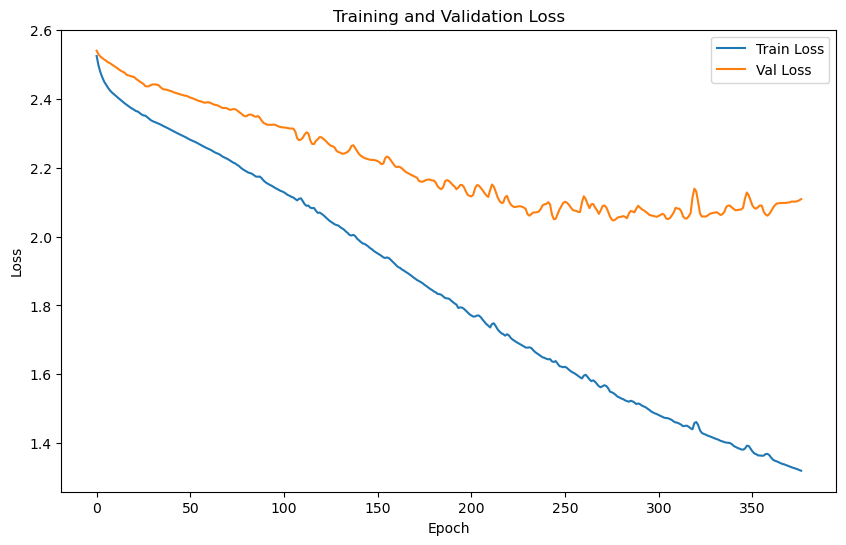

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.1022 | Test Accuracy: 46.44%


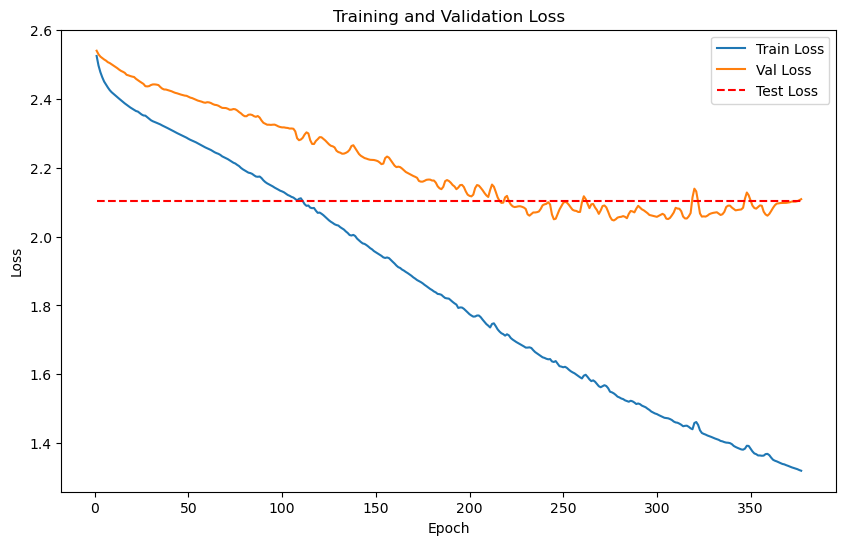

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)


Train embeddings shape: (260, 64), 
Train labels shape: (260,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4886, 64), 
Test labels shape: (4886,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5348
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6131
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5348, Avg Val Loss: 0.5565

Validation loss improved from inf to 0.5565. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5318
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.6130
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5318, Avg Val Loss: 0.5565

Validation loss improved from 0.5565 to 0.5565. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5333
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.6119
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5333, Avg Val Loss: 0.5560

Validation loss improved from 0.5565 to 0.5560. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.5315
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.6114
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5315, Avg Val Loss: 0.5557

Validation loss improved from 0.5560 to 0.5557. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5295
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.6109
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5295, Avg Val Loss: 0.5555

Validation loss improved from 0.5557 to 0.5555. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.5305
LOG: Epoch [6/2000] - Validation


    Batch [1/2], Val Loss: 0.6108
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5305, Avg Val Loss: 0.5554

Validation loss improved from 0.5555 to 0.5554. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.5273
LOG: Epoch [7/2000] - Validation


    Batch [1/2], Val Loss: 0.6104
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5273, Avg Val Loss: 0.5552

Validation loss improved from 0.5554 to 0.5552. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.5265
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.6092
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5265, Avg Val Loss: 0.5546

Validation loss improved from 0.5552 to 0.5546. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.5267
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.6087
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5267, Avg Val Loss: 0.5543

Validation loss improved from 0.5546 to 0.5543. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5241
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.6080
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5241, Avg Val Loss: 0.5540

Validation loss improved from 0.5543 to 0.5540. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.5228
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.6076
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5228, Avg Val Loss: 0.5538

Validation loss improved from 0.5540 to 0.5538. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.5228
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.6068
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5228, Avg Val Loss: 0.5534

Validation loss improved from 0.5538 to 0.5534. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.5211
LOG: Epoch [13/2000] - Validation


    Batch [1/2], Val Loss: 0.6059
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5211, Avg Val Loss: 0.5529

Validation loss improved from 0.5534 to 0.5529. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.5192
LOG: Epoch [14/2000] - Validation


    Batch [1/2], Val Loss: 0.6047
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5192, Avg Val Loss: 0.5523

Validation loss improved from 0.5529 to 0.5523. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.5205
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.6034
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5205, Avg Val Loss: 0.5517

Validation loss improved from 0.5523 to 0.5517. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.5236
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.6014
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5236, Avg Val Loss: 0.5507

Validation loss improved from 0.5517 to 0.5507. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.5206
LOG: Epoch [17/2000] - Validation


    Batch [1/2], Val Loss: 0.5995
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5206, Avg Val Loss: 0.5497

Validation loss improved from 0.5507 to 0.5497. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5173
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.5976
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5173, Avg Val Loss: 0.5488

Validation loss improved from 0.5497 to 0.5488. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5170
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5953
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5170, Avg Val Loss: 0.5477

Validation loss improved from 0.5488 to 0.5477. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.5178
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5939
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5178, Avg Val Loss: 0.5469

Validation loss improved from 0.5477 to 0.5469. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.5152
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5923
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5152, Avg Val Loss: 0.5462

Validation loss improved from 0.5469 to 0.5462. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.5184
LOG: Epoch [22/2000] - Validation


    Batch [1/2], Val Loss: 0.5903
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5184, Avg Val Loss: 0.5451

Validation loss improved from 0.5462 to 0.5451. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.5142
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5879
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5142, Avg Val Loss: 0.5440

Validation loss improved from 0.5451 to 0.5440. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.5151
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5851
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5151, Avg Val Loss: 0.5426

Validation loss improved from 0.5440 to 0.5426. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.5148
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.5820
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5148, Avg Val Loss: 0.5410

Validation loss improved from 0.5426 to 0.5410. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.5113
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5786
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5113, Avg Val Loss: 0.5393

Validation loss improved from 0.5410 to 0.5393. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.5147
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5750
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5147, Avg Val Loss: 0.5375

Validation loss improved from 0.5393 to 0.5375. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.5140
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.5713
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5140, Avg Val Loss: 0.5357

Validation loss improved from 0.5375 to 0.5357. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.5095
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.5678
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5095, Avg Val Loss: 0.5339

Validation loss improved from 0.5357 to 0.5339. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.5105
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5647
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5105, Avg Val Loss: 0.5324

Validation loss improved from 0.5339 to 0.5324. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.5110
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5616
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5110, Avg Val Loss: 0.5308

Validation loss improved from 0.5324 to 0.5308. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.5107
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5587
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5107, Avg Val Loss: 0.5293

Validation loss improved from 0.5308 to 0.5293. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.5115
LOG: Epoch [33/2000] - Validation


    Batch [1/2], Val Loss: 0.5560
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5115, Avg Val Loss: 0.5280

Validation loss improved from 0.5293 to 0.5280. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.5097
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.5534
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5097, Avg Val Loss: 0.5267

Validation loss improved from 0.5280 to 0.5267. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.5106
LOG: Epoch [35/2000] - Validation


    Batch [1/2], Val Loss: 0.5511
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5106, Avg Val Loss: 0.5256

Validation loss improved from 0.5267 to 0.5256. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.5072
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5489
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5072, Avg Val Loss: 0.5245

Validation loss improved from 0.5256 to 0.5245. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.5096
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5467
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5096, Avg Val Loss: 0.5234

Validation loss improved from 0.5245 to 0.5234. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.5087
LOG: Epoch [38/2000] - Validation


    Batch [1/2], Val Loss: 0.5445
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5087, Avg Val Loss: 0.5223

Validation loss improved from 0.5234 to 0.5223. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.5070
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.5424
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5070, Avg Val Loss: 0.5212

Validation loss improved from 0.5223 to 0.5212. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.5082
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5404
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5082, Avg Val Loss: 0.5202

Validation loss improved from 0.5212 to 0.5202. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.5086
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5385
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5086, Avg Val Loss: 0.5193

Validation loss improved from 0.5202 to 0.5193. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.5076
LOG: Epoch [42/2000] - Validation


    Batch [1/2], Val Loss: 0.5369
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5076, Avg Val Loss: 0.5184

Validation loss improved from 0.5193 to 0.5184. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.5073
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5353
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5073, Avg Val Loss: 0.5177

Validation loss improved from 0.5184 to 0.5177. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.5082
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5339
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5082, Avg Val Loss: 0.5169

Validation loss improved from 0.5177 to 0.5169. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.5063
LOG: Epoch [45/2000] - Validation


    Batch [1/2], Val Loss: 0.5326
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5063, Avg Val Loss: 0.5163

Validation loss improved from 0.5169 to 0.5163. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.5051
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5315
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5051, Avg Val Loss: 0.5157

Validation loss improved from 0.5163 to 0.5157. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.5064
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5304
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5064, Avg Val Loss: 0.5152

Validation loss improved from 0.5157 to 0.5152. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.5062
LOG: Epoch [48/2000] - Validation


    Batch [1/2], Val Loss: 0.5294
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5062, Avg Val Loss: 0.5147

Validation loss improved from 0.5152 to 0.5147. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.5054
LOG: Epoch [49/2000] - Validation


    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5054, Avg Val Loss: 0.5143

Validation loss improved from 0.5147 to 0.5143. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5057
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5277
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5057, Avg Val Loss: 0.5138

Validation loss improved from 0.5143 to 0.5138. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.5058
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5268
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5058, Avg Val Loss: 0.5134

Validation loss improved from 0.5138 to 0.5134. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [52/2000] - Validation


    Batch [1/2], Val Loss: 0.5261
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5131

Validation loss improved from 0.5134 to 0.5131. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.5061
LOG: Epoch [53/2000] - Validation


    Batch [1/2], Val Loss: 0.5255
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5061, Avg Val Loss: 0.5127

Validation loss improved from 0.5131 to 0.5127. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.5050
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5249
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5050, Avg Val Loss: 0.5124

Validation loss improved from 0.5127 to 0.5124. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5242
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5121

Validation loss improved from 0.5124 to 0.5121. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.5037
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5037, Avg Val Loss: 0.5119

Validation loss improved from 0.5121 to 0.5119. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.5053
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5233
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5053, Avg Val Loss: 0.5116

Validation loss improved from 0.5119 to 0.5116. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.5039
LOG: Epoch [58/2000] - Validation


    Batch [1/2], Val Loss: 0.5229
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5039, Avg Val Loss: 0.5114

Validation loss improved from 0.5116 to 0.5114. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.5050
LOG: Epoch [59/2000] - Validation


    Batch [1/2], Val Loss: 0.5225
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.5050, Avg Val Loss: 0.5112

Validation loss improved from 0.5114 to 0.5112. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.5036
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.5221
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5036, Avg Val Loss: 0.5110

Validation loss improved from 0.5112 to 0.5110. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.5216
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5108

Validation loss improved from 0.5110 to 0.5108. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.5046
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5212
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5046, Avg Val Loss: 0.5106

Validation loss improved from 0.5108 to 0.5106. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.5039
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5039, Avg Val Loss: 0.5104

Validation loss improved from 0.5106 to 0.5104. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.5043
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5043, Avg Val Loss: 0.5102

Validation loss improved from 0.5104 to 0.5102. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.5028
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5200
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5028, Avg Val Loss: 0.5100

Validation loss improved from 0.5102 to 0.5100. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.5043
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5043, Avg Val Loss: 0.5098

Validation loss improved from 0.5100 to 0.5098. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.5038
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5192
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.5038, Avg Val Loss: 0.5096

Validation loss improved from 0.5098 to 0.5096. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.5019
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5189
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5019, Avg Val Loss: 0.5094

Validation loss improved from 0.5096 to 0.5094. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.5035
LOG: Epoch [69/2000] - Validation


    Batch [1/2], Val Loss: 0.5185
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.5093

Validation loss improved from 0.5094 to 0.5093. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.5030
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5182
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.5030, Avg Val Loss: 0.5091

Validation loss improved from 0.5093 to 0.5091. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5179
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.5090

Validation loss improved from 0.5091 to 0.5090. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.5029
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.5029, Avg Val Loss: 0.5088

Validation loss improved from 0.5090 to 0.5088. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.5018
LOG: Epoch [73/2000] - Validation


    Batch [1/2], Val Loss: 0.5173
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.5018, Avg Val Loss: 0.5086

Validation loss improved from 0.5088 to 0.5086. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.5031
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5170


    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.5031, Avg Val Loss: 0.5085

Validation loss improved from 0.5086 to 0.5085. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.5002
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5167
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.5084

Validation loss improved from 0.5085 to 0.5084. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.5018
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.5018, Avg Val Loss: 0.5082

Validation loss improved from 0.5084 to 0.5082. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.5026
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.5161
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.5081

Validation loss improved from 0.5082 to 0.5081. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.5027
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.5027, Avg Val Loss: 0.5079

Validation loss improved from 0.5081 to 0.5079. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.5014
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.5014, Avg Val Loss: 0.5078

Validation loss improved from 0.5079 to 0.5078. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.5009
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.5076

Validation loss improved from 0.5078 to 0.5076. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.5030
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.5030, Avg Val Loss: 0.5075

Validation loss improved from 0.5076 to 0.5075. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.5029
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.5029, Avg Val Loss: 0.5074

Validation loss improved from 0.5075 to 0.5074. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.5033
LOG: Epoch [83/2000] - Validation


    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.5033, Avg Val Loss: 0.5072

Validation loss improved from 0.5074 to 0.5072. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.5005
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.5142
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.5005, Avg Val Loss: 0.5071

Validation loss improved from 0.5072 to 0.5071. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.5012
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5140
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.5070

Validation loss improved from 0.5071 to 0.5070. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.5026
LOG: Epoch [86/2000] - Validation


    Batch [1/2], Val Loss: 0.5138
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.5069

Validation loss improved from 0.5070 to 0.5069. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4993
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5137
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4993, Avg Val Loss: 0.5069

Validation loss improved from 0.5069 to 0.5069. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.5006
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.5006, Avg Val Loss: 0.5068

Validation loss improved from 0.5069 to 0.5068. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.5013
LOG: Epoch [89/2000] - Validation


    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.5067

Validation loss improved from 0.5068 to 0.5067. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.5066

Validation loss improved from 0.5067 to 0.5066. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.5016
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5131
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.5016, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4989
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.5065

Validation loss improved from 0.5066 to 0.5065. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.5007
LOG: Epoch [93/2000] - Validation


    Batch [1/2], Val Loss: 0.5129
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.5007, Avg Val Loss: 0.5065

Validation loss improved from 0.5065 to 0.5065. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4993
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4993, Avg Val Loss: 0.5064

Validation loss improved from 0.5065 to 0.5064. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.5007
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.5007, Avg Val Loss: 0.5063

Validation loss improved from 0.5064 to 0.5063. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.5008
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.5062

Validation loss improved from 0.5063 to 0.5062. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.5121
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5061

Validation loss improved from 0.5062 to 0.5061. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.4993
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4993, Avg Val Loss: 0.5060

Validation loss improved from 0.5061 to 0.5060. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4994
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5116
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4994, Avg Val Loss: 0.5058

Validation loss improved from 0.5060 to 0.5058. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4973
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5113
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4973, Avg Val Loss: 0.5057

Validation loss improved from 0.5058 to 0.5057. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [101/2000] - Validation


    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.5055

Validation loss improved from 0.5057 to 0.5055. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.5054

Validation loss improved from 0.5055 to 0.5054. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.4991
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5105
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4991, Avg Val Loss: 0.5052

Validation loss improved from 0.5054 to 0.5052. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.5101
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5051

Validation loss improved from 0.5052 to 0.5051. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [105/2000] - Validation


    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.5049

Validation loss improved from 0.5051 to 0.5049. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5047

Validation loss improved from 0.5049 to 0.5047. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.5092
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.5046

Validation loss improved from 0.5047 to 0.5046. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.5044

Validation loss improved from 0.5046 to 0.5044. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [109/2000] - Validation


    Batch [1/2], Val Loss: 0.5085
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.5043

Validation loss improved from 0.5044 to 0.5043. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [110/2000] - Validation


    Batch [1/2], Val Loss: 0.5083
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.5041

Validation loss improved from 0.5043 to 0.5041. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.5081
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.5040

Validation loss improved from 0.5041 to 0.5040. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4969
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4969, Avg Val Loss: 0.5040

Validation loss improved from 0.5040 to 0.5040. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [113/2000] - Validation


    Batch [1/2], Val Loss: 0.5078
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.5039

Validation loss improved from 0.5040 to 0.5039. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.5076
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.5038

Validation loss improved from 0.5039 to 0.5038. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.5038

Validation loss improved from 0.5038 to 0.5038. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.5037

Validation loss improved from 0.5038 to 0.5037. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.5074
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.5037

Validation loss improved from 0.5037 to 0.5037. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.5074
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5037

Validation loss improved from 0.5037 to 0.5037. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.5073
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5037

Validation loss improved from 0.5037 to 0.5037. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4968
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4968, Avg Val Loss: 0.5036

Validation loss improved from 0.5037 to 0.5036. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4974
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4974, Avg Val Loss: 0.5035

Validation loss improved from 0.5036 to 0.5035. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4979
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4979, Avg Val Loss: 0.5034

Validation loss improved from 0.5035 to 0.5034. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.4973
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5066
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4973, Avg Val Loss: 0.5033

Validation loss improved from 0.5034 to 0.5033. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.5065
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5032

Validation loss improved from 0.5033 to 0.5032. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5031

Validation loss improved from 0.5032 to 0.5031. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [126/2000] - Validation


    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5030

Validation loss improved from 0.5031 to 0.5030. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.5058
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5029

Validation loss improved from 0.5030 to 0.5029. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.5056
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5028

Validation loss improved from 0.5029 to 0.5028. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [129/2000] - Validation


    Batch [1/2], Val Loss: 0.5054
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5027

Validation loss improved from 0.5028 to 0.5027. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.5052
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5026

Validation loss improved from 0.5027 to 0.5026. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.5049
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5025

Validation loss improved from 0.5026 to 0.5025. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [132/2000] - Validation


    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5024

Validation loss improved from 0.5025 to 0.5024. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [133/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5023

Validation loss improved from 0.5024 to 0.5023. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.4966
LOG: Epoch [134/2000] - Validation


    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4966, Avg Val Loss: 0.5022

Validation loss improved from 0.5023 to 0.5022. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5021

Validation loss improved from 0.5022 to 0.5021. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5019

Validation loss improved from 0.5021 to 0.5019. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.5037
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5018

Validation loss improved from 0.5019 to 0.5018. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5017

Validation loss improved from 0.5018 to 0.5017. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5016

Validation loss improved from 0.5017 to 0.5016. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5015

Validation loss improved from 0.5016 to 0.5015. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [141/2000] - Validation


    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5013

Validation loss improved from 0.5015 to 0.5013. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5012

Validation loss improved from 0.5013 to 0.5012. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.5021
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

Validation loss improved from 0.5012 to 0.5011. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [144/2000] - Validation


    Batch [1/2], Val Loss: 0.5019
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5009

Validation loss improved from 0.5011 to 0.5009. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [145/2000] - Validation


    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5008

Validation loss improved from 0.5009 to 0.5008. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5008

Validation loss improved from 0.5008 to 0.5008. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5008

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [148/2000] - Validation


    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5008

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5008

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5009

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [151/2000] - Validation


    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5009

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5009

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5009

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [154/2000] - Validation


    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5009

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.5015
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5008

Validation loss improved from 0.5008 to 0.5008. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5006

Validation loss improved from 0.5008 to 0.5006. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [157/2000] - Validation


    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5004

Validation loss improved from 0.5006 to 0.5004. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5003

Validation loss improved from 0.5004 to 0.5003. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.5002
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5001

Validation loss improved from 0.5003 to 0.5001. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.5000
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5000

Validation loss improved from 0.5001 to 0.5000. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4999
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5000

Validation loss improved from 0.5000 to 0.5000. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [162/2000] - Validation


    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4999

Validation loss improved from 0.5000 to 0.4999. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4999

Validation loss improved from 0.4999 to 0.4999. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4996
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4998

Validation loss improved from 0.4999 to 0.4998. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [166/2000] - Validation


    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [167/2000] - Validation


    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [168/2000] - Validation


    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [171/2000] - Validation


    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [172/2000] - Validation


    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4998

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [176/2000] - Validation


    Batch [1/2], Val Loss: 0.4999
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4999
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5000

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4999
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [179/2000] - Validation


    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [180/2000] - Validation


    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [184/2000] - Validation


    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4998

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4996


    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4998

Validation loss improved from 0.4998 to 0.4998. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4995
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4998

Validation loss improved from 0.4998 to 0.4998. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4995
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4997

Validation loss improved from 0.4998 to 0.4997. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [188/2000] - Validation


    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4997

Validation loss improved from 0.4997 to 0.4997. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4997

Validation loss improved from 0.4997 to 0.4997. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4993
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.4996

Validation loss improved from 0.4997 to 0.4996. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [192/2000] - Validation


    Batch [1/2], Val Loss: 0.4991
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.4996

Validation loss improved from 0.4996 to 0.4996. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4991
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4995

Validation loss improved from 0.4996 to 0.4995. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4995

Validation loss improved from 0.4995 to 0.4995. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4988
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.4994

Validation loss improved from 0.4995 to 0.4994. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [196/2000] - Validation


    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4994

Validation loss improved from 0.4994 to 0.4994. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4993

Validation loss improved from 0.4994 to 0.4993. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4992

Validation loss improved from 0.4993 to 0.4992. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4983
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [200/2000] - Validation


    Batch [1/2], Val Loss: 0.4981
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4991

Validation loss improved from 0.4992 to 0.4991. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [201/2000] - Validation


    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4990

Validation loss improved from 0.4991 to 0.4990. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [202/2000] - Validation


    Batch [1/2], Val Loss: 0.4979
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4990

Validation loss improved from 0.4990 to 0.4990. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [203/2000] - Validation


    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4989

Validation loss improved from 0.4990 to 0.4989. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4989

Validation loss improved from 0.4989 to 0.4989. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4977
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4989

Validation loss improved from 0.4989 to 0.4989. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4989

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [207/2000] - Validation


    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.4989

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.4989

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.4988

Validation loss improved from 0.4989 to 0.4988. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4988

Validation loss improved from 0.4988 to 0.4988. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [211/2000] - Validation


    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4988

Validation loss improved from 0.4988 to 0.4988. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [212/2000] - Validation


    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4988

Validation loss improved from 0.4988 to 0.4988. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4975
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4988

Validation loss improved from 0.4988 to 0.4988. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4975
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4987

Validation loss improved from 0.4988 to 0.4987. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4987

Validation loss improved from 0.4987 to 0.4987. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4987

Validation loss improved from 0.4987 to 0.4987. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [217/2000] - Validation


    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.4987

Validation loss improved from 0.4987 to 0.4987. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [218/2000] - Validation


    Batch [1/2], Val Loss: 0.4972
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4986

Validation loss improved from 0.4987 to 0.4986. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4985

Validation loss improved from 0.4986 to 0.4985. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4984

Validation loss improved from 0.4985 to 0.4984. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [221/2000] - Validation


    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4983

Validation loss improved from 0.4984 to 0.4983. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4982

Validation loss improved from 0.4983 to 0.4982. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4983

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4983

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4983

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4983

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4983

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [229/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4963
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4981

Validation loss improved from 0.4982 to 0.4981. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4962
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4981

Validation loss improved from 0.4981 to 0.4981. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [233/2000] - Validation


    Batch [1/2], Val Loss: 0.4961
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4980

Validation loss improved from 0.4981 to 0.4980. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4980

Validation loss improved from 0.4980 to 0.4980. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4979

Validation loss improved from 0.4980 to 0.4979. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [236/2000] - Validation


    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4978

Validation loss improved from 0.4979 to 0.4978. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4955


    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4978

Validation loss improved from 0.4978 to 0.4978. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4977

Validation loss improved from 0.4978 to 0.4977. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [240/2000] - Validation


    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4977

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4978

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [243/2000] - Validation


    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4978

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [244/2000] - Validation


    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4978

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [245/2000] - Validation


    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4978

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4978

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4978

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4978

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4978

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4976

Validation loss improved from 0.4977 to 0.4976. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4951
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4975

Validation loss improved from 0.4976 to 0.4975. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4975

Validation loss improved from 0.4975 to 0.4975. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.4948
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.4974

Validation loss improved from 0.4975 to 0.4974. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [256/2000] - Validation


    Batch [1/2], Val Loss: 0.4946
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4973

Validation loss improved from 0.4974 to 0.4973. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.4972

Validation loss improved from 0.4973 to 0.4972. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.4972

Validation loss improved from 0.4972 to 0.4972. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [259/2000] - Validation


    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4972

Validation loss improved from 0.4972 to 0.4972. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.4972

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4972

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4946
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4973

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.4973

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [264/2000] - Validation


    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.4973

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.4946
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.4973

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4972

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.4971

Validation loss improved from 0.4972 to 0.4971. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.4969

Validation loss improved from 0.4971 to 0.4969. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4967

Validation loss improved from 0.4969 to 0.4967. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4757
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4757, Avg Val Loss: 0.4966

Validation loss improved from 0.4967 to 0.4966. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [271/2000] - Validation


    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.4965

Validation loss improved from 0.4966 to 0.4965. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.4964

Validation loss improved from 0.4965 to 0.4964. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.4964

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [275/2000] - Validation


    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.4964

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.4965

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.4966

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [278/2000] - Validation


    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.4967

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4968

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.4969

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [281/2000] - Validation


    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.4968

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.4968

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.4967

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.4966

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.4964

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.4962

Validation loss improved from 0.4964 to 0.4962. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.4961

Validation loss improved from 0.4962 to 0.4961. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [288/2000] - Validation


    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.4960

Validation loss improved from 0.4961 to 0.4960. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4919
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.4959

Validation loss improved from 0.4960 to 0.4959. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4917
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.4959

Validation loss improved from 0.4959 to 0.4959. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.4958

Validation loss improved from 0.4959 to 0.4958. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [292/2000] - Validation


    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.4958

Validation loss improved from 0.4958 to 0.4958. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [293/2000] - Validation


    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.4958

Validation loss improved from 0.4958 to 0.4958. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4915
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4957

Validation loss improved from 0.4958 to 0.4957. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.4956

Validation loss improved from 0.4957 to 0.4956. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [296/2000] - Validation


    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.4954

Validation loss improved from 0.4956 to 0.4954. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.4952

Validation loss improved from 0.4954 to 0.4952. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.4950

Validation loss improved from 0.4952 to 0.4950. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [299/2000] - Validation


    Batch [1/2], Val Loss: 0.4896
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.4948

Validation loss improved from 0.4950 to 0.4948. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [300/2000] - Validation


    Batch [1/2], Val Loss: 0.4893
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.4947

Validation loss improved from 0.4948 to 0.4947. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4946

Validation loss improved from 0.4947 to 0.4946. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4890
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.4945

Validation loss improved from 0.4946 to 0.4945. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [303/2000] - Validation


    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.4945

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.4946

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4892
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.4946

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [306/2000] - Validation


    Batch [1/2], Val Loss: 0.4893
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.4947

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [307/2000] - Validation


    Batch [1/2], Val Loss: 0.4894
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.4947

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [308/2000] - Validation


    Batch [1/2], Val Loss: 0.4896
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.4948

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4895
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4948

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4895
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4947

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [311/2000] - Validation


    Batch [1/2], Val Loss: 0.4893
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.4947

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.4892
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.4946

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [313/2000] - Validation


    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4945

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4889
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4945

Validation loss improved from 0.4945 to 0.4945. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4944

Validation loss improved from 0.4945 to 0.4944. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4944

Validation loss improved from 0.4944 to 0.4944. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.4943

Validation loss improved from 0.4944 to 0.4943. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [318/2000] - Validation


    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.4944

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.4944

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4890
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.4945

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [321/2000] - Validation


    Batch [1/2], Val Loss: 0.4890
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4945

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [322/2000] - Validation


    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4944

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.4944

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4944

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [325/2000] - Validation


    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.4944

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4944

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.4943

Validation loss improved from 0.4943 to 0.4943. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.4942

Validation loss improved from 0.4943 to 0.4942. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [329/2000] - Validation


    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.4941

Validation loss improved from 0.4942 to 0.4941. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4880
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.4940

Validation loss improved from 0.4941 to 0.4940. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4879
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4940

Validation loss improved from 0.4940 to 0.4940. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [332/2000] - Validation


    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4939

Validation loss improved from 0.4940 to 0.4939. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [333/2000] - Validation


    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4939

Validation loss improved from 0.4939 to 0.4939. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4939

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.4939

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [336/2000] - Validation


    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4939

Validation loss improved from 0.4939 to 0.4939. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4938

Validation loss improved from 0.4939 to 0.4938. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.4938

Validation loss improved from 0.4938 to 0.4938. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [339/2000] - Validation


    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.4937

Validation loss improved from 0.4938 to 0.4937. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.4937

Validation loss improved from 0.4937 to 0.4937. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4872
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.4936

Validation loss improved from 0.4937 to 0.4936. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4870
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4935

Validation loss improved from 0.4936 to 0.4935. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4934

Validation loss improved from 0.4935 to 0.4934. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [344/2000] - Validation


    Batch [1/2], Val Loss: 0.4865
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4933

Validation loss improved from 0.4934 to 0.4933. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.4932

Validation loss improved from 0.4933 to 0.4932. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.4932

Validation loss improved from 0.4932 to 0.4932. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.4931

Validation loss improved from 0.4932 to 0.4931. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [348/2000] - Validation


    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4931

Validation loss improved from 0.4931 to 0.4931. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.4931

Validation loss improved from 0.4931 to 0.4931. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [351/2000] - Validation


    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.4930

Validation loss improved from 0.4931 to 0.4930. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [352/2000] - Validation


    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.4930

Validation loss improved from 0.4930 to 0.4930. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [353/2000] - Validation


    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.4930

Validation loss improved from 0.4930 to 0.4930. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4929

Validation loss improved from 0.4930 to 0.4929. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4929

Validation loss improved from 0.4929 to 0.4929. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [356/2000] - Validation


    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4928

Validation loss improved from 0.4929 to 0.4928. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.4928

Validation loss improved from 0.4928 to 0.4928. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4854
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4927

Validation loss improved from 0.4928 to 0.4927. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.4927

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [360/2000] - Validation


    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4928

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [361/2000] - Validation


    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.4928

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [365/2000] - Validation


    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.4928

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4854
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.4927

Validation loss improved from 0.4927 to 0.4927. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.4925

Validation loss improved from 0.4927 to 0.4925. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [369/2000] - Validation


    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4924

Validation loss improved from 0.4925 to 0.4924. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4923

Validation loss improved from 0.4924 to 0.4923. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.4922

Validation loss improved from 0.4923 to 0.4922. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [372/2000] - Validation


    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.4921

Validation loss improved from 0.4922 to 0.4921. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4920

Validation loss improved from 0.4921 to 0.4920. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4919

Validation loss improved from 0.4920 to 0.4919. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.4917

Validation loss improved from 0.4919 to 0.4917. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [376/2000] - Validation


    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.4917

Validation loss improved from 0.4917 to 0.4917. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4916

Validation loss improved from 0.4917 to 0.4916. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4831
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.4916

Validation loss improved from 0.4916 to 0.4916. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4831
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.4916

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4831
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4916

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [381/2000] - Validation


    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4916

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [382/2000] - Validation


    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.4916

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4832


    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.4916

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [384/2000] - Validation


    Batch [1/2], Val Loss: 0.4831
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4915

Validation loss improved from 0.4916 to 0.4915. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [385/2000] - Validation


    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4915

Validation loss improved from 0.4915 to 0.4915. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [386/2000] - Validation


    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4914

Validation loss improved from 0.4915 to 0.4914. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [387/2000] - Validation


    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4913

Validation loss improved from 0.4914 to 0.4913. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.4912

Validation loss improved from 0.4913 to 0.4912. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4912

Validation loss improved from 0.4912 to 0.4912. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4912

Validation loss improved from 0.4912 to 0.4912. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [391/2000] - Validation


    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.4912

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.4912

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.4913

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [394/2000] - Validation


    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4914

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [395/2000] - Validation


    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.4914

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.4914

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4914

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.4914

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [399/2000] - Validation


    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.4913

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.4913

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4913

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [402/2000] - Validation


    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.4912

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4912

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4912

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.4912

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.4912

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.4912

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4911

Validation loss improved from 0.4912 to 0.4911. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [409/2000] - Validation


    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4911

Validation loss improved from 0.4911 to 0.4911. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4911

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.4911

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.4912

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [413/2000] - Validation


    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4912

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [414/2000] - Validation


    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4911

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4911

Validation loss improved from 0.4911 to 0.4911. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4911

Validation loss improved from 0.4911 to 0.4911. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.4910

Validation loss improved from 0.4911 to 0.4910. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [418/2000] - Validation


    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4910

Validation loss improved from 0.4910 to 0.4910. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [419/2000] - Validation


    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4910

Validation loss improved from 0.4910 to 0.4910. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [420/2000] - Validation


    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4910

Validation loss improved from 0.4910 to 0.4910. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4819
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4909

Validation loss improved from 0.4910 to 0.4909. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4818
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4909

Validation loss improved from 0.4909 to 0.4909. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [423/2000] - Validation


    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4908

Validation loss improved from 0.4909 to 0.4908. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4908

Validation loss improved from 0.4908 to 0.4908. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.4908

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [426/2000] - Validation


    Batch [1/2], Val Loss: 0.4818
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4909

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4818
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4909

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4819
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4910

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [429/2000] - Validation


    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.4910

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4910

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.4910

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4819
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.4909

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [433/2000] - Validation


    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.4908

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.4907

Validation loss improved from 0.4908 to 0.4907. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4813
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4906

Validation loss improved from 0.4907 to 0.4906. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [436/2000] - Validation


    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.4905

Validation loss improved from 0.4906 to 0.4905. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [437/2000] - Validation


    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4905

Validation loss improved from 0.4905 to 0.4905. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.4905

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4905

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.4906

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [441/2000] - Validation


    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4906

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.4907

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.5000
Epoch [443/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4907

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [444/2000] - Validation


    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.5000
Epoch [444/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.4907

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [445/2000] - Validation


    Batch [1/2], Val Loss: 0.4813
    Batch [2/2], Val Loss: 0.5000
Epoch [445/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4906

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.5000
Epoch [446/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4906

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.5000
Epoch [447/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4905

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [448/2000] - Validation


    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.5000
Epoch [448/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4905

Validation loss improved from 0.4905 to 0.4905. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.5000
Epoch [449/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4904

Validation loss improved from 0.4905 to 0.4904. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.5000
Epoch [450/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4904

Validation loss improved from 0.4904 to 0.4904. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [451/2000] - Validation


    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.5000
Epoch [451/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4903

Validation loss improved from 0.4904 to 0.4903. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [452/2000] - Validation


    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.5000
Epoch [452/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.4904

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.5000
Epoch [453/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4904

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.5000
Epoch [454/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4904

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [455/2000] - Validation


    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.5000
Epoch [455/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4905

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.5000
Epoch [456/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4905

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.5000
Epoch [457/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4905

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.5000
Epoch [458/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4905

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [459/2000] - Validation


    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.5000
Epoch [459/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4904

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.5000
Epoch [460/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.4903

Validation loss improved from 0.4903 to 0.4903. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.5000
Epoch [461/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4901

Validation loss improved from 0.4903 to 0.4901. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.5000
Epoch [462/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.4899

Validation loss improved from 0.4901 to 0.4899. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [463/2000] - Validation


    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [463/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4898

Validation loss improved from 0.4899 to 0.4898. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [464/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.4897

Validation loss improved from 0.4898 to 0.4897. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.5000
Epoch [465/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.4896

Validation loss improved from 0.4897 to 0.4896. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [466/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4896

Validation loss improved from 0.4896 to 0.4896. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [467/2000] - Validation


    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [467/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [468/2000] - Validation


    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.5000
Epoch [468/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [469/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.5000
Epoch [470/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4898

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [471/2000] - Validation


    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.5000
Epoch [471/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.4898

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.5000
Epoch [472/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4899

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.5000
Epoch [473/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.4898

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [474/2000] - Validation


    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.5000
Epoch [474/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4898

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [475/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [476/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [477/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4895

Validation loss improved from 0.4896 to 0.4895. Saving model...
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [478/2000] - Validation


    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.5000
Epoch [478/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4895

Validation loss improved from 0.4895 to 0.4895. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [479/2000] - Validation


    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.5000
Epoch [479/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4895

Validation loss improved from 0.4895 to 0.4895. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.5000
Epoch [480/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [481/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [482/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [483/2000] - Validation


    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.5000
Epoch [483/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [484/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [485/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [486/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [487/2000] - Validation


    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [487/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.5000
Epoch [488/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.5000
Epoch [489/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [490/2000] - Validation


    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [490/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4893

Validation loss improved from 0.4895 to 0.4893. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [491/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.4891

Validation loss improved from 0.4893 to 0.4891. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.5000
Epoch [492/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4891

Validation loss improved from 0.4891 to 0.4891. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.5000
Epoch [493/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4891

Validation loss improved from 0.4891 to 0.4891. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.5000
Epoch [494/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4890

Validation loss improved from 0.4891 to 0.4890. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [495/2000] - Validation


    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.5000
Epoch [495/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4890

Validation loss improved from 0.4890 to 0.4890. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.5000
Epoch [496/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.5000
Epoch [497/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.5000
Epoch [498/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.5000
Epoch [499/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4890

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.5000
Epoch [500/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.4890

Validation loss improved from 0.4890 to 0.4890. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.5000
Epoch [501/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.4890

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [502/2000] - Validation


    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.5000
Epoch [502/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4891

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [503/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.5000
Epoch [504/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [505/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [506/2000] - Validation


    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.5000
Epoch [506/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [507/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.5000
Epoch [508/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.4898

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [509/2000] - Validation


    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.5000
Epoch [509/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4899

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.5000
Epoch [510/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.4899

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.5000
Epoch [511/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4900

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.5000
Epoch [512/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4899

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [513/2000] - Validation


    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.5000
Epoch [513/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4899

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.5000
Epoch [514/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4898

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.5000
Epoch [515/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4898

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [516/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [517/2000] - Validation


    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.5000
Epoch [517/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4896

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [518/2000] - Validation


    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.5000
Epoch [518/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [519/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [520/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [521/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [521/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [522/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.5000
Epoch [523/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [524/2000] - Validation


    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [524/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [525/2000] - Validation


    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [525/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [526/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [527/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [528/2000] - Validation


    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [528/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [529/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.5000
Epoch [530/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.5000
Epoch [531/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [532/2000] - Validation


    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.5000
Epoch [532/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.5000
Epoch [533/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.5000
Epoch [534/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4892

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [535/2000] - Validation


    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.5000
Epoch [535/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [536/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [537/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [538/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [538/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [539/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [539/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [540/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [540/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [541/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [542/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [543/2000] - Validation


    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [543/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [544/2000] - Validation


    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [544/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4788


    Batch [2/2], Val Loss: 0.5000
Epoch [545/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [546/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [547/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [548/2000] - Validation


    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [548/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [549/2000] - Validation


    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [549/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [550/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [551/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [552/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [553/2000] - Validation


    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [553/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4788


    Batch [2/2], Val Loss: 0.5000
Epoch [554/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [555/2000] - Validation


    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [555/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [556/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [557/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [558/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [558/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [559/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [560/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [561/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [561/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4787


    Batch [2/2], Val Loss: 0.5000
Epoch [562/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [563/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [564/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [565/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [566/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [567/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [567/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [568/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [569/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [570/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [571/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [572/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [573/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [574/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [574/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4787


    Batch [2/2], Val Loss: 0.5000
Epoch [575/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [576/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [577/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [578/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [578/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [579/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [580/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [581/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [582/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [582/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [583/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [583/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [584/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [584/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [585/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [586/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [587/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [587/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [588/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [589/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [590/2000] - Validation


    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [590/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.5000
Epoch [591/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [592/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [593/2000] - Validation


    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [593/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [594/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [595/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [596/2000] - Validation


    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [596/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [597/2000] - Validation


    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [597/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [598/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [599/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [600/2000] - Validation


    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.5000
Epoch [600/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.4893

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 600!!
No improvement for 100 epochs


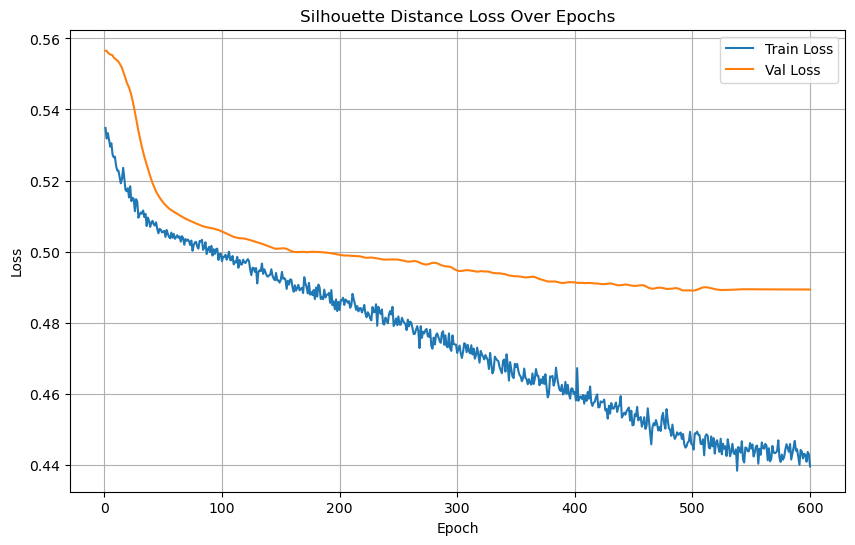

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/77], Loss: 0.3785
Test Batch [20/77], Loss: 0.0770


Test Batch [30/77], Loss: 0.1788
Test Batch [40/77], Loss: 0.5000
Test Batch [50/77], Loss: 0.1657
Test Batch [60/77], Loss: 0.3415
Test Batch [70/77], Loss: 0.5000



Test Loss: 0.3289


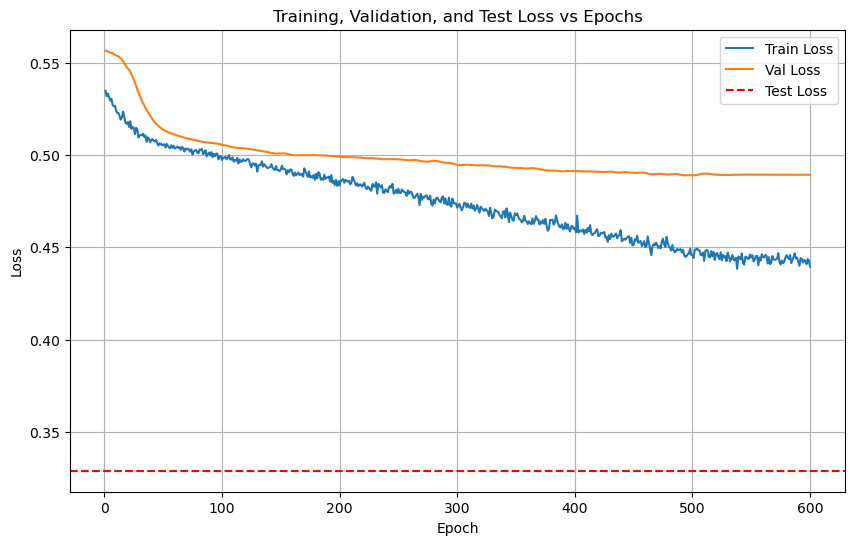

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/77 for test dataset.


  Processed batch 20/77 for test dataset.


  Processed batch 30/77 for test dataset.
  Processed batch 40/77 for test dataset.
  Processed batch 50/77 for test dataset.


  Processed batch 60/77 for test dataset.


  Processed batch 70/77 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 60.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      0.20      0.33         5
           2       0.43      0.60      0.50         5
           3       0.00      0.00      0.00         5
           4       0.67      0.80      0.73         5
           5       0.43      0.60      0.50         5
           6       0.50      0.80      0.62         5
           7       0.56      1.00      0.71         5
           8       0.83      1.00      0.91         5
           9       0.50      0.40      0.44         5
          10       1.00      1.00      1.00         5
          11       0.75      0.60      0.67         5
          12       0.80      0.80      0.80         5

    accuracy         

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6843  |  Val Loss: 2.6192
Validation loss improved from inf to 2.6192.
[Epoch 2/1000] Train Loss: 2.6530  |  Val Loss: 2.6065
Validation loss improved from 2.6192 to 2.6065.
[Epoch 3/1000] Train Loss: 2.6228  |  Val Loss: 2.5948
Validation loss improved from 2.6065 to 2.5948.
[Epoch 4/1000] Train Loss: 2.5965  |  Val Loss: 2.5840
Validation loss improved from 2.5948 to 2.5840.
[Epoch 5/1000] Train Loss: 2.5703  |  Val Loss: 2.5743
Validation loss improved from 2.5840 to 2.5743.
[Epoch 6/1000] Train Loss: 2.5471  |  Val Loss: 2.5645
Validation loss improved from 2.5743 to 2.5645.
[Epoch 7/1000] Train Loss: 2.5279  |  Val Loss: 2.5559
Validation loss improved from 2.5645 to 2.5559.
[Epoch 8/1000] Train Loss: 2.5080  |  Val Loss: 2.5484
Validation loss improved from 2.5559 to 2.5484.
[Epoch 9/1000] Train Loss: 2.4908  |  Val Loss: 2.5412
Validation loss improved from 2.5484 to 2.5412.
[Epoch 10/1000] Train Loss: 2.4727  |  Val Loss: 2.5344
Validation loss impr

[Epoch 12/1000] Train Loss: 2.4382  |  Val Loss: 2.5222
Validation loss improved from 2.5281 to 2.5222.
[Epoch 13/1000] Train Loss: 2.4246  |  Val Loss: 2.5172
Validation loss improved from 2.5222 to 2.5172.
[Epoch 14/1000] Train Loss: 2.4118  |  Val Loss: 2.5131
Validation loss improved from 2.5172 to 2.5131.
[Epoch 15/1000] Train Loss: 2.4028  |  Val Loss: 2.5093
Validation loss improved from 2.5131 to 2.5093.
[Epoch 16/1000] Train Loss: 2.3947  |  Val Loss: 2.5060
Validation loss improved from 2.5093 to 2.5060.
[Epoch 17/1000] Train Loss: 2.3878  |  Val Loss: 2.5028
Validation loss improved from 2.5060 to 2.5028.


[Epoch 18/1000] Train Loss: 2.3817  |  Val Loss: 2.5001
Validation loss improved from 2.5028 to 2.5001.


[Epoch 19/1000] Train Loss: 2.3751  |  Val Loss: 2.4971
Validation loss improved from 2.5001 to 2.4971.
[Epoch 20/1000] Train Loss: 2.3697  |  Val Loss: 2.4943
Validation loss improved from 2.4971 to 2.4943.
[Epoch 21/1000] Train Loss: 2.3643  |  Val Loss: 2.4915
Validation loss improved from 2.4943 to 2.4915.
[Epoch 22/1000] Train Loss: 2.3589  |  Val Loss: 2.4890
Validation loss improved from 2.4915 to 2.4890.
[Epoch 23/1000] Train Loss: 2.3542  |  Val Loss: 2.4866
Validation loss improved from 2.4890 to 2.4866.
[Epoch 24/1000] Train Loss: 2.3494  |  Val Loss: 2.4846
Validation loss improved from 2.4866 to 2.4846.
[Epoch 25/1000] Train Loss: 2.3447  |  Val Loss: 2.4833
Validation loss improved from 2.4846 to 2.4833.
[Epoch 26/1000] Train Loss: 2.3402  |  Val Loss: 2.4817
Validation loss improved from 2.4833 to 2.4817.
[Epoch 27/1000] Train Loss: 2.3355  |  Val Loss: 2.4802
Validation loss improved from 2.4817 to 2.4802.
[Epoch 28/1000] Train Loss: 2.3313  |  Val Loss: 2.4788
Validati

[Epoch 35/1000] Train Loss: 2.2970  |  Val Loss: 2.4647
Validation loss improved from 2.4673 to 2.4647.
[Epoch 36/1000] Train Loss: 2.2922  |  Val Loss: 2.4620
Validation loss improved from 2.4647 to 2.4620.
[Epoch 37/1000] Train Loss: 2.2873  |  Val Loss: 2.4599
Validation loss improved from 2.4620 to 2.4599.
[Epoch 38/1000] Train Loss: 2.2826  |  Val Loss: 2.4578
Validation loss improved from 2.4599 to 2.4578.


[Epoch 39/1000] Train Loss: 2.2780  |  Val Loss: 2.4558
Validation loss improved from 2.4578 to 2.4558.
[Epoch 40/1000] Train Loss: 2.2738  |  Val Loss: 2.4538
Validation loss improved from 2.4558 to 2.4538.
[Epoch 41/1000] Train Loss: 2.2695  |  Val Loss: 2.4512
Validation loss improved from 2.4538 to 2.4512.
[Epoch 42/1000] Train Loss: 2.2650  |  Val Loss: 2.4489
Validation loss improved from 2.4512 to 2.4489.
[Epoch 43/1000] Train Loss: 2.2608  |  Val Loss: 2.4468
Validation loss improved from 2.4489 to 2.4468.
[Epoch 44/1000] Train Loss: 2.2567  |  Val Loss: 2.4449
Validation loss improved from 2.4468 to 2.4449.
[Epoch 45/1000] Train Loss: 2.2526  |  Val Loss: 2.4422
Validation loss improved from 2.4449 to 2.4422.
[Epoch 46/1000] Train Loss: 2.2480  |  Val Loss: 2.4398
Validation loss improved from 2.4422 to 2.4398.
[Epoch 47/1000] Train Loss: 2.2438  |  Val Loss: 2.4376
Validation loss improved from 2.4398 to 2.4376.
[Epoch 48/1000] Train Loss: 2.2396  |  Val Loss: 2.4352
Validati

[Epoch 57/1000] Train Loss: 2.1997  |  Val Loss: 2.4171
Validation loss improved from 2.4196 to 2.4171.
[Epoch 58/1000] Train Loss: 2.1948  |  Val Loss: 2.4149
Validation loss improved from 2.4171 to 2.4149.
[Epoch 59/1000] Train Loss: 2.1903  |  Val Loss: 2.4127
Validation loss improved from 2.4149 to 2.4127.
[Epoch 60/1000] Train Loss: 2.1859  |  Val Loss: 2.4104
Validation loss improved from 2.4127 to 2.4104.
[Epoch 61/1000] Train Loss: 2.1818  |  Val Loss: 2.4082
Validation loss improved from 2.4104 to 2.4082.
[Epoch 62/1000] Train Loss: 2.1773  |  Val Loss: 2.4064
Validation loss improved from 2.4082 to 2.4064.
[Epoch 63/1000] Train Loss: 2.1729  |  Val Loss: 2.4046
Validation loss improved from 2.4064 to 2.4046.
[Epoch 64/1000] Train Loss: 2.1684  |  Val Loss: 2.4032
Validation loss improved from 2.4046 to 2.4032.
[Epoch 65/1000] Train Loss: 2.1641  |  Val Loss: 2.4014
Validation loss improved from 2.4032 to 2.4014.
[Epoch 66/1000] Train Loss: 2.1598  |  Val Loss: 2.3998
Validati

[Epoch 79/1000] Train Loss: 2.1025  |  Val Loss: 2.3713
Validation loss improved from 2.3737 to 2.3713.
[Epoch 80/1000] Train Loss: 2.0984  |  Val Loss: 2.3692
Validation loss improved from 2.3713 to 2.3692.
[Epoch 81/1000] Train Loss: 2.0943  |  Val Loss: 2.3683
Validation loss improved from 2.3692 to 2.3683.
[Epoch 82/1000] Train Loss: 2.0903  |  Val Loss: 2.3670
Validation loss improved from 2.3683 to 2.3670.
[Epoch 83/1000] Train Loss: 2.0858  |  Val Loss: 2.3651
Validation loss improved from 2.3670 to 2.3651.
[Epoch 84/1000] Train Loss: 2.0814  |  Val Loss: 2.3634
Validation loss improved from 2.3651 to 2.3634.
[Epoch 85/1000] Train Loss: 2.0774  |  Val Loss: 2.3614
Validation loss improved from 2.3634 to 2.3614.
[Epoch 86/1000] Train Loss: 2.0740  |  Val Loss: 2.3592
Validation loss improved from 2.3614 to 2.3592.
[Epoch 87/1000] Train Loss: 2.0702  |  Val Loss: 2.3570
Validation loss improved from 2.3592 to 2.3570.
[Epoch 88/1000] Train Loss: 2.0668  |  Val Loss: 2.3548
Validati

[Epoch 98/1000] Train Loss: 2.0311  |  Val Loss: 2.3349
Validation loss improved from 2.3366 to 2.3349.
[Epoch 99/1000] Train Loss: 2.0274  |  Val Loss: 2.3327
Validation loss improved from 2.3349 to 2.3327.
[Epoch 100/1000] Train Loss: 2.0237  |  Val Loss: 2.3310
Validation loss improved from 2.3327 to 2.3310.
[Epoch 101/1000] Train Loss: 2.0201  |  Val Loss: 2.3300
Validation loss improved from 2.3310 to 2.3300.
[Epoch 102/1000] Train Loss: 2.0166  |  Val Loss: 2.3283
Validation loss improved from 2.3300 to 2.3283.
[Epoch 103/1000] Train Loss: 2.0128  |  Val Loss: 2.3261
Validation loss improved from 2.3283 to 2.3261.
[Epoch 104/1000] Train Loss: 2.0091  |  Val Loss: 2.3237
Validation loss improved from 2.3261 to 2.3237.
[Epoch 105/1000] Train Loss: 2.0051  |  Val Loss: 2.3216
Validation loss improved from 2.3237 to 2.3216.
[Epoch 106/1000] Train Loss: 2.0010  |  Val Loss: 2.3200
Validation loss improved from 2.3216 to 2.3200.
[Epoch 107/1000] Train Loss: 1.9970  |  Val Loss: 2.3182


[Epoch 115/1000] Train Loss: 1.9669  |  Val Loss: 2.3018
Validation loss improved from 2.3042 to 2.3018.
[Epoch 116/1000] Train Loss: 1.9627  |  Val Loss: 2.2992
Validation loss improved from 2.3018 to 2.2992.
[Epoch 117/1000] Train Loss: 1.9591  |  Val Loss: 2.2966
Validation loss improved from 2.2992 to 2.2966.
[Epoch 118/1000] Train Loss: 1.9554  |  Val Loss: 2.2945
Validation loss improved from 2.2966 to 2.2945.
[Epoch 119/1000] Train Loss: 1.9518  |  Val Loss: 2.2926
Validation loss improved from 2.2945 to 2.2926.
[Epoch 120/1000] Train Loss: 1.9483  |  Val Loss: 2.2911
Validation loss improved from 2.2926 to 2.2911.
[Epoch 121/1000] Train Loss: 1.9446  |  Val Loss: 2.2909
Validation loss improved from 2.2911 to 2.2909.
[Epoch 122/1000] Train Loss: 1.9419  |  Val Loss: 2.2906
Validation loss improved from 2.2909 to 2.2906.
[Epoch 123/1000] Train Loss: 1.9384  |  Val Loss: 2.2898
Validation loss improved from 2.2906 to 2.2898.
[Epoch 124/1000] Train Loss: 1.9348  |  Val Loss: 2.289

[Epoch 136/1000] Train Loss: 1.8952  |  Val Loss: 2.2829
Validation loss improved from 2.2831 to 2.2829.
[Epoch 137/1000] Train Loss: 1.8922  |  Val Loss: 2.2821
Validation loss improved from 2.2829 to 2.2821.
[Epoch 138/1000] Train Loss: 1.8891  |  Val Loss: 2.2808
Validation loss improved from 2.2821 to 2.2808.
[Epoch 139/1000] Train Loss: 1.8860  |  Val Loss: 2.2741
Validation loss improved from 2.2808 to 2.2741.
[Epoch 140/1000] Train Loss: 1.8839  |  Val Loss: 2.2708
Validation loss improved from 2.2741 to 2.2708.
[Epoch 141/1000] Train Loss: 1.8810  |  Val Loss: 2.2714
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 1.8785  |  Val Loss: 2.2714
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 143/1000] Train Loss: 1.8754  |  Val Loss: 2.2715
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 144/1000] Train Loss: 1.8719  |  Val Loss: 2.2727
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 145/1000] Train Loss: 1.

[Epoch 155/1000] Train Loss: 1.8380  |  Val Loss: 2.2829
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 156/1000] Train Loss: 1.8349  |  Val Loss: 2.2828
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 157/1000] Train Loss: 1.8320  |  Val Loss: 2.2826
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 158/1000] Train Loss: 1.8291  |  Val Loss: 2.2826
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 159/1000] Train Loss: 1.8262  |  Val Loss: 2.2830
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 160/1000] Train Loss: 1.8231  |  Val Loss: 2.2828
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 161/1000] Train Loss: 1.8202  |  Val Loss: 2.2819
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 162/1000] Train Loss: 1.8173  |  Val Loss: 2.2808
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 163/1000] Train Loss: 1.8146  |  Val Loss: 2.2797
!! Validation loss did NOT improve !! Patience:

[Epoch 173/1000] Train Loss: 1.7844  |  Val Loss: 2.2744
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 174/1000] Train Loss: 1.7811  |  Val Loss: 2.2760
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 175/1000] Train Loss: 1.7780  |  Val Loss: 2.2763
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 176/1000] Train Loss: 1.7746  |  Val Loss: 2.2757
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 177/1000] Train Loss: 1.7713  |  Val Loss: 2.2738
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 178/1000] Train Loss: 1.7677  |  Val Loss: 2.2699
Validation loss improved from 2.2708 to 2.2699.
[Epoch 179/1000] Train Loss: 1.7640  |  Val Loss: 2.2698
Validation loss improved from 2.2699 to 2.2698.
[Epoch 180/1000] Train Loss: 1.7616  |  Val Loss: 2.2698
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 181/1000] Train Loss: 1.7587  |  Val Loss: 2.2692
Validation loss improved from 2.2698 to 2.2692.
[Epoch 182/100

[Epoch 191/1000] Train Loss: 1.7226  |  Val Loss: 2.2542
Validation loss improved from 2.2600 to 2.2542.
[Epoch 192/1000] Train Loss: 1.7190  |  Val Loss: 2.2504
Validation loss improved from 2.2542 to 2.2504.
[Epoch 193/1000] Train Loss: 1.7164  |  Val Loss: 2.2489
Validation loss improved from 2.2504 to 2.2489.
[Epoch 194/1000] Train Loss: 1.7128  |  Val Loss: 2.2477
Validation loss improved from 2.2489 to 2.2477.
[Epoch 195/1000] Train Loss: 1.7088  |  Val Loss: 2.2480
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 196/1000] Train Loss: 1.7047  |  Val Loss: 2.2481
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 197/1000] Train Loss: 1.7007  |  Val Loss: 2.2471
Validation loss improved from 2.2477 to 2.2471.
[Epoch 198/1000] Train Loss: 1.6965  |  Val Loss: 2.2445
Validation loss improved from 2.2471 to 2.2445.
[Epoch 199/1000] Train Loss: 1.6928  |  Val Loss: 2.2382
Validation loss improved from 2.2445 to 2.2382.
[Epoch 200/1000] Train Loss: 1.6896  |  Val

[Epoch 210/1000] Train Loss: 1.6504  |  Val Loss: 2.2405
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 211/1000] Train Loss: 1.6457  |  Val Loss: 2.2411
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 212/1000] Train Loss: 1.6416  |  Val Loss: 2.2440
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 213/1000] Train Loss: 1.6371  |  Val Loss: 2.2491
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 214/1000] Train Loss: 1.6335  |  Val Loss: 2.2516
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 215/1000] Train Loss: 1.6295  |  Val Loss: 2.2529
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 216/1000] Train Loss: 1.6251  |  Val Loss: 2.2526
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 217/1000] Train Loss: 1.6207  |  Val Loss: 2.2517
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 218/1000] Train Loss: 1.6166  |  Val Loss: 2.2489
!! Validation loss did NOT improve !! Patience: 

[Epoch 232/1000] Train Loss: 1.5598  |  Val Loss: 2.2230
Validation loss improved from 2.2243 to 2.2230.
[Epoch 233/1000] Train Loss: 1.5559  |  Val Loss: 2.2229
Validation loss improved from 2.2230 to 2.2229.
[Epoch 234/1000] Train Loss: 1.5519  |  Val Loss: 2.2228
Validation loss improved from 2.2229 to 2.2228.
[Epoch 235/1000] Train Loss: 1.5478  |  Val Loss: 2.2214
Validation loss improved from 2.2228 to 2.2214.
[Epoch 236/1000] Train Loss: 1.5441  |  Val Loss: 2.2193
Validation loss improved from 2.2214 to 2.2193.
[Epoch 237/1000] Train Loss: 1.5402  |  Val Loss: 2.2163
Validation loss improved from 2.2193 to 2.2163.
[Epoch 238/1000] Train Loss: 1.5361  |  Val Loss: 2.2133
Validation loss improved from 2.2163 to 2.2133.
[Epoch 239/1000] Train Loss: 1.5320  |  Val Loss: 2.2111
Validation loss improved from 2.2133 to 2.2111.
[Epoch 240/1000] Train Loss: 1.5281  |  Val Loss: 2.2092
Validation loss improved from 2.2111 to 2.2092.
[Epoch 241/1000] Train Loss: 1.5240  |  Val Loss: 2.208

[Epoch 251/1000] Train Loss: 1.4832  |  Val Loss: 2.2139
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 252/1000] Train Loss: 1.4792  |  Val Loss: 2.2098
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 253/1000] Train Loss: 1.4753  |  Val Loss: 2.2023
Validation loss improved from 2.2053 to 2.2023.
[Epoch 254/1000] Train Loss: 1.4724  |  Val Loss: 2.1993
Validation loss improved from 2.2023 to 2.1993.
[Epoch 255/1000] Train Loss: 1.4693  |  Val Loss: 2.1981
Validation loss improved from 2.1993 to 2.1981.
[Epoch 256/1000] Train Loss: 1.4653  |  Val Loss: 2.1984
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 257/1000] Train Loss: 1.4606  |  Val Loss: 2.1969
Validation loss improved from 2.1981 to 2.1969.
[Epoch 258/1000] Train Loss: 1.4561  |  Val Loss: 2.1948
Validation loss improved from 2.1969 to 2.1948.
[Epoch 259/1000] Train Loss: 1.4515  |  Val Loss: 2.1921
Validation loss improved from 2.1948 to 2.1921.
[Epoch 260/1000] Train Loss: 1.4477  

[Epoch 270/1000] Train Loss: 1.4069  |  Val Loss: 2.1854
Validation loss improved from 2.1866 to 2.1854.
[Epoch 271/1000] Train Loss: 1.4035  |  Val Loss: 2.1841
Validation loss improved from 2.1854 to 2.1841.
[Epoch 272/1000] Train Loss: 1.4000  |  Val Loss: 2.1837
Validation loss improved from 2.1841 to 2.1837.
[Epoch 273/1000] Train Loss: 1.3967  |  Val Loss: 2.1835
Validation loss improved from 2.1837 to 2.1835.
[Epoch 274/1000] Train Loss: 1.3921  |  Val Loss: 2.1867
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 275/1000] Train Loss: 1.3897  |  Val Loss: 2.1878
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 276/1000] Train Loss: 1.3866  |  Val Loss: 2.1867
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 277/1000] Train Loss: 1.3829  |  Val Loss: 2.1820
Validation loss improved from 2.1835 to 2.1820.
[Epoch 278/1000] Train Loss: 1.3791  |  Val Loss: 2.1847
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 279/1000] Train Loss: 1.

[Epoch 288/1000] Train Loss: 1.3427  |  Val Loss: 2.1777
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 289/1000] Train Loss: 1.3392  |  Val Loss: 2.1770
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 290/1000] Train Loss: 1.3359  |  Val Loss: 2.1764
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 291/1000] Train Loss: 1.3331  |  Val Loss: 2.1750
Validation loss improved from 2.1752 to 2.1750.
[Epoch 292/1000] Train Loss: 1.3296  |  Val Loss: 2.1731
Validation loss improved from 2.1750 to 2.1731.
[Epoch 293/1000] Train Loss: 1.3262  |  Val Loss: 2.1721
Validation loss improved from 2.1731 to 2.1721.
[Epoch 294/1000] Train Loss: 1.3230  |  Val Loss: 2.1701
Validation loss improved from 2.1721 to 2.1701.
[Epoch 295/1000] Train Loss: 1.3198  |  Val Loss: 2.1700
Validation loss improved from 2.1701 to 2.1700.
[Epoch 296/1000] Train Loss: 1.3167  |  Val Loss: 2.1700
Validation loss improved from 2.1700 to 2.1700.
[Epoch 297/1000] Train Loss: 1.3131  

[Epoch 307/1000] Train Loss: 1.2835  |  Val Loss: 2.1494
Validation loss improved from 2.1563 to 2.1494.
[Epoch 308/1000] Train Loss: 1.2801  |  Val Loss: 2.1457
Validation loss improved from 2.1494 to 2.1457.
[Epoch 309/1000] Train Loss: 1.2774  |  Val Loss: 2.1410
Validation loss improved from 2.1457 to 2.1410.
[Epoch 310/1000] Train Loss: 1.2746  |  Val Loss: 2.1371
Validation loss improved from 2.1410 to 2.1371.
[Epoch 311/1000] Train Loss: 1.2719  |  Val Loss: 2.1307
Validation loss improved from 2.1371 to 2.1307.
[Epoch 312/1000] Train Loss: 1.2700  |  Val Loss: 2.1279
Validation loss improved from 2.1307 to 2.1279.
[Epoch 313/1000] Train Loss: 1.2666  |  Val Loss: 2.1274
Validation loss improved from 2.1279 to 2.1274.
[Epoch 314/1000] Train Loss: 1.2634  |  Val Loss: 2.1279
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 315/1000] Train Loss: 1.2602  |  Val Loss: 2.1301
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 316/1000] Train Loss: 1.2571  |  Val

[Epoch 328/1000] Train Loss: 1.2251  |  Val Loss: 2.1383
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 329/1000] Train Loss: 1.2223  |  Val Loss: 2.1353
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 330/1000] Train Loss: 1.2196  |  Val Loss: 2.1348
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 331/1000] Train Loss: 1.2173  |  Val Loss: 2.1345
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 332/1000] Train Loss: 1.2149  |  Val Loss: 2.1344
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 333/1000] Train Loss: 1.2126  |  Val Loss: 2.1348
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 334/1000] Train Loss: 1.2103  |  Val Loss: 2.1342
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 335/1000] Train Loss: 1.2077  |  Val Loss: 2.1334
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 336/1000] Train Loss: 1.2051  |  Val Loss: 2.1324
!! Validation loss did NOT improve !! Patience:

[Epoch 348/1000] Train Loss: 1.1762  |  Val Loss: 2.1342
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 349/1000] Train Loss: 1.1736  |  Val Loss: 2.1312
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 350/1000] Train Loss: 1.1712  |  Val Loss: 2.1283
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 351/1000] Train Loss: 1.1699  |  Val Loss: 2.1299
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 352/1000] Train Loss: 1.1682  |  Val Loss: 2.1317
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 353/1000] Train Loss: 1.1666  |  Val Loss: 2.1325
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 354/1000] Train Loss: 1.1642  |  Val Loss: 2.1298
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 355/1000] Train Loss: 1.1613  |  Val Loss: 2.1279
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 356/1000] Train Loss: 1.1584  |  Val Loss: 2.1261
Validation loss improved from 2.1274 to 2.1261.

[Epoch 366/1000] Train Loss: 1.1374  |  Val Loss: 2.1111
Validation loss improved from 2.1131 to 2.1111.
[Epoch 367/1000] Train Loss: 1.1358  |  Val Loss: 2.1106
Validation loss improved from 2.1111 to 2.1106.
[Epoch 368/1000] Train Loss: 1.1333  |  Val Loss: 2.1135
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 369/1000] Train Loss: 1.1309  |  Val Loss: 2.1154
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 370/1000] Train Loss: 1.1286  |  Val Loss: 2.1213
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 371/1000] Train Loss: 1.1261  |  Val Loss: 2.1274
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 372/1000] Train Loss: 1.1241  |  Val Loss: 2.1301
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 373/1000] Train Loss: 1.1219  |  Val Loss: 2.1318
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 374/1000] Train Loss: 1.1196  |  Val Loss: 2.1326
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 375/10

[Epoch 385/1000] Train Loss: 1.0988  |  Val Loss: 2.1490
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 386/1000] Train Loss: 1.0970  |  Val Loss: 2.1487
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 387/1000] Train Loss: 1.0947  |  Val Loss: 2.1472
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 388/1000] Train Loss: 1.0930  |  Val Loss: 2.1466
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 389/1000] Train Loss: 1.0909  |  Val Loss: 2.1426
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 390/1000] Train Loss: 1.0887  |  Val Loss: 2.1401
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 391/1000] Train Loss: 1.0866  |  Val Loss: 2.1416
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 392/1000] Train Loss: 1.0848  |  Val Loss: 2.1429
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 393/1000] Train Loss: 1.0827  |  Val Loss: 2.1451
!! Validation loss did NOT improve !! Patience:

[Epoch 406/1000] Train Loss: 1.0590  |  Val Loss: 2.1532
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 407/1000] Train Loss: 1.0573  |  Val Loss: 2.1532
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 408/1000] Train Loss: 1.0557  |  Val Loss: 2.1540
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 409/1000] Train Loss: 1.0539  |  Val Loss: 2.1543
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 410/1000] Train Loss: 1.0520  |  Val Loss: 2.1544
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 411/1000] Train Loss: 1.0506  |  Val Loss: 2.1544
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 412/1000] Train Loss: 1.0480  |  Val Loss: 2.1550
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 413/1000] Train Loss: 1.0465  |  Val Loss: 2.1564
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 414/1000] Train Loss: 1.0448  |  Val Loss: 2.1606
!! Validation loss did NOT improve !! Patience:

[Epoch 427/1000] Train Loss: 1.0219  |  Val Loss: 2.1693
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 428/1000] Train Loss: 1.0200  |  Val Loss: 2.1684
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 429/1000] Train Loss: 1.0183  |  Val Loss: 2.1681
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 430/1000] Train Loss: 1.0166  |  Val Loss: 2.1661
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 431/1000] Train Loss: 1.0150  |  Val Loss: 2.1653
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 432/1000] Train Loss: 1.0134  |  Val Loss: 2.1656
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 433/1000] Train Loss: 1.0118  |  Val Loss: 2.1674
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 434/1000] Train Loss: 1.0107  |  Val Loss: 2.1724
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 435/1000] Train Loss: 1.0091  |  Val Loss: 2.1753
!! Validation loss did NOT improve !! Patience:

[Epoch 446/1000] Train Loss: 0.9912  |  Val Loss: 2.1789
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 447/1000] Train Loss: 0.9895  |  Val Loss: 2.1798
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 448/1000] Train Loss: 0.9877  |  Val Loss: 2.1781
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 449/1000] Train Loss: 0.9859  |  Val Loss: 2.1661
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 450/1000] Train Loss: 0.9852  |  Val Loss: 2.1620
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 451/1000] Train Loss: 0.9840  |  Val Loss: 2.1608
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 452/1000] Train Loss: 0.9833  |  Val Loss: 2.1625
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 453/1000] Train Loss: 0.9820  |  Val Loss: 2.1649
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 454/1000] Train Loss: 0.9804  |  Val Loss: 2.1663
!! Validation loss did NOT improve !! Patience:

[Epoch 464/1000] Train Loss: 0.9628  |  Val Loss: 2.1722
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 465/1000] Train Loss: 0.9616  |  Val Loss: 2.1746
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 466/1000] Train Loss: 0.9609  |  Val Loss: 2.1782
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 467/1000] Train Loss: 0.9591  |  Val Loss: 2.1804
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 467 !!
No improvement for 100 epochs.


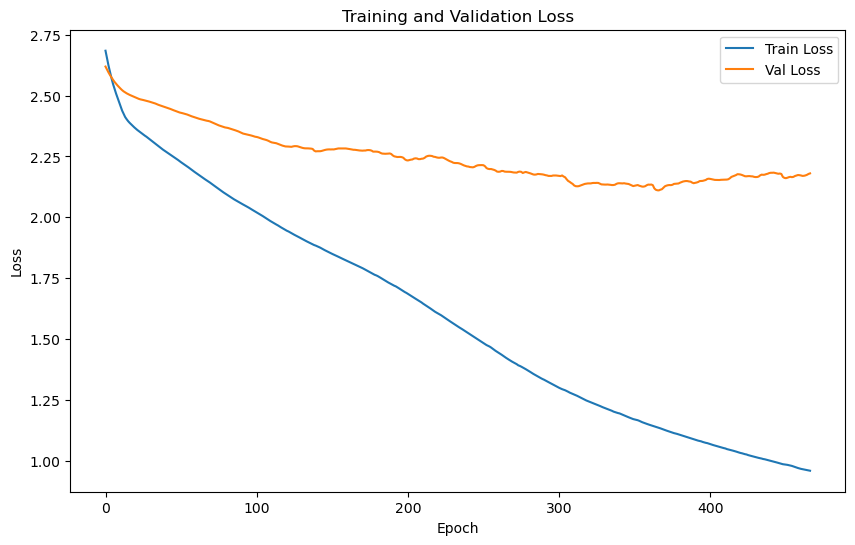

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.1554 | Test Accuracy: 52.35%


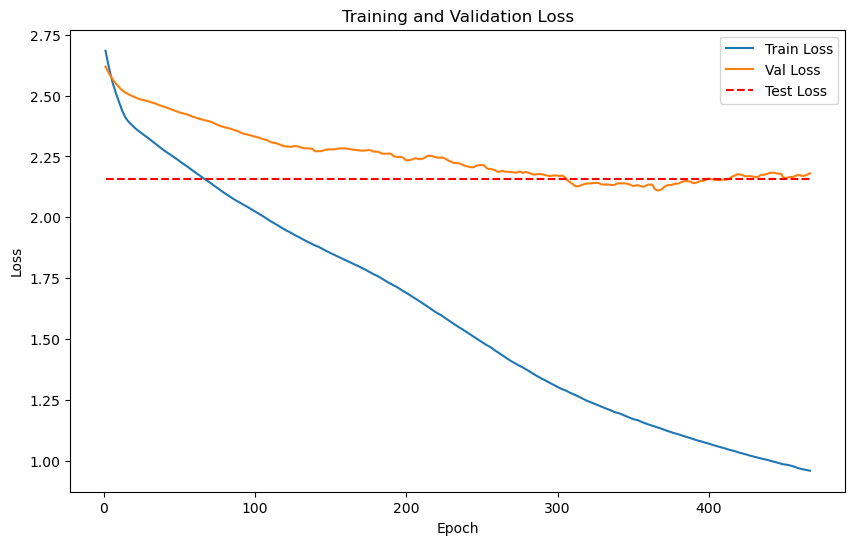

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


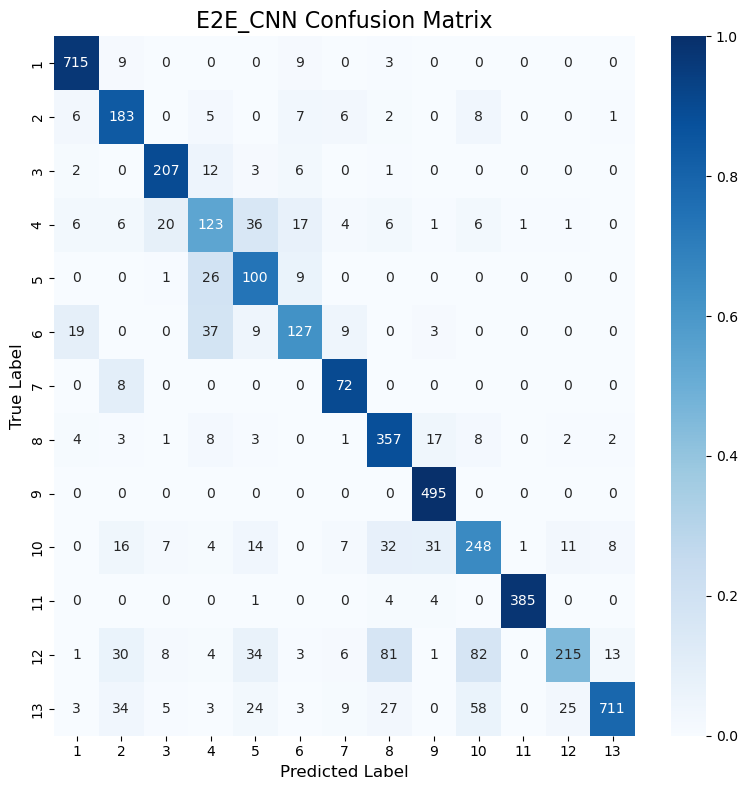

Classification Accuracy: 80.60%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


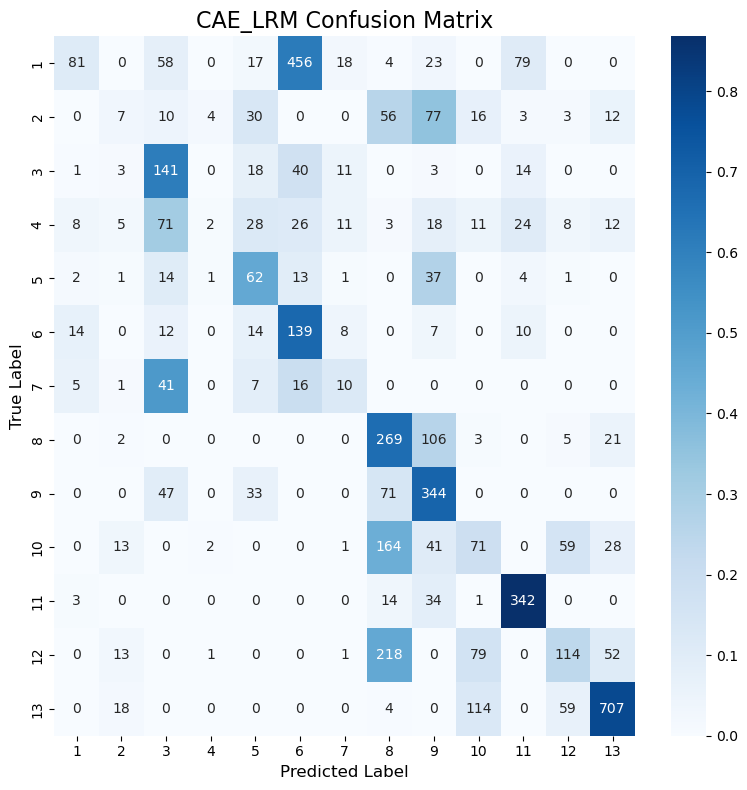

Classification Accuracy: 46.85%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


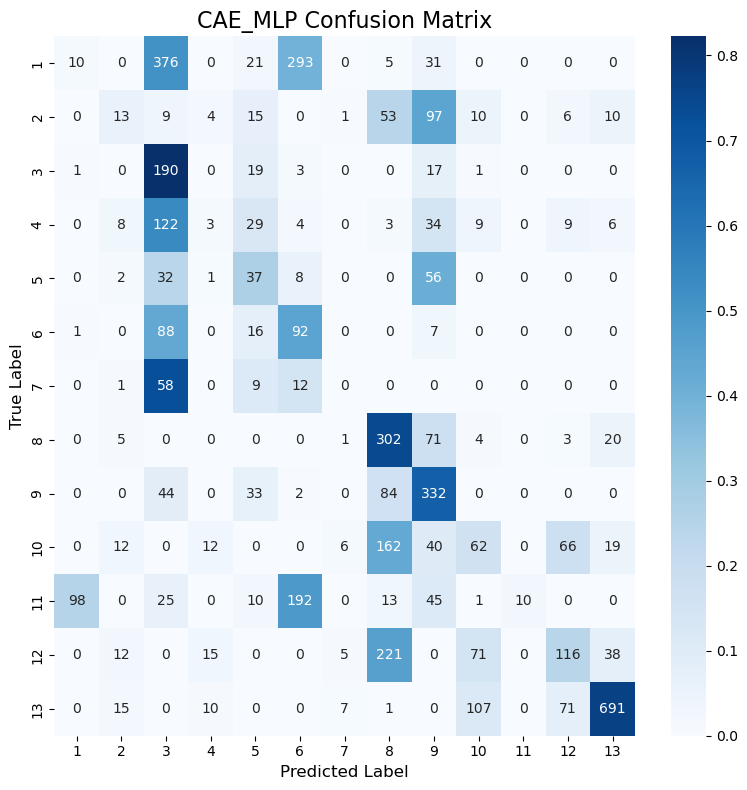

Classification Accuracy: 38.03%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


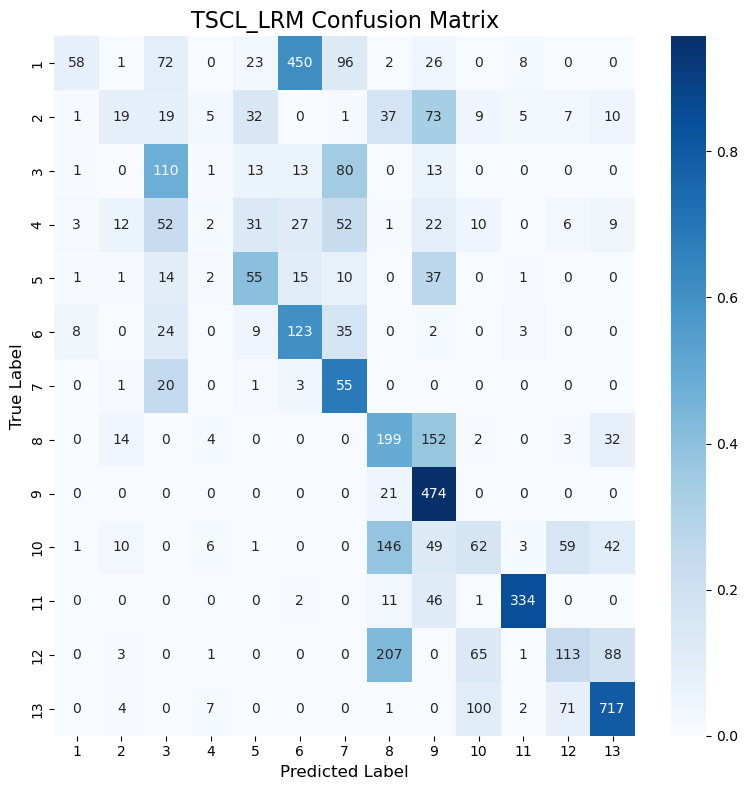

Classification Accuracy: 47.50%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


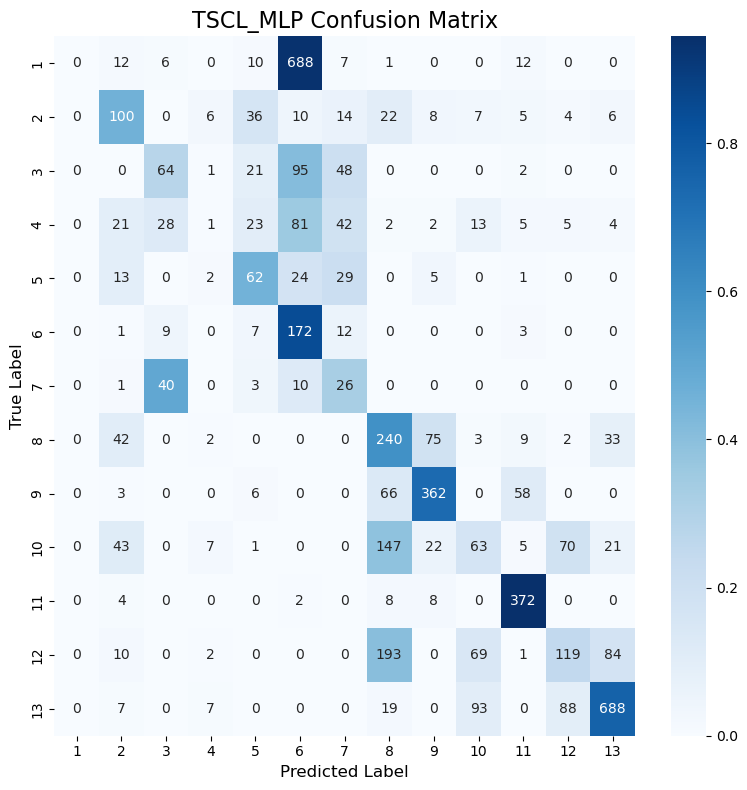

Classification Accuracy: 46.44%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


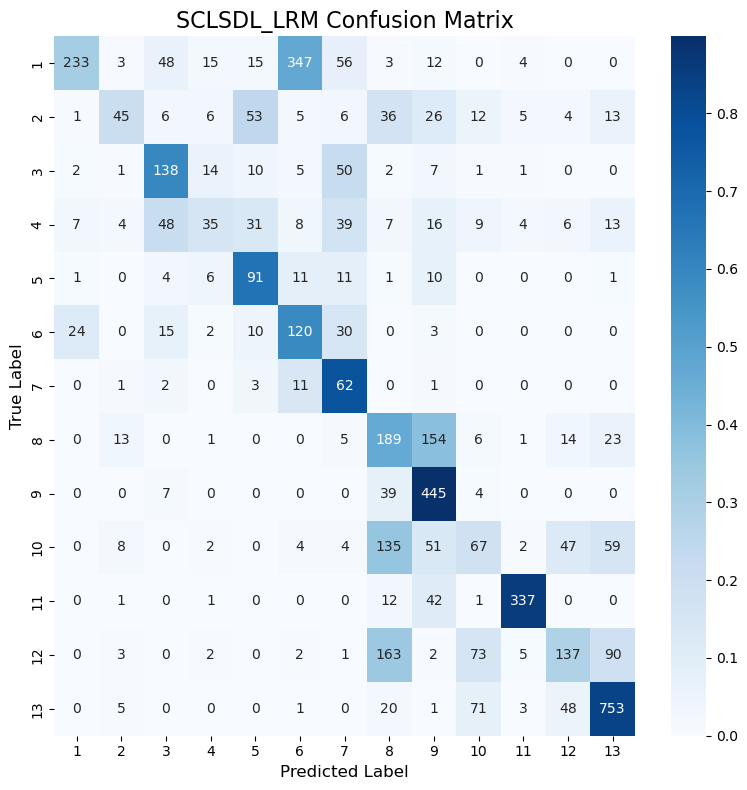

Classification Accuracy: 54.28%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


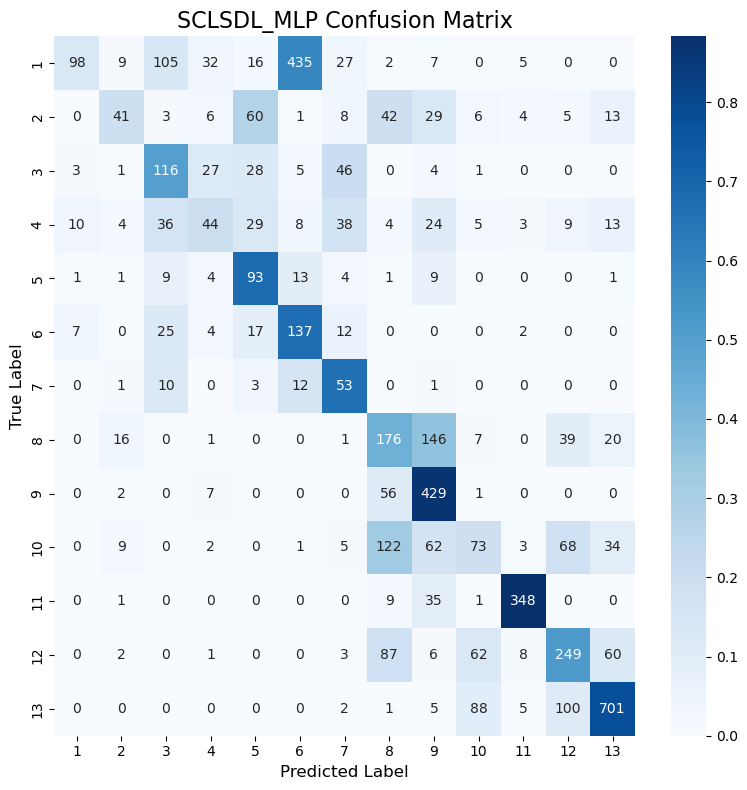

Classification Accuracy: 52.35%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          80.60
1    LRM (CAE)          46.85
2    MLP (CAE)          38.03
3     TSCL LRM          47.50
4     TSCL MLP          46.44
5  SCL_SDL LRM          54.28
6  SCL_SDL MLP          52.35

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          80.60
5  SCL_SDL LRM          54.28
6  SCL_SDL MLP          52.35
3     TSCL LRM          47.50
1    LRM (CAE)          46.85
4     TSCL MLP          46.44
2    MLP (CAE)          38.03
